In [58]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import pygsp as pg
from numpy.random import default_rng
from numpy.random import randint
from random import sample
import random
import pandas as pd
import cvxpy as cp
import time

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [59]:
def createGraph(Nodes,ComponentsNumber,i):
    graphType = randint(0, 6, 1)
    while True:
        s = np.array(sample(range(1, 10000), 1))
        if graphType==0:
            G = pg.graphs.BarabasiAlbert(N = Nodes,seed = s)
            typeName = 'BarabasiAlbert'
        elif graphType == 1:
            G = pg.graphs.RandomRegular(N = Nodes,seed = s)
            typeName = 'RandomRegular'
        elif graphType == 2:
            G = pg.graphs.DavidSensorNet(N = Nodes,seed = s)
            typeName = 'DavidSensorNet'
        elif graphType == 3:
            G = pg.graphs.Community(N = Nodes,Nc = 3,seed = s)
            typeName = 'Community'
        elif graphType == 4:
            G = pg.graphs.ErdosRenyi(N = Nodes,p = 0.1,seed = s)
            typeName = 'ErdosRenyi'
        else:
            G = pg.graphs.Sensor(N=Nodes,seed = s)
            typeName = 'Sensor'
            
        if (G.is_connected() and not(G.is_directed())):
            break
            
    print(typeName)
    G.compute_fourier_basis()
    
    return G

In [60]:
def createGraphSignal(Nodes,k,graphs,ComponentsNumber):
    signals = np.zeros((N,k))
    for i in range(k):
        idx = range(1,ComponentsNumber+1)   
        W = np.random.uniform(size=(ComponentsNumber,1))
        x =  graphs[i].U[np.ix_(range(Nodes), idx)]@W
        signals[:,[i]] = x/np.max(np.abs(x))
        
    return signals

In [61]:
def computeMainSignal(signals,k,N):
    x = np.zeros((N,1))
    for i in range(k):
        x = x + signals[:,i].reshape(N,1)
    return x

In [62]:
def computeSmoothness(signals,graphs,k):
    smoothness = []
    sumOverSmoothness = 0
    for i in range(k):
        smoothness.append(signals[:,i].T@graphs[i].L@signals[:,i])
        sumOverSmoothness = sumOverSmoothness + smoothness[i]
    return sumOverSmoothness,smoothness

In [63]:
def decomposeGraphSignal(mainSignal,signals,graphs,k,N,ComponentsNumber,s):    
    # Create A , H
    if s==1:
        w = np.arange(1,N)
    else:
        w = np.arange(1,s*(N-1),s)
        
    H = np.diag(np.tile(w, (1, k))[0])
    for i in range(k):
        G = graphs[i]
        A_init = G.U[:, 1:]
        if i==0:
            A = A_init
        else:
            A = np.hstack((A, A_init))

    # solve by CVX
    Y = cp.Variable(((N-1)*k,1))
    objective = cp.Minimize(cp.quad_form(Y, H))  
    # equality 
    constraints = [A @ Y == mainSignal]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=True)
    Y_hat = np.vstack((np.zeros((1,k)),Y.value.reshape(N-1,k,order='F')))

    # IGFT
    X_hat = np.zeros((N,k))
    for i in range(k):
        G = graphs[i]
        X_hat[:,i] = (G.U @ Y_hat[:,i])
    
    return X_hat

In [64]:
def calculateSNR(est_signals,signals,k):
    SNR = []
    for i in range(k):
        SNR.append(10*np.log10(np.linalg.norm(signals[:,i])**2/np.linalg.norm(signals[:,i]-est_signals[:,i])**2))
    return SNR

In [65]:
N = 250  # number of nodes
k = 5    # number of graphs
s = 40   # step size for weight parameters
np.random.seed(0)
random.seed(0)

In [66]:
ComponentsNumbers = 50
repeat = 20
mean_SNR = []
for ComponentsNumber in range(1,ComponentsNumbers+1):
    print('############################################# number of components = ',ComponentsNumber,' ########################################')
    
    temp_SNR = 0
    for rep in range(repeat):
        print('*********************** iter = ',rep+1,' ***********************')
        graph_list = []
        for i in range(k):
            G  = createGraph(N,ComponentsNumber,i)
            graph_list.append(G)
        
        # create graph signals
        signals = createGraphSignal(N,k,graph_list,ComponentsNumber)

        # calculate the main signal : x = x1+x2+...+x4
        mainSignal = computeMainSignal(signals,k,N)
        mainSignal = mainSignal - np.mean(mainSignal)

        # decompose graph signal
        estimated_signals = decomposeGraphSignal(mainSignal,signals,graph_list,k,N,ComponentsNumber,s)

        # calculate graph signals' smoothness
        sumOverSmoothness,smoothness = computeSmoothness(signals,graph_list,k)
        #print('sum over smoothness:',sumOverSmoothness)

        # calculate estimated graph signals' smoothness
        sumOverSmoothness_est,smoothness_est = computeSmoothness(estimated_signals,graph_list,k)
        #print('sum over smoothness_est:',sumOverSmoothness_est)

        # calculate SNRs
        SNRs = calculateSNR(estimated_signals,signals,k)
        temp_SNR = temp_SNR + np.mean(SNRs)/repeat

        # compute error
        error = np.linalg.norm(mainSignal-estimated_signals@np.ones((k,1)))
        
    mean_SNR.append(temp_SNR)
    print('mean_SNR:',temp_SNR)

############################################# number of components =  1  ########################################
*********************** iter =  1  ***********************
ErdosRenyi
Sensor


2021-12-03 19:01:46,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:01:46,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:46,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:46,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:47,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:47,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:47,511:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:47,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:47,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:48,218:[INFO](pygsp.gra

Community


2021-12-03 19:01:48,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   2.31e+05   1.00e-01   1.73e-01s
  50   1.3626e+02   2.95e-09   3.12e-06   1.00e-01   2.50e-01s
plsh   1.3626e+02   4.14e-13   

2021-12-03 19:01:54,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:01:54,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:01:54,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312153
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   2.59e+05   1.00e-01   1.72e-01s
  50   2.6538e+02   3.88e-09   3.49e-06   1.00e-01   2.50e-01s
plsh   2.6538e+0

2021-12-03 19:01:57,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312251
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.40e+00   3.50e+05   1.00e-01   2.02e-01s
  50   2.3156e+02   4.24e-09   4.71e-06   1.00e-01   3.08e-01s
plsh   2.3156e+02   

2021-12-03 19:02:02,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 19:02:03,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:03,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:03,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:02:03,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:02:04,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:04,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:04,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:05,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:05,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:05,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.47e+00   3.81e+05   1.00e-01   1.69e-01s
  50   1.8019e+02   4.24e-09   5.13e-06   1.00e-01   2.45e-01s
plsh   1.8019e+0

2021-12-03 19:02:08,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:02:08,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:08,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.03e+00   4.20e+04   1.00e-01   1.78e-01s
  50   7.6533e+00   1.72e-09   5.65e-07   1.00e-01   2.60e-01s
plsh   7.

2021-12-03 19:02:14,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:14,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:15,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.63e+00   2.58e+05   1.00e-01   1.88e-01s
  50   2.0690e+02   4.62e-09   3.48e-06   1.00e-01   2.55e-01s
plsh   2.0690e+0

2021-12-03 19:02:16,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 19:02:16,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:02:17,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:17,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   2.23e+05   1.00e-01   2.08e-01s
  50   1.1114e+02   3.14e-09   3.01e-06   1.00e-01   3.07e-01s
pl

2021-12-03 19:02:20,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:02:21,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:21,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:21,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:21,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:22,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:22,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:23,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.31e+00   1.82e+05   1.00e-01   2.63e-01s
  50   1.6890e+02   4.06e-09   2.46e-06   1.00e-01   3.54e-01s
pl

2021-12-03 19:02:26,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:02:26,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:27,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:27,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:27,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

2021-12-03 19:02:28,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:02:28,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:28,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:29,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312164
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   1.98e+05   1.00e-01   2.15e-01s
  50   1.3659e+02   3.87e-09   2.67e-06   1.00e-01   3.21e-01s
plsh   1.3659e+02   8.75e-13   

2021-12-03 19:02:31,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:31,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312209
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.80e+00   2.57e+05   1.00e-01   2.41e-01s
  50   2.2948e+02   4.93e-09   3.47e-06   1.00e-01   3.41

2021-12-03 19:02:36,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:02:36,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   2.24e+05   1.00e-01   2.01e-01s
  50   1.6581e+02   3.79e-09   3.01e-06   1.00e-01   3.00e-01s
plsh   1.6581e+02   1.31

2021-12-03 19:02:41,910:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.3167e+02   8.93e-13   2.40e-12   --------   4.99e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    231.6661
run time:             4.99e-01s
optimal rho estimate: 9.95e-03

*********************** iter =  16  ***********************
Community
RandomRegular
Sensor
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check

2021-12-03 19:02:48,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:02:48,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:48,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:02:49,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:02:49,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:49,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:50,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:50,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312251
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   2.92e+05   1.00e-01   1.85e-01s
  50   2.2455e+02   3.88e-09   3.94e-06   1.00e-01   2.66e-01s
plsh   2.2455e+02   3.45e-13   

2021-12-03 19:02:52,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************
DavidSensorNet


2021-12-03 19:02:52,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:02:52,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:52,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:53,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:53,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.73e+00   1.65e+05   1.00e-01   2.02e-01s
  50   1.3072e+02   4.69e-09   2.22e-06   1.00e-01   2.86e-01s
plsh   1.3

2021-12-03 19:02:56,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:02:56,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:02:56,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   2.38e+05   1.00e-01   1.76e-01s
  50   1.6919e+02   3.83e-09   3.20e-06   1.00e-01   

2021-12-03 19:03:02,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:03:03,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:03,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:03,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:03,893:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:04,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:04,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312190
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   2.78e+05   1.00e-01   1.86e-01s
  50   1.0510e+03   3.10e-09   3.75e-06   1.00e-01   2.71

2021-12-03 19:03:08,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:08,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:08,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:09,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:09,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:09,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:09,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:10,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:10,245:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.48e+00   2.22e+05   1.00e-01   3.76e-01s
  50   3.8900e+03   3.97e-09   2.99e-06   1.00e-01   5.08e-01s
plsh   3.8900e+03   1.61e-13   

2021-12-03 19:03:16,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:03:16,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:17,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312347
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   1.77e+05   1.00e-01   1.75e-01s
  50   1.7770e+03   3.40e-09   2.39e-06   1.00e-01   2.61e-01s
plsh  

2021-12-03 19:03:19,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 19:03:19,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:20,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:03:20,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:03:21,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:21,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:21,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:21,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:21,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:22,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:22,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:22,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:22,780:[INFO](pygsp.gra

Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312192
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.57e+00   2.22e+05   1.00e-01   2.03e-01s
  50   1.2573e+03   4.30e-09   2.99e-06   1.00e-01   2.86e-01s


2021-12-03 19:03:25,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.2573e+03   3.18e-13   2.37e-12   --------   4.02e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    1257.3069
run time:             4.02e-01s
optimal rho estimate: 1.82e-02

*********************** iter =  6  ***********************
DavidSensorNet
Community
BarabasiAlbert
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          chec

2021-12-03 19:03:28,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:03:28,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.27e+00   2.43e+05   1.00e-01   1.92e-01s
  50   8.5508e+03   4.65e-09   3.28e-06   1.00e-01   2.71e-01s
plsh   8.5508e+03   1.36

2021-12-03 19:03:36,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.2440e+03   1.91e-12   3.17e-12   --------   4.13e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    3244.0303
run time:             4.13e-01s
optimal rho estimate: 2.24e-02

*********************** iter =  10  ***********************


2021-12-03 19:03:36,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:03:36,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.33e+00   5.44e+05   1.00e-01   1.91e-01s
  50   3.8958e+03   3.77e-09   7.32e-06   1.00e-01   2.68e-01s
pls

2021-12-03 19:03:39,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:03:40,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:03:40,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:40,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312308
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.47e+00   2.44e+05   1.00e-01   1.92e-01s
  50   9.3158e+02   4.01e-09   3.28e-06   1.00e-01   2.68e-01s
plsh   9.3158e+02   2.72e-13   

2021-12-03 19:03:48,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:03:49,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:49,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312204
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   2.61e+05   1.00e-01   2.06e-01s
  50   6.5850e+02   3.36e-09   3.51e-06   1.00e-01   2.87e-01s
plsh   6.5850e+0

2021-12-03 19:03:54,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
DavidSensorNet


2021-12-03 19:03:54,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:54,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:55,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:55,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.38e+00   2.27e+05   1.00e-01   1.72e-01s
  50   5.0669e+03   3.67e-09   3.06e-06   1.00e-01

2021-12-03 19:03:58,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:58,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:58,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:59,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:59,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:59,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:59,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:03:59,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:00,137:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.75e+00   2.50e+05   1.00e-01   1.77e-01s
  50   4.3223e+03   4.44e-09   3.36e-06   1.00e-01   2.51e-01s
plsh   4.3223e+03   2.55e-14   

2021-12-03 19:04:05,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************


2021-12-03 19:04:05,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:06,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:06,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:06,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:06,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:07,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:07,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:07,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:07,708:[INFO](pygsp.gra

Community


2021-12-03 19:04:07,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:08,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:08,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:08,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:08,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:09,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:09,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:09,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312364
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   4.32e+05   1.00e-01   1.90e-01s
  50   4.0371e+02   3.18e-09   5.82e-06   1.00e-01   2.70

2021-12-03 19:04:12,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 19:04:12,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:12,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:13,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:13,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:13,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:13,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:14,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:14,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:14,464:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312345
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.04e+00   2.33e+05   1.00e-01   2.05e-01s
  50   4.0116e+03   4.73e-09   3.15e-06   1

2021-12-03 19:04:18,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
DavidSensorNet


2021-12-03 19:04:18,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:18,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:19,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:19,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:19,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:19,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.64e+05   1.00e-01   1.94e-01s
  50   4.0314e+03   2.67e-09   2.21e-06   1.00e-01   2.73e-01s
plsh

2021-12-03 19:04:21,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   4.0314e+03   1.79e-13   2.30e-12   --------   3.90e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    4031.4406
run time:             3.90e-01s
optimal rho estimate: 2.39e-02

*********************** iter =  2  ***********************
Sensor


2021-12-03 19:04:21,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:22,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:22,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:22,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   2.11e+05   1.00e-01   2.07e-01s
  50   5.8478e+03   3.27e-09   2.85e-06   1.00e-01   2

2021-12-03 19:04:26,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312350
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   1.95e+05   1.00e-01   1.92e-01s
  50   4.4982e+03   3.26e-09   2.63e-06   1.00e-01   2.75e-01s
plsh   4.4982e+0

2021-12-03 19:04:30,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 19:04:30,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:30,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:04:31,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 19:04:31,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   9.69e+04   1.00e-01   1.82e-01s
  50   3.8911e+03   2.31e-09   1.31e-06   1.00e-01   2.58e-01s
plsh

2021-12-03 19:04:33,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.8911e+03   4.92e-15   9.35e-13   --------   3.69e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    3891.1308
run time:             3.69e-01s
optimal rho estimate: 3.30e-02

*********************** iter =  6  ***********************
Sensor


2021-12-03 19:04:33,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:34,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:34,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:34,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:34,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:34,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.56e+00   1.77e+05   1.00e-01   1.88e-01s
  50   7.3593e+03   3.88e-09   2.38e-06   1.00e-01   2.69

2021-12-03 19:04:40,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
ErdosRenyi
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312380
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   4.63e+05   1.00e-01   1.93e-01s
  50   4.1838e+03   2.31e-09   6.24e-06   1

2021-12-03 19:04:43,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312304
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   1.69e+05   1.00e-01   1.85e-01s
  50   2.0244e+03   3.57e-09   2.27e-06   1.00e-01   2.67e-01s
plsh   2.0244

2021-12-03 19:04:48,687:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 19:04:48,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:49,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:49,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:49,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:49,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:50,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:50,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:50,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:50,718:[INFO](pygsp.gra

Community
DavidSensorNet
Sensor
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   5.21e+05   1.00e-01   2.18e-01s
  50   6.9161e+03   3.60e-09   7.02e-06   1.00e-01 

2021-12-03 19:04:54,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:54,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   6.9161e+03   1.43e-13   4.39e-12   --------   4.30e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    6916.1149
run time:             4.30e-01s
optimal rho estimate: 2.59e-02

*********************** iter =  12  ***********************


2021-12-03 19:04:54,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:54,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:55,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:55,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:04:55,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:55,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:56,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:56,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:56,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:04:57,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:57,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:57,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:57,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:57,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:58,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:58,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:58,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:04:58,821:[INFO](pygsp.gra

Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312461
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.48e+00   6.76e+05   1.00e-01   2.04e-01s
  50   2.4616e+03   3.34e-09   9.11e-06   1.00e-01   2.96e-01s
plsh   2.4616e+03

2021-12-03 19:05:07,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:05:07,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:05:08,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:05:08,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:08,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:09,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:09,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:09,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312300
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   2.37e+05   1.00e-01   2.15e-01s
  50   5.9206e+03   3.35e-09   3.19e-06   1.00e-01   3.00e-01s
plsh   5.9206e+03   1.30e-13   

2021-12-03 19:05:11,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************
Community


2021-12-03 19:05:11,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:05:12,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:12,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.35e+00   2.67e+05   1.00e-01   2.00e-01s
  50   5.3074e+03   3.48e-09   3.60e-06   1.00e-01   2.94e-01s
plsh   5.3

2021-12-03 19:05:14,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:05:15,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:15,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:15,691:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:15,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:16,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:16,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:05:16,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:16,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:16,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:17,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:17,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:17,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:17,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:17,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   1.64e+05   1.00e-01   1.90e-01s
  50   3.3917e+03   2.24e-09   2.21e-06   1.00e-01   2.78e-01s
pl

2021-12-03 19:05:22,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312004
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   1.74e+05   1.00e-01   1.97e-01s
  50   7.0265e+03   3.05e-09   2.35e-06   1.00e-01   2.68e-01s
p

2021-12-03 19:05:25,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 19:05:26,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:26,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:26,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   4.28e+05   1.00e-01   1.85e-01s
  50   5.4297e+03   3.29e-09   5.77e-06   1.00e-01   2.59e-01s
plsh   5.4297e+03

2021-12-03 19:05:31,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.36e+00   2.35e+05   1.00e-01   1.85e-01s
  50   6.4746e+03   3.57e-09   3.17e-06   1.00e-01   2.64

2021-12-03 19:05:35,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:05:35,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:35,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:36,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:36,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:36,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:36,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:36,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:37,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:37,347:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312123
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   1.75e+05   1.00e-01   2.07e-01s
  50   8.4142e+03   2.65e-09   2.35e-06   1.00e-01   2.90e-01s
plsh   8.4142e+03   1.24e-12   

*********************** iter =  9  ***********************
BarabasiAlbert
DavidSensorNet


2021-12-03 19:05:58,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:05:59,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:59,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:59,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:59,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:59,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:05:59,859:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:00,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:00,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:00,559:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312379
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.81e+00   1.78e+05   1.00e-01   1.97e-01s
  50   7.9102e+03   4.31e-09   2.40e-06   1.00e-01   2.87e-01s
plsh

2021-12-03 19:06:03,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   7.9102e+03   3.18e-13   1.72e-12   --------   3.99e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    7910.2188
run time:             3.99e-01s
optimal rho estimate: 2.80e-02

*********************** iter =  10  ***********************
DavidSensorNet


2021-12-03 19:06:03,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:06:03,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:04,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:04,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:06:04,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:04,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:04,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:05,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:05,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:05,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:05,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:06,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:06,283:[INFO](pygsp.gra

Community


2021-12-03 19:06:08,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312456
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.13e+00   3.13e+05   1.00e-01   2.00e-01s
  50   2.3980e+03   1.74e-09   4.21e-06   1.00e-01   2.81e-01s
plsh   2.3980e+03   5.33e-14   

2021-12-03 19:06:10,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312190
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   6.23e+05   1.00e-01   2.15e-01s
  50   9.3213e+03   3.27e-09   8.40e-06   1.00e-01   3.01

2021-12-03 19:06:13,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:06:13,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:13,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   3.63e+05   1.00e-01   1.93e-01s
  50   2.8295e+03   2.96e-09   4.89e-06   1.00e-01   2.76e-01

2021-12-03 19:06:17,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:06:18,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:18,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:18,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:18,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   1.18e+05   1.00e-01   1.97e-01s
  50   2.1477e+03   2.02e-09   1.59e-06   1.00e-01   2.75e-01s
plsh   2.1477e+03   1.09e-13   

2021-12-03 19:06:23,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:06:23,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:23,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:24,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:24,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:24,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:24,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:25,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:25,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:25,507:[INFO](pygsp.gra

Community


2021-12-03 19:06:26,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312304
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   3.40e+05   1.00e-01   2.02e-01s
  50   4.7130e+03   2.80e-09   4.58e-06   1.00e-01   2.84e-01s
pl

2021-12-03 19:06:29,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:29,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:06:29,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:30,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312195
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   2.20e+05   1.00e-01   1.84e-01s
  50   5.9520e+03   2.46e-09   2.96e-06   1.00e-01   2.63e-01s
plsh   5.9520e+03   1.55e-12   

2021-12-03 19:06:31,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:06:32,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:32,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:32,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:06:32,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:33,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:33,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:33,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:33,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:34,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:34,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:34,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   1.76e+05   1.00e-01   1.81e-01s
  50   7.3466e+03   3.03e-09   2.36e-06   1.00e-01   2.61e-01s
plsh   7.3466e+03

2021-12-03 19:06:37,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:06:37,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:38,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:38,281:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:06:38,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:38,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:38,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   3.06e+05   1.00e-01   1.99e-01s
  50   5.0612e+03   3.15e-09   4.12e-06   1.00e-01   2.85e-01s
plsh   5.0612e+03   4.84e-13   

2021-12-03 19:06:41,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:06:41,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:41,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:41,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:42,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:42,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312262
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   3.49e+05   1.00e-01   2.08e-01s
  50   2.9279e+03   2.52e-09   4.70e-06   1.00e-01   2

2021-12-03 19:06:45,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:06:45,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312162
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   1.83e+05   1.00e-01   2.08e-01s
  50   3.6280e+03   2.27e-09   2.46e-06   1.00e-0

2021-12-03 19:06:54,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:06:55,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:55,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:55,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:06:55,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:55,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:56,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:06:56,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   9.39e+05   1.00e-01   2.03e-01s
  50   4.2229e+03   2.54e-09   1.26e-05   1.00e-01   2.96e-01s
plsh   4.2229e+03   8.60e-15   

2021-12-03 19:06:58,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************
Sensor


2021-12-03 19:06:58,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:58,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:59,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:59,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:59,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:59,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:06:59,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:00,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:00,354:[INFO](pygsp.gra

Community


2021-12-03 19:07:01,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:07:02,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:07:02,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312466
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   6.35e+05   1.00e-01   1.96e-01s
  50   6.0347e+03   3.47e-09   8.55e-06   1.00e-01   2.70e-01s
plsh   6.0347e+03   2.11e-14   

2021-12-03 19:07:06,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 19:07:07,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:07,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:07,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:07,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   3.71e+05   1.00e-01   1.81e-01s
  50   6.4022e+03   2.93e-09   4.99e-06   1.00e

2021-12-03 19:07:10,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312244
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   1.21e+05   1.00e-01   2.11e-01s
  50   6.2670e+03   2.39e-09   1.63e-06   1.00e-01

2021-12-03 19:07:13,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:07:14,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   1.71e+05   1.00e-01   2.05e-01s
  50   5.7457e+03   2.09e-09   2.31e-06   1.00e-01   2.91e-01s
plsh   5.7457e+03   1.88

2021-12-03 19:07:17,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:07:17,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:17,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:17,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:18,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:18,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:18,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:18,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:19,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:19,301:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.79e+00   1.61e+05   1.00e-01   2.10e-01s
  50   5.5371e+03   4.00e-09   2.17e-06   1.00e-01   2.96e-01s
plsh   5.5371e+03   6.08e-13   

2021-12-03 19:07:22,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   2.82e+05   1.00e-01   2.01e-01s
  50   9.0729e+03   4.22e-09   3.80e-06   1.00e-01   2.92e-01s
plsh  

2021-12-03 19:07:27,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:07:28,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:28,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:28,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:28,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:29,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:29,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:29,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:29,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:30,168:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   6.00e+04   1.00e-01   1.89e-01s
  50   2.7509e+03   2.28e-09   8.08e-07   1.00e-01   2.69e-01s
plsh   2.7509e+03   7.24e-14   

2021-12-03 19:07:36,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:07:36,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:36,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312298
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   1.11e+06   1.00e-01   2.11e-01s
  50   4.8909e+03   3.26e-09   1.50e-05   1.00e-01   2.83e

2021-12-03 19:07:42,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:07:42,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:43,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:07:43,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:43,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:43,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:44,174:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:44,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:44,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:44,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:45,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:45,261:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   1.76e+05   1.00e-01   2.11e-01s
  50   4.4551e+03   3.40e-09   2.38e-06   1.00e-01   2.93e-01s
plsh   4.4551e+0

2021-12-03 19:07:50,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  17  ***********************


2021-12-03 19:07:51,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:51,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   2.67e+05   1.00e-01   1.88e-01s
  50   8.3410e+03   2.72e-09   3.59e-06   1

2021-12-03 19:07:57,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:58,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:58,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:58,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:58,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:58,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:59,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:59,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:07:59,645:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312185
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   2.12e+05   1.00e-01   2.06e-01s
  50   8.8140e+03   2.12e-09   2.85e-06   1.00e-01   2.79e-01s
plsh   8.8140e+03   1.33e-13   

2021-12-03 19:08:01,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************
DavidSensorNet


2021-12-03 19:08:02,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 19:08:06,433:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.60e+05   1.00e-01   2.08e-01s
  50   1.2389e+04   2.36e-09   2.16e-06   1.00e-01   2.88e-01s
plsh   1.2389e+04   

2021-12-03 19:08:09,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:08:09,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:09,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:09,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:10,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:10,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312350
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   1.64e+05   1.00e-01   2.41e-01s
  50   7.0335e+03   2.76e-09   2.21e-06   1.00e-01   3.37e-01s
plsh   7.0335e+03   1.76

2021-12-03 19:08:12,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:12,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:08:13,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:08:13,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:14,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:14,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 19:08:16,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.52e+00   2.80e+05   1.00e-01   2.03e-01s
  50   7.5239e+03   3.73e-09   3.77e-06   1.00e-01   2.80e-01s
plsh   7.5239e+03   1.01e-13   3.54e-12  

2021-12-03 19:08:16,519:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:16,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   1.81e+05   1.00e-01   2.09e-01s
  50   1.2947e+04   2.36e-09   2.44

2021-12-03 19:08:22,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.0240e+04   4.96e-13   2.54e-12   --------   4.23e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    10240.4734
run time:             4.23e-01s
optimal rho estimate: 4.57e-02

*********************** iter =  5  ***********************


2021-12-03 19:08:22,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:22,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:22,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:23,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:23,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:23,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:23,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:24,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   2.83e+05   1.00e-01   1.77e-01s
  50   7.5605e+03   3.19e-09   3.81e-06   1.00e-01  

2021-12-03 19:08:26,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   7.5605e+03   7.27e-15   6.65e-12   --------   3.76e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    7560.5489
run time:             3.76e-01s
optimal rho estimate: 4.99e-02

*********************** iter =  6  ***********************


2021-12-03 19:08:26,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:27,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:27,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:27,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312307
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   2.73e+05   1.00e-01   1.83e-01s
  50   6.4267e+03   2.42e-09   3.68e-06   1

2021-12-03 19:08:33,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:33,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:34,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:34,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.31e+00   2.14e+05   1.00e-01   1.93e-01s
  50   1.2016e+04   3.02e-09   2.88e-06   1.00e-01   2.78e-01s
plsh   1.2016e+04   8.32e-14   

2021-12-03 19:08:35,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 19:08:36,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   2.30e+05   1.00e-01   1.81e-01s
  50   8.1340e+03   2.91e-09   3.09e-06   1.00

2021-12-03 19:08:39,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:08:39,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.84e+00   2.49e+05   1.00e-01   1.98e-01s
  50   1.0444e+04   3.37e-09   3.35e-06   1.00e-01   2.77e-01s
plsh   1.0444e+04   1.37e-13   

2021-12-03 19:08:54,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:08:54,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:54,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:54,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:08:55,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312342
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   2.71e+05   1.00e-01   1.87e-01s
  50   6.2898e+03   2.65e-09   3.65e-06   1.00e-01   2.70e-01s
plsh   6.2898e+03   

2021-12-03 19:09:00,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:09:00,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:01,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   2.50e+05   1.00e-01   1.46e-01s
  50   9.8053e+03   2.22e-09   3.37e-06   1.00e-01   2.02e-01s
pl

2021-12-03 19:09:03,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:09:03,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:04,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:04,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   1.58e+05   1.00e-01   1.93e-01s
  50   1.2074e+04   2.68e-09   2.13e-06   1.00e-01   2.75e-01s
plsh   1.2074e+0

2021-12-03 19:09:09,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:09,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:09,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:09,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:10,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:10,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:10,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:10,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:11,054:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.74e+00   1.25e+05   1.00e-01   1.85e-01s
  50   1.0437e+04   3.88e-09   1.69e-06   1.00e-01   2.62e-01s
plsh   1.

2021-12-03 19:09:13,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 15.108231456456155
############################################# number of components =  7  ########################################
*********************** iter =  1  ***********************
Sensor


2021-12-03 19:09:13,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:14,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:14,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:14,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
RandomRegular


2021-12-03 19:09:17,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312365
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   1.58e+05   1.00e-01   2.05e-01s
  50   1.1599e+04   2.69e-09   2.13e-06   1.00e-01   2.87e-01s
plsh   1.1599e+04   5.68e-13   1.84e-12  

2021-12-03 19:09:17,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:09:17,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:18,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:18,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:18,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:18,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   3.08e+05   1.00e-01   1.83e-01s
  50   1.1684e+04   2.69e-09   4.16e-06   1.00e-01  

2021-12-03 19:09:23,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 19:09:24,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:24,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:24,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:24,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:09:25,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:09:25,459:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312283
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.28e+00   2.13e+05   1.00e-01   1.96e-01s
  50   3.4079e+03   2.50e-09   2.87e-06   1.00e-01   2.78e-01s
plsh 

2021-12-03 19:09:28,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:09:28,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:28,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:29,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:29,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:29,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:29,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:30,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312135
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   1.37e+05   1.00e-01   1.90e-01s
  50   6.6654e+03   3.09e-09   1.85e-06   1.00e-0

2021-12-03 19:09:32,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:09:33,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:33,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:33,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:33,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:09:33,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   2.25e+05   1.00e-01   1.88e-01s
  50   5.4296e+03   2.39e-09   3.03e-06   1.00e-01   2.70e-01s
plsh   5.4296e+03

2021-12-03 19:09:38,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************


2021-12-03 19:09:38,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:39,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:39,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:39,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:39,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:40,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:40,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:40,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:40,847:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:09:41,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:09:42,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:42,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:42,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:42,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:43,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:43,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:43,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:43,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:44,072:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.31e+00   2.42e+05   1.00e-01   2.02e-01s
  50   3.4720e+03   1.95e-09   3.26e-06   1.00e-01   2.86e-01s
plsh   3.4720e+03   3.62

2021-12-03 19:09:46,296:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 19:09:46,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   2.72e+05   1.00e-01   2.02e-01s
  50   4.5320e+03   2.73e-09   3.66e-06   

2021-12-03 19:09:48,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   4.5320e+03   5.94e-14   6.68e-12   --------   4.01e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    4532.0157
run time:             4.01e-01s
optimal rho estimate: 2.49e-02

*********************** iter =  10  ***********************
Community
ErdosRenyi
Sensor
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_te

2021-12-03 19:09:52,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:09:52,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:52,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:53,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:53,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:53,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:53,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312308
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.41e+00   2.36e+05   1.00e-01   1.92e-01s
  50   9.8826e+03   3.11e-09   3.18e-06   1.00e-01   2.72e-01s
p

2021-12-03 19:09:55,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    9882.6044
run time:             3.92e-01s
optimal rho estimate: 4.14e-02

*********************** iter =  12  ***********************
Community
RandomRegular
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scalin

2021-12-03 19:09:58,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


optimal objective:    11693.0656
run time:             3.87e-01s
optimal rho estimate: 3.20e-02

*********************** iter =  13  ***********************
Sensor


2021-12-03 19:09:58,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:59,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:59,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:59,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:59,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:09:59,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:00,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:10:00,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:10:01,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:01,291:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:01,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312246
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.37e+00   1.95e+05   1.00e-01   2.03e-01s
  50   5.9895e+03   1.73e-09   2.63e-06   1.00e-01   2.81e-01s
plsh   5.9895e+03   8.39

2021-12-03 19:10:06,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:10:07,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:10:07,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:07,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312178
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   1.14e+05   1.00e-01   1.97e-01s
  50   8.3715e+03   1.63e-09   1.53e-06   1.00e-01   2.79e-01s
plsh   8.3715e+03   1.42e-12   

2021-12-03 19:10:21,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   8.7391e+03   4.28e-14   4.70e-12   --------   4.21e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    8739.0506
run time:             4.21e-01s
optimal rho estimate: 3.49e-02

*********************** iter =  20  ***********************


2021-12-03 19:10:21,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:21,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:21,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:22,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:22,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   3.79e+05   1.00e-01   1.98e-01s
  50   1.0972e+04   4.21e-09   5.11e-06   1.00e-01   2.7

2021-12-03 19:10:27,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3243e+04   7.12e-13   5.17e-12   --------   4.14e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    13242.5762
run time:             4.14e-01s
optimal rho estimate: 3.93e-02

*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 19:10:28,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312378
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.38e+00   2.13e+05   1.00e-01   1.72e-01s
  50   1.0769e+04   2.96e-09   2.87e-06   1.00e-01   2.46e-01s
pl

2021-12-03 19:10:33,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:10:34,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:34,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312357
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.28e+00   1.93e+05   1.00e-01   1.94e-01s
  50   1.2641e+04   3.01e-09   2.61e-06   1.00e-01   2.78e-01s
plsh   1.2641e+04   5.08e-13   

2021-12-03 19:10:36,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
DavidSensorNet


2021-12-03 19:10:36,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:10:37,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:10:37,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:37,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:37,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:38,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:38,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:38,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:38,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:10:39,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:39,223:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:39,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:39,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:39,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:40,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:40,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:40,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:40,808:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312443
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   6.37e+05   1.00e-01   1.97e-01s
  50   3.9630e+03   1.85e-09   8.58e-06   1.00e-01   2.73e-01s
plsh   3.9630e+03   6.61e-14   

2021-12-03 19:10:46,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:10:46,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:46,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:46,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   3.55e+05   1.00e-01   1.83e-01s
  50   1.4703e+04   2.23e-09   4.78e-06   1.00e-01   2.59e-01s
plsh   1.4703e+04   4.26e-14   

2021-12-03 19:10:48,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************
Sensor


2021-12-03 19:10:48,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:49,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   2.04e+05   1.00e-01   1.70e-01s
  50   6.9216e+03   1.83e-09   2.75e-06   1.00e-01   2.49e-01s
plsh  

2021-12-03 19:10:51,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:10:51,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312296
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.64e+00   1.19e+05   1.00e-01   1.89e-01s
  50   1.3156e+04   3.40e-09   1.61e-06   1.00e-01   2.76e-01s
plsh   1.

2021-12-03 19:10:58,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:10:58,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:58,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:59,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:59,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:10:59,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:59,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:10:59,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:00,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:00,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:00,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:00,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:01,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:01,358:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312297
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   1.05e+06   1.00e-01   2.10e-01s
  50   4.9930e+03   2.47e-09   1.42e-05   1.00e-01   2.91e-01s
plsh   4.9930e+03   2.85e-13   

2021-12-03 19:11:05,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:05,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:06,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:06,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:06,519:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:06,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:07,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   8.97e+04   1.00e-01   2.04e-01s
  50   7.4619e+03   2.42e-09   1.21e-06   1.00e-01   2.85e-01s
plsh   7.

2021-12-03 19:11:12,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:11:13,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:13,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:13,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:11:13,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 311997
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   1.96e+05   1.00e-01   1.95e-01s
  50   1.1534e+04   2.01e-09   2.64e-06   1.00e-01   2.77e-01s
plsh   1.1534e+04   2.35e-13   

2021-12-03 19:11:16,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:11:16,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:16,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:16,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   3.06e+05   1.00e-01   1.91e-01s
  50   8.9112e+03   2.81e-09   4.13e-06   1.00e-01   2.69e-01

2021-12-03 19:11:22,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:11:22,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:11:23,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:23,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:11:23,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:23,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:24,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:24,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:24,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   6.18e+05   1.00e-01   1.98e-01s
  50   7.3660e+03   1.89e-09   8.32e-06   1.00e-01   2.83e-01s
plsh   7.3660e+03   1.88e-14   

2021-12-03 19:11:29,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.7110e+04   3.80e-13   1.66e-12   --------   4.17e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17109.9016
run time:             4.17e-01s
optimal rho estimate: 5.49e-02

*********************** iter =  18  ***********************
Sensor


2021-12-03 19:11:29,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:29,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:30,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:30,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:30,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:30,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:30,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.09e+00   2.72e+05   1.00e-01   1.70e-01s
  50   8.1948e+03   3.30e-09   3.66e-06   1.00e-01   2.51e

2021-12-03 19:11:45,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.4950e+04   5.63e-13   2.72e-12   --------   3.78e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    14949.6743
run time:             3.78e-01s
optimal rho estimate: 6.05e-02

*********************** iter =  3  ***********************
Community
Sensor
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_t

2021-12-03 19:11:48,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:11:49,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   1.39e+05   1.00e-01   1.95e-01s
  50   1.3427e+04   2.10e-09   1.88e-06   1.00e-01   2.74e-01s
plsh   1.3427e+04

2021-12-03 19:11:51,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 19:11:51,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   2.48e+05   1.00e-01   2.00e-01s
  50   1.3707e+04   2.66e-09   3.34e-06   1

2021-12-03 19:11:57,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


number of iterations: 50
optimal objective:    5926.1767
run time:             4.14e-01s
optimal rho estimate: 3.11e-02

*********************** iter =  7  ***********************


2021-12-03 19:11:57,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:57,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:58,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:58,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:58,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:58,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:11:59,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 19:11:59,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:12:00,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:00,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 19:12:02,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312365
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   3.18e+05   1.00e-01   1.40e-01s
  50   6.5549e+03   2.15e-09   4.28e-06   1.00e-01   2.00e-01s
plsh   6.5549e+03   2.68e-13   5.29e-12  

2021-12-03 19:12:02,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:02,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:02,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:03,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:03,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:03,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:03,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:04,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:04,189:[INFO](pygsp.gra

Community


2021-12-03 19:12:06,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:06,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:06,653:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:06,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:07,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:07,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:07,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312455
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   5.35e+05   1.00e-01   1.82e-01s
  50   8.5981e+03   2.45e-09   7.21e-06   1.00e-01   2.71e-01s
plsh

2021-12-03 19:12:09,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   8.5981e+03   3.99e-15   6.17e-12   --------   3.87e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    8598.0934
run time:             3.87e-01s
optimal rho estimate: 3.22e-02

*********************** iter =  9  ***********************
Community
RandomRegular


2021-12-03 19:12:10,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:12:10,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:10,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312303
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.34e+00   2.63e+05   1.00e-01   1.91e-01s
  50   1.5301e+04   3.33e-09   3.54e-06   1.00e-01   2.82e-01s
plsh   1.5301e+0

2021-12-03 19:12:16,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:12:16,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:17,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:17,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:17,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:17,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:18,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:18,279:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:18,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:18,786:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312275
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   2.90e+05   1.00e-01   1.86e-01s
  50   1.0544e+04   3.19e-09   3.91e-06   1.00e-01   2.59e-01

2021-12-03 19:12:24,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************
Community


2021-12-03 19:12:24,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:12:25,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312193
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   6.13e+05   1.00e-01   1.99e-01s
  50   1.9443e+04   2.63e-09   8.26e-06   1.00e-01   2.81e-01s
p

2021-12-03 19:12:30,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:30,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:12:31,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:31,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:31,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:31,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:31,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:31,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:32,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:32,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:12:32,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:33,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:33,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:33,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:33,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:33,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:34,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:34,366:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:34,512:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312283
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   2.54e+05   1.00e-01   2.06e-01s
  50   7.5822e+03   2.53e-09   3.43e-06   1.00e-01   2.86e-01s
plsh   7.5822e+03   

2021-12-03 19:12:39,683:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.7730e+04   3.09e-14   2.88e-12   --------   3.96e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17729.5371
run time:             3.96e-01s
optimal rho estimate: 3.37e-02

*********************** iter =  17  ***********************


2021-12-03 19:12:39,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:40,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:12:40,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:12:41,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:12:41,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:41,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:41,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:42,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:42,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:42,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:42,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:43,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:43,347:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   1.25e+06   1.00e-01   1.39e-01s
  50   1.0549e+04   4.24e-09   1.69e-05   1.00e-01   1.96e-01s
plsh   1.0549e+04   9.85e-15   

2021-12-03 19:12:47,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:12:47,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:48,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:48,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:48,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:48,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312147
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   1.69e+05   1.00e-01   2.07e-01s
  50   1.2076e+04   2.51e-09   2.27e-06   1.00e-01   2.92

2021-12-03 19:12:51,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************
Community
RandomRegular
RandomRegular
Sensor


2021-12-03 19:12:52,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:52,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:53,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:53,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   3.31e+05   1.00e-01   1.93e-01s
  50   1.0322e+04   3.13e-09   4.46e-06   1.00e-01   2.78e-01s
plsh   1.0322e+04   2.54e-14   

2021-12-03 19:12:57,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.3858e+04   5.60e-14   1.81e-12   --------   3.62e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    13858.2898
run time:             3.62e-01s
optimal rho estimate: 4.59e-02

mean_SNR: 11.276249629830584
############################################# number of components =  10  ########################################
*********************** iter =  1  ***********************


2021-12-03 19:12:57,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:57,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:58,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:58,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:58,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:58,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:59,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:59,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:12:59,464:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   1.24e+05   1.00e-01   1.93e-01s
  50   6.3077e+03   2.63e-09   1.67e-06   1.00

2021-12-03 19:13:03,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:13:03,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:04,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:04,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:04,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:04,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:05,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:05,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:05,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:05,766:[INFO](pygsp.gra

Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312290
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   3.03e+05   1.00e-01   1.96e-01s
  50   1.7762e+04   2.42e-09   4.08e-06   1.00e-01   2.86e-01s
plsh   1.7762e+0

2021-12-03 19:13:08,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:13:08,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:09,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:09,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:09,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:09,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:09,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   2.51e+05   1.00e-01   1.95e-01s
  50   1.6510e+04   3.79e-09   3.38e-06   1.00e-01   2.82e-01s
plsh

2021-12-03 19:13:12,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.6510e+04   1.58e-13   5.82e-12   --------   4.16e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    16509.7483
run time:             4.16e-01s
optimal rho estimate: 3.08e-02

*********************** iter =  4  ***********************
Community
DavidSensorNet


2021-12-03 19:13:12,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:13:12,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   3.15e+05   1.00e-01   2.22e-01s
  50   8.5936e+03   1.82e-09   4.24e-06   1.00e-01   3.14e-01s
plsh   8.5936e+0

2021-12-03 19:13:15,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Sensor


2021-12-03 19:13:15,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.41e+00   1.31e+05   1.00e-01   2.10e-01s
  50   1.0179e+04   1.69e-09   1.77e-06   1.00e-01   2.95e-01s
plsh   1.0179e+04

2021-12-03 19:13:20,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************


2021-12-03 19:13:20,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:21,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:21,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:21,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:21,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:22,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:22,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:22,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:22,798:[INFO](pygsp.gra

Community
Sensor


2021-12-03 19:13:25,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:25,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:25,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.17e+00   2.97e+05   1.00e-01   2.04e-01s
  50   1.8356e+04   7.93e-09   4.00e-06   1.00e-01   2.90e-01s
pls

2021-12-03 19:13:28,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************


2021-12-03 19:13:28,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:28,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:29,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:29,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:29,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:29,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:29,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:30,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:30,294:[INFO](pygsp.gra

Community


2021-12-03 19:13:30,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:31,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:31,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:31,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:13:31,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:31,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:32,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:32,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:32,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:32,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:32,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   4.23e+05   1.00e-01   2.01e-01s
  50   1.3902e+04   3.27e-09   5.70e-06   1.00e-01   2.70e-01s
pl

2021-12-03 19:13:35,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:35,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:35,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:35,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert


2021-12-03 19:13:40,392:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312184
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   1.03e+05   1.00e-01   1.90e-01s
  50   1.4269e+04   2.28e-09   1.39e-06   1.00e-01   2.71e-01s
plsh   1.4269e+04   7.41e-13   2.4

2021-12-03 19:13:48,542:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor


2021-12-03 19:13:49,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:13:49,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:49,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:49,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:49,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:50,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:50,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:50,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:50,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:51,165:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   2.12e+05   1.00e-01   2.08e-01s
  50   1.3174e+04   6.26e-09   2.85e-06   1.00e-01   2.93e-01s
plsh  

2021-12-03 19:13:55,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:13:55,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:56,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:56,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:13:56,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312297
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   2.04e+05   1.00e-01   1.88e-01s
  50   1.2169e+04   2.84e-09   2.74e-06   1.00e-01   2

2021-12-03 19:14:01,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   1.93e+05   1.00e-01   1.90e-01s
  50   7.8028e+03   2.24e-09   2.60e-06   1.00e-01   2.72e-01s
plsh   7.8028e+03   1.55e-13   2.69e-12  

2021-12-03 19:14:02,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:02,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   1.84e+05   1.00e-01   1.99e-01s
  50   1.5762e+04   2.23e-09   2.48

2021-12-03 19:14:08,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:08,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:08,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:08,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.76e+05   1.00e-01   1.98e-01s
  50   7.6877e+03   2.49e-09   2.38e-06   1.00e-01   2.81e-01s
plsh   7.6877e+03   

2021-12-03 19:14:17,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:14:17,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.24e+00   1.12e+05   1.00e-01   1.87e-01s
  50   6.3131e+03   1.77e-09   1.51e-06   1.00e-01   2.68

2021-12-03 19:14:20,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:14:20,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:20,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:21,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:21,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312321
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   1.33e+05   1.00e-01   1.99e-01s
  50   1.0888e+04   2.16e-09   1.79e-06   1.00e-01   2.85e

2021-12-03 19:14:27,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:14:28,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:28,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   4.44e+05   1.00e-01   2.00e-01s
  50   7.6882e+03   1.55e-09   5.98e-06   1.00e-01   2.82e-01s
plsh   7.6882e+03   2.40e-14   

2021-12-03 19:14:31,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:31,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:14:31,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312275
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   3.41e+05   1.00e-01   1.93e-01s
  50   7.7576e+03   2.90e-09   4.60e-06   1.00e-01   2.64e-01s
plsh   7.7576e+03   6.45

2021-12-03 19:14:33,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:14:34,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:34,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:14:34,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:34,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:35,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:35,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:35,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:35,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:36,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:36,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:36,481:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312322
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   4.54e+05   1.00e-01   1.95e-01s
  50   8.5921e+03   2.41e-09   6.12e-06   1.00e-01   2.76e-01s
plsh   8.5921e+03   7.59e-14   

2021-12-03 19:14:42,541:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:14:42,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312113
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   1.56e+05   1.00e-01   1.96e-01s
  50   1.2509e+04   2.16e-09   2.11e-06   1.00e-01   2.78e-01

2021-12-03 19:14:48,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:14:48,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:48,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:49,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:49,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   2.29e+05   1.00e-01   2.07e-01s
  50   1.8151e+04   2.25e-09   3.08e-06   1.00e-01   2

2021-12-03 19:14:52,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:14:52,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:52,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:52,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:53,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:53,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet


2021-12-03 19:14:54,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:54,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:54,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312227
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.48e+00   4.26e+05   1.00e-01   2.04e-01s
  50   1.0759e+04   2.71e-09   5.74e-06   1.00e-01   2.83e-01s
plsh   1.0759e+04   7.46e-14   

2021-12-03 19:14:56,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 19:14:56,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:56,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:14:57,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   1.87e+05   1.00e-01   1.89e-01s
  50   1.3493e+04   2.93e-09   2.52e-06 

2021-12-03 19:15:00,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:15:01,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312157
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.55e+00   1.68e+05   1.00e-01   1.68e-01s
  50   2.0346e+04   3.13e-09   2.26e-06   1.00e-01   2.39e-01s
plsh   2.0346e+04   

2021-12-03 19:15:05,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.9178e+04   7.43e-15   2.26e-12   --------   3.75e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    19177.7047
run time:             3.75e-01s
optimal rho estimate: 3.93e-02

*********************** iter =  13  ***********************


2021-12-03 19:15:06,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet


2021-12-03 19:15:07,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   2.91e+05   1.00e-01   2.00e-01s
  50   8.0759e+03   2.39e-09   3.92e-06   1.00e-01   2.83e-01s
plsh   8.0759e+0

2021-12-03 19:15:09,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:15:09,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312178
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   1.26e+05   1.00e-01   1.86e-01s
  50   1.0786e+04   1.82e-09   1.69e-06   1.00e-01   2.67e-01s
plsh   1.

2021-12-03 19:15:12,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:15:12,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:13,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:13,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 311855
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.47e+05   1.00e-01   2.05e-01s
  50   1.7026e+04   2.18e-09   1.99e-06   1.00e-01   2.93e-01s
p

2021-12-03 19:15:16,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:15:16,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.55e+00   1.39e+05   1.00e-01   1.88e-01s
  50   2.3229e+04   2.43e-09   1.88e-06   1.00e-01   2.73e-01s
pls

2021-12-03 19:15:18,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  17  ***********************
Sensor


2021-12-03 19:15:19,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:15:19,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:19,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:19,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:20,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:20,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:20,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:20,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:20,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:21,195:[INFO](pygsp.gra

Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   3.67e+05   1.00e-01   1.82e-01s
  50   1.4453e+04   2.40e-09   4.94e-06   1.00e-01   2.66e-01s
pls

2021-12-03 19:15:25,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:15:25,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:25,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:25,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:26,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:26,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:26,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:26,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:26,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:27,194:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   1.55e+05   1.00e-01   1.97e-01s
  50   1.5849e+04   2.98e-09   2.09e-06   1.00e-01   2.86e-01s
plsh   1.5849e+04   2.28e-14   

2021-12-03 19:15:29,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:15:29,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   7.49e+04   1.00e-01   1.88e-01s
  50   7.4144e+03   1.83e-09   1.01e-06   1.00e-01   2.68e-01s
plsh   7.4144e+03   5.24e-14   

2021-12-03 19:15:34,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:35,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:35,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:35,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:35,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   1.46e+05   1.00e-01   1.79e-01s
  50   1.4880e+04   2.25e-09   1.96e-06   1.00e-01   2.62e-01s
plsh   1.4880e+04   5.26

2021-12-03 19:15:38,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:38,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312292
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.02e+05   1.00e-01   1.95e-01s
  50   1.4677e+04   1.90e-09   1.37e-06   1.00e-01   2.71e-01s
plsh   1.4677e+04   1.42e-13   

2021-12-03 19:15:40,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:15:41,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:41,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:41,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312135
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   1.46e+05   1.00e-01   1.88e-01s
  50   1.3806e+04   2.12e-09   1.97e-06   1.00e-0

2021-12-03 19:15:46,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312291
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   1.50e+05   1.00e-01   1.48e-01s
  50   1.3472e+04   3.11e-09   2.02e-06   1.00e-01   2.09e-01s
plsh   1.3472e+04   6.98e-14   2.67e-12  

2021-12-03 19:15:52,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


optimal rho estimate: 4.04e-02

*********************** iter =  7  ***********************
Sensor


2021-12-03 19:15:52,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:52,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:52,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:53,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:53,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:53,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:15:53,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:54,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:54,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:15:54,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:54,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:55,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:55,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:55,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:55,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:55,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:56,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:15:56,409:[INFO](pygsp.gra

Community


2021-12-03 19:15:57,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312444
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   7.25e+05   1.00e-01   1.98e-01s
  50   1.3191e+04   4.98e-09   9.77e-06   1.00e-01   2.77e-01s
plsh   1.3191e+04   1.36e-14   

2021-12-03 19:15:59,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor
Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.31e+00   2.83e+05   1.00e-01   1.92e-01s
  50   1.1188e+04   2.14e-09   3.82e-06   1.00e-01   2.78e-01s

2021-12-03 19:16:01,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 19:16:01,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:02,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:02,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:02,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:02,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   1.28e+05   1.00e-01   2.01e-01s
  50   1.5395e+04   2.34e-09   1.72e-06   1.

2021-12-03 19:16:05,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.5395e+04   1.60e-14   1.59e-12   --------   4.09e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    15395.3598
run time:             4.09e-01s
optimal rho estimate: 3.04e-02

*********************** iter =  10  ***********************


2021-12-03 19:16:05,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:05,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:06,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:06,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:16:06,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:06,691:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:06,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:07,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:07,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:07,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:07,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:16:08,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:08,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:08,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:08,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:09,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:09,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:09,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:09,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:10,067:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   4.18e+05   1.00e-01   1.91e-01s
  50   8.1867e+03   2.22e-09   5.62e-06   1.00e-01   2.79e-01s
plsh   8.1867e+0

2021-12-03 19:16:15,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312282
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   1.29e+05   1.00e-01   2.06e-01s
  50   2.1090e+04   2.52e-09   1.73e-06   1.

2021-12-03 19:16:18,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:16:18,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:19,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:19,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:19,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:19,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:19,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:20,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:20,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:20,673:[INFO](pygsp.gra

Community


2021-12-03 19:16:23,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:16:24,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:24,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:24,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312122
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   1.19e+05   1.00e-01   1.86e-01s
  50   1.1736e+04   2.47e-09   1.60e-06   1.00e-01   2.60e-01s
plsh   1.1736e+0

2021-12-03 19:16:27,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:16:27,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:27,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:28,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   3.05e+05   1.00e-01   1.91e-01s
  50   1.0154e+04   2.48e-09   4.11e-06   1.00e-01   2.72e-01s
plsh   1.0154e+04   1

2021-12-03 19:16:34,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.3566e+04   8.95e-15   1.47e-12   --------   3.81e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    13565.7863
run time:             3.81e-01s
optimal rho estimate: 3.27e-02

*********************** iter =  17  ***********************
Sensor


2021-12-03 19:16:34,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:35,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:35,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:35,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:35,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:35,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   3.11e+05   1.00e-01   1.96e-01s
  50   8.4842e+03   2.40e-09   4.19e-06   1.00e-01   2.76e

2021-12-03 19:16:39,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312321
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   3.82e+05   1.00e-01   1.94e-01s
  50   9.2954e+03   2.33e-09   5.15e-06   1.00e-01   2.75e-01s
plsh   9.2954e+0

2021-12-03 19:16:44,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:16:44,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312493
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   1.91e+05   1.00e-01   1.79e-01s
  50   2.4207e+04   2.49e-09   2.57e-06   1.00e-01   2.52e-01s
plsh   2.4207e+04   1.88e-14   

2021-12-03 19:16:49,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 19:16:50,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:50,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:50,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:50,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:51,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:51,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:51,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   1.25e+05   1.00e-01   1.99e-01s
  50   1.6408e+04   2.94e-09   1.68e-06   1.00e-01   2

2021-12-03 19:16:57,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:16:57,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:57,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:58,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:58,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:58,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:16:58,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:59,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:59,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:16:59,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312164
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   2.89e+05   1.00e-01   1.93e-01s
  50   1.7851e+04   1.94e-09   3.90e-06   1.00e-01   2.77e-01s
plsh   1.

2021-12-03 19:17:02,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:17:03,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:03,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   3.75e+05   1.00e-01   2.11e-01s
  50   1.4585e+04   2.21e-09   5.05e-06   1.00e-01   2.99e-01s
plsh   1.4585e+0

2021-12-03 19:17:11,918:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   9.08e+04   1.00e-01   1.94e-01s
  50   1.2950e+04   2.72e-09   1.22e-06   1.00e-01   2.87e-01s
plsh   1.2950

2021-12-03 19:17:19,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:20,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:17:20,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   1.57e+05   1.00e-01   1.78e-01s
  50   1.0586e+04   1.56e-09   2.12e-06   1.00e-01   2.53e-01s
plsh   1.0586e+04

2021-12-03 19:17:23,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:17:23,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:23,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:24,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:24,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:17:24,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:24,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:17:24,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:25,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:25,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:25,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:25,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312153
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   8.34e+04   1.00e-01   1.94e-01s
  50   1.0576e+04   2.45e-09   1.12e-06   1.00e-01   2.73e-01s
plsh   1.0576e+04   2.89e-13   

2021-12-03 19:17:27,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
Sensor
Community
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   1.99e+05   1.00e-01   2.

2021-12-03 19:17:35,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************
Sensor


2021-12-03 19:17:36,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:36,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:36,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:36,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:37,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   8.65e+04   1.00e-01   1.88e-01s
  50   9.3132e+03   1.69e-09   1.17e-06   1.00e-01   2.76e

2021-12-03 19:17:41,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:17:41,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:41,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:41,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312209
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   3.07e+05   1.00e-01   1.88e-01s
  50   1.1869e+04   2.43e-09   4.14e-06   1.00e-01   2.68e-01s
plsh   1.1869e+04   1.61e-13   

2021-12-03 19:17:46,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.1438e+04   1.83e-13   1.75e-12   --------   3.79e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    21437.5048
run time:             3.79e-01s
optimal rho estimate: 3.44e-02

*********************** iter =  18  ***********************


2021-12-03 19:17:46,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:47,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:47,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:47,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:47,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:47,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:48,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:48,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:17:48,676:[INFO](pygsp.gra

Community
ErdosRenyi
Sensor
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   2.23e+05   1.00e-01   2.01e-01s
  50   1.1657e+04   2.16e-09   3.00e-06   1.00e-01

2021-12-03 19:18:01,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.0090e+04   1.63e-14   2.35e-12   --------   4.38e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    30090.4904
run time:             4.38e-01s
optimal rho estimate: 3.37e-02

mean_SNR: 9.326566235576642
############################################# number of components =  14  ########################################
*********************** iter =  1  ***********************


2021-12-03 19:18:01,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:01,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:01,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:01,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:02,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:02,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:02,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:02,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:02,663:[INFO](pygsp.gra

Community


2021-12-03 19:18:03,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:18:03,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:18:04,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   7.94e+05   1.00e-01   1.89e-01s
  50   1.2549e+04   6.12e-09   1.07e-05   1.00e-01   2.72e-01s
plsh   1.2549e+04   3.07e-13   

2021-12-03 19:18:09,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.1546e+04   2.38e-13   3.29e-12   --------   4.38e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    21545.6133
run time:             4.38e-01s
optimal rho estimate: 3.92e-02

*********************** iter =  3  ***********************
DavidSensorNet


2021-12-03 19:18:09,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:09,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:09,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   1.33e+05   1.00e-01   2.10e-01s
  50   1.9835e+04   2.23e-09   1.79e-06   1.00e-01

2021-12-03 19:18:12,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.9835e+04   1.99e-14   1.90e-12   --------   4.04e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    19835.2327
run time:             4.04e-01s
optimal rho estimate: 4.06e-02

*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 19:18:12,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:13,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:13,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:13,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:13,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:14,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:14,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:14,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:14,739:[INFO](pygsp.gra

Community


2021-12-03 19:18:15,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:18:15,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:15,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:16,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:16,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:16,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:16,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:17,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:18:17,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:17,492:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   1.01e+05   1.00e-01   2.08e-01s
  50   1.0163e+04   1.55e-09   1.36e-06   1.00e-01   2.97e-01s
plsh   1.0163e+04   8.03e-15   

2021-12-03 19:18:19,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:18:19,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:20,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:20,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:20,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:20,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:21,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:18:21,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:21,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:21,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312283
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   3.19e+05   1.00e-01   1.98e-01s
  50   1.9535e+04   2.54e-09   4.29e-06   1.00e-01   2.84e-01s
pl

2021-12-03 19:18:33,541:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   9.05e+04   1.00e-01   1.96e-01s
  50   1.2062e+04   2.05e-09   1.22e-06   1.00e-01   2.74e-01s
plsh   1.2062e+04   

2021-12-03 19:18:41,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:41,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:41,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:41,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   3.56e+05   1.00e-01   1.89e-01s
  50   2.5008e+04   2.12e-09   4.80e-06   1.00e-01   2.77e-01s
pl

2021-12-03 19:18:44,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 19:18:44,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:44,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   1.51e+05   1.00e-01   1.84e-01s
  50   1.7218e+04   2.18e-09   2.03e-0

2021-12-03 19:18:47,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:18:48,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:48,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:48,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:48,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:49,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:49,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:49,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:50,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:50,309:[INFO](pygsp.gra

Community
DavidSensorNet
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   3.57e+05   1.00e-01   2.22e-01s
  50   1.7524e+04   3.34e-09   4.81e-06   1.00e-01

2021-12-03 19:18:53,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.7524e+04   1.56e-14   1.02e-11   --------   4.92e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17524.2618
run time:             4.92e-01s
optimal rho estimate: 3.75e-02

*********************** iter =  14  ***********************


2021-12-03 19:18:54,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:54,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:54,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:55,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:55,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:55,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:56,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:18:56,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   2.31e+05   1.00e-01   2.34e-01s
  50   8.4021e+03   3.55e-09   3.12e-06   1.00e-01

2021-12-03 19:19:00,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:19:00,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:01,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:01,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:01,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:19:02,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:19:02,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:03,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:03,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   2.47e+05   1.00e-01   3.09e-01s
  50   1.9760e+04   2.51e-09   3.32e-06   1.00e-01   4.26e-01s
plsh   1.9760e+04   1.18e-13   

2021-12-03 19:19:07,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:19:07,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:08,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   9.04e+04   1.00e-01   3.08e-01s
  50   1.2070e+04   2.10e-09   1.22e-06   1.00e-01   4.22e-01s
plsh   1.2070e+0

2021-12-03 19:19:13,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:19:13,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:14,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:14,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:15,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:15,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:15,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:16,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:16,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:17,145:[INFO](pygsp.gra

Community


2021-12-03 19:19:19,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   3.05e+05   1.00e-01   3.05e-01s
  50   1.1356e+04   1.90e-09   4.10e-06   1.00e-01   4.36e-01s
plsh   1.1356e+04   8.97e-14   

2021-12-03 19:19:23,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:19:24,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:25,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:19:25,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:25,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:26,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:26,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:27,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:27,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:19:28,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:28,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:28,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:29,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:29,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:29,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:30,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:30,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:30,517:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   2.00e+05   1.00e-01   2.23e-01s
  50   1.0222e+04   1.70e-09   2.69e-06   1.00e-01   3.20e-01s
plsh   1.0222e+04   1.76

2021-12-03 19:19:41,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:19:41,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:42,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:42,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:43,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   1.25e+05   1.00e-01   3.43e-01s
  50   1.9145e+04   2.27e-09   1.68e-06   1.00e-01   4.73e-

2021-12-03 19:19:50,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 19:19:50,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:50,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:51,223:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:51,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:51,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:51,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:52,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:52,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:52,648:[INFO](pygsp.gra

Community


2021-12-03 19:19:52,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:53,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:53,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:19:53,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:19:54,034:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312456
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   7.78e+05   1.00e-01   1.94e-01s
  50   1.3914e+04   2.96e-09   1.05e-05   1.00e-01   2.81e-01s
plsh   1.3914

2021-12-03 19:20:02,485:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:20:02,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:02,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:03,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:03,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   1.35e+05   1.00e-01   1.87e-01s
  50   1.7293e+04   2.10e-09   1.82e-06   1.00e-01   2.60e-01s
plsh   1.7293e+0

2021-12-03 19:20:06,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 19:20:06,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:06,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:07,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:07,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:07,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:07,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:07,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:08,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   4.23e+05   1.00e-01   1.71e-01s
  50   1.5347e+04   2.43e-09   5.70e-06   1.00e-01   2.48e-01s
plsh   1.5347e+04

2021-12-03 19:20:10,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
DavidSensorNet


2021-12-03 19:20:10,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:10,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:10,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:10,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:11,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:11,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:20:11,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   1.26e+05   1.00e-01   2.13e-01s
  50   1.0823e+04   1.77e-09   1.70e-06   1.00e-01   3.03e-01s
plsh   1.

2021-12-03 19:20:16,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.7891e+04   1.42e-14   1.77e-12   --------   4.00e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17891.0399
run time:             4.00e-01s
optimal rho estimate: 6.72e-02

*********************** iter =  10  ***********************


2021-12-03 19:20:17,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   2.42e+05   1.00e-01   2.32e-01s
  50   2.2255e+04   2.42e-09   3.26e-06   1.00e-01 

2021-12-03 19:20:23,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.5151e+04   3.62e-13   1.28e-12   --------   5.43e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    15151.4762
run time:             5.43e-01s
optimal rho estimate: 2.56e-02

*********************** iter =  12  ***********************


2021-12-03 19:20:23,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:20:24,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:24,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:24,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:24,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:25,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:25,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:25,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:25,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:26,058:[INFO](pygsp.gra

Community
DavidSensorNet
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312470
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   2.97e+05   1.00e-01   1.72e-01s
  50   2.0488e+04   4.05e-09   4.00e-06   1.00e-01 

2021-12-03 19:20:31,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:32,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:32,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:32,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:32,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:32,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312149
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   2.45e+05   1.00e-01   2.05e-01s
  50   2.0959e+04   2.64e-09   3.29e-06   1.00e-01   2.94e-01s
plsh   2.0959e+0

2021-12-03 19:20:39,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:20:39,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:39,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:39,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   1.65e+05   1.00e-01   2.57e-01s
  50   1.3873e+04   3.35e-09   2.22e-06   1.00e-01   3.57e-01s
plsh   1.3873e+0

2021-12-03 19:20:43,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312269
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.40e+00   1.87e+05   1.00e-01   1.92e-01s
  50   2.6491e+04   2.21e-09   2.52e-06   1.00e-01   2.76e-01s
plsh   2.6

2021-12-03 19:20:45,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  17  ***********************


2021-12-03 19:20:45,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   1.51e+05   1.00e-01   1.96e-01s
  50   2.1498e+04   1.92e-09   2.04e-06   1.0

2021-12-03 19:20:50,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:20:50,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:50,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:51,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312184
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   1.46e+05   1.00e-01   1.93e-01s
  50   1.8419e+04   2.48e-09   1.97e-06   1.00e-01   2.75e-01s
plsh   1.8419e+04   4.10e-13   

2021-12-03 19:20:56,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:20:56,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:57,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:57,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:20:57,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:20:59,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312363
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   1.12e+05   1.00e-01   2.08e-01s
  50   2.2394e+04   1.81e-09   1.51e-06   1.00e-01   2.86e-01s
plsh   2.2394e+04   4.15e-14   1.52e-12  

2021-12-03 19:20:59,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:21:00,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:21:00,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:00,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:00,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:01,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:01,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:01,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:01,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:01,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:02,057:[INFO](pygsp.gra

Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312311
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   2.46e+05   1.00e-01   1.91e-01s
  50   1.3817e+04   1.93e-09   3.32e-06   1.00e-01   2.57e-01s
plsh  

2021-12-03 19:21:09,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:21:09,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:09,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:09,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:10,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:10,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312183
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   1.56e+05   1.00e-01   1.90e-01s
  50   1.6756e+04   2.10e-09   2.10e-06   1.00e-01   2.75e-01

2021-12-03 19:21:16,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   7.36e+04   1.00e-01   1.95e-01s
  50   9.8045e+03   1.87e-09   9.91e-07   1.00e-01   2

2021-12-03 19:21:19,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:21:20,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:20,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   1.59e+05   1.00e-01   2.00e-01s
  50   1.0006e+04   2.16e-09   2.14e-06   1.00e-01   2.77e-01s
plsh   1.0006e+04   7.29e-13   

2021-12-03 19:21:22,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:21:22,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:22,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:23,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:23,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:23,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:23,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:23,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:24,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:24,354:[INFO](pygsp.gra

Community


2021-12-03 19:21:25,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:25,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:25,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:25,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:26,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:26,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:26,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   2.56e+05   1.00e-01   2.04e-01s
  50   1.5580e+04   3.51e-09   3.45e-06   1.00e-01   2.82e-01s
plsh   1.5580e+04

2021-12-03 19:21:29,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:21:30,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312287
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   2.34e+05   1.00e-01   2.03e-01s
  50   2.2388e+04   2.52e-09   3.16e-06   1.00e-01   2.87e-01s
plsh   2.2388e+04   8.53e-14   

2021-12-03 19:21:32,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   1.96e+05   1.00e-01   2.09e-01s
  50   1.2342e+04   1.85e-09   2.64e-06   1.00e-01   2.98e-01s
plsh   1.2342e+04   8.88

2021-12-03 19:21:34,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 19:21:34,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.39e+05   1.00e-01   2.07e-01s
  50   2.1759e+04   2.37e-09   1.88e-06

2021-12-03 19:21:42,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************
Community
DavidSensorNet
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   1.63e+05   

2021-12-03 19:21:48,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:21:48,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:48,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:48,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   9.40e+05   1.00e-01   1.78e-01s
  50   1.5458e+04   6.34e-09   1.27e-05   1.00e-01   2.60

2021-12-03 19:21:51,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.5458e+04   7.67e-15   1.44e-11   --------   3.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    15458.4869
run time:             3.82e-01s
optimal rho estimate: 3.14e-02

*********************** iter =  16  ***********************


2021-12-03 19:21:51,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:52,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:52,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:52,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:52,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:53,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:21:53,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:21:53,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:54,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:54,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:54,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor


2021-12-03 19:21:56,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312306
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   9.05e+04   1.00e-01   1.94e-01s
  50   1.4659e+04   1.82e-09   1.22e-06   1.00e-01   2.69e-01s
plsh   1.4659e+04   8.43e-14   1.85e-12  

2021-12-03 19:21:57,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:57,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:21:57,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:57,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:58,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:21:58,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   2.51e+05   1.00e-01   1.88e-01s
  50   1.7193e+04   5.12e-09   3.39e-06   1.00e-01   2.69e-01s
plsh 

2021-12-03 19:22:03,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************
Community
BarabasiAlbert
RandomRegular
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312375
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   1.28e+0

2021-12-03 19:22:15,490:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
DavidSensorNet


2021-12-03 19:22:16,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:22:16,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:16,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:16,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:17,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:17,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:17,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:22:17,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:18,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:18,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:18,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:18,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:19,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:19,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:19,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:19,797:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   2.24e+05   1.00e-01   1.91e-01s
  50   1.2778e+04   1.79e-09   3.02e-06   1.00e-01   2.63e-01s
plsh   1.2778e+04   4.68e-14   

2021-12-03 19:22:21,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:22:22,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:22,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:22,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:22,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:23,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:23,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:23,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:23,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:23,963:[INFO](pygsp.gra

Community
DavidSensorNet
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   8.11e+04   1.00e-01   1.90e-01s
  50   1.9879e+04   1.59e-09   1.09e-06   1.00e-01

2021-12-03 19:22:27,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor


2021-12-03 19:22:28,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:28,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:28,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:29,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:29,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:29,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.64e+00   7.06e+04   1.00e-01   1.99e-01s
  50   7.6090e+03   4.78e-09   9.51e-07   1.00e-01   2.83e-01s
plsh   7.6090e+03   2.03e-13   

2021-12-03 19:22:31,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:31,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:31,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:22:32,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:32,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:32,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:32,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:32,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:32,851:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:33,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:33,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   1.53e+05   1.00e-01   1.79e-01s
  50   8.1585e+03   2.16e-09   2.06e-06   1.00e-01   2.58e-01s
plsh   8.1585e+03   8.34e-15   

2021-12-03 19:22:35,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:22:36,003:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:36,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:36,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:36,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.80e+05   1.00e-01   2.01e-01s
  50   1.7213e+04   1.93e-09   2.42e-06   1.00e-01   2.81e-01s
pl

2021-12-03 19:22:42,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312350
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.27e+00   1.98e+05   1.00e-01   2.13e-01s
  50   1.2665e+04   2.76e-09   2.66e-06   1.00e-01   2.99e-01s
plsh 

2021-12-03 19:22:45,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:22:45,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:45,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:46,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:46,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312269
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.29e+00   1.49e+05   1.00e-01   2.03e-01s
  50   1.2050e+04   1.55e-09   2.00e-06   1.00e-01   2.89e-01s
plsh   1.2050e+04   1.61e-14   

2021-12-03 19:22:54,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312302
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   2.25e+05   1.00e-01   1.90e-01s
  50   2.0471e+04   2.25e-09   3.03e-06   1.00e-01 

2021-12-03 19:22:57,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:57,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:22:58,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   5.20e+05   1.00e-01   1.93e-01s
  50   1.1724e+04   2.04e-09   7.01e-06   1.00e-01   2.76e-01s
plsh   1.1724e+0

2021-12-03 19:23:02,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.3111e+04   7.52e-14   2.81e-12   --------   3.93e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    23111.0650
run time:             3.93e-01s
optimal rho estimate: 3.74e-02

*********************** iter =  15  ***********************


2021-12-03 19:23:03,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:23:03,519:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:23:04,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:23:04,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:04,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:04,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:05,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:05,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:05,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:05,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:06,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:06,254:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   1.17e+06   1.00e-01   1.94e-01s
  50   2.0175e+04   3.40e-09   1.58e-05   1.00e-01   2.77e-01s


2021-12-03 19:23:08,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.0175e+04   1.44e-14   7.78e-12   --------   3.98e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    20174.7083
run time:             3.98e-01s
optimal rho estimate: 4.52e-02

*********************** iter =  16  ***********************


2021-12-03 19:23:08,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:09,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:09,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:09,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:09,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:10,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:10,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:10,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:10,823:[INFO](pygsp.gra

Community


2021-12-03 19:23:11,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:11,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:12,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:12,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:12,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:23:12,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:13,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:13,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:13,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:13,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:14,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:14,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:14,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:14,945:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   7.90e+05   1.00e-01   1.99e-01s
  50   1.5044e+04   2.87e-09   1.06e-05   1.00e-01   2.78e-01s
plsh  

2021-12-03 19:23:17,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:23:18,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:18,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:18,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:18,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:19,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:19,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:19,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:19,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:19,954:[INFO](pygsp.gra

Community
Sensor


2021-12-03 19:23:20,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:23:20,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:20,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:21,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:21,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:21,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:21,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   1.41e+05   1.00e-01   1.90e-01s
  50   1.3907e+04   4.11e-09   1.89e-06   1.00e-01   2.70e-01s
plsh   1.3907e+04   3.44e-14   

2021-12-03 19:23:26,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   2.86e+05   1.00e-01   2.07e-01s
  50   1.2664e+04   4.01e-09   3.85e-06   1.00e-01   2.94e-01s
plsh   1.2664e+04   8.39e-15   2.34e-12  

2021-12-03 19:23:26,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:26,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:26,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
Sensor


2021-12-03 19:23:27,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:28,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   2.01e+05   1.00e-01   1.82e-01s
  50   1.8304e+04   1.56e-09   2.71e-06   1.00e-01   2.58e-01s
plsh

2021-12-03 19:23:29,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.8304e+04   6.62e-15   4.31e-12   --------   3.73e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    18304.4627
run time:             3.73e-01s
optimal rho estimate: 5.73e-02

*********************** iter =  20  ***********************


2021-12-03 19:23:30,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:30,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:30,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:30,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:31,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:31,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:31,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:31,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:32,030:[INFO](pygsp.gra

Community
RandomRegular
Sensor


2021-12-03 19:23:33,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   2.06e+05   1.00e-01   1.89e-01s
  50   1.9134e+04   2.13e-09   2.77e-06   1.00e-01   2.67e-01s
plsh   1.9134e+0

2021-12-03 19:23:40,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:23:40,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:40,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:40,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:41,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:41,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:41,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:41,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:42,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:23:42,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:42,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:42,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   7.79e+05   1.00e-01   2.04e-01s
  50   2.0793e+04   3.29e-09   1.05e-05   1.00e-01   2.95e-01s
plsh  

2021-12-03 19:23:45,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:23:46,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   2.60e+05   1.00e-01   2.01e-01s
  50   2.6719e+04   2.71e-09   3.51e-06   1.00e-01   2.86e-01s
plsh   2.6

2021-12-03 19:23:48,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312203
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.25e+00   1.17e+05   1.00e-01   1.92e-01s
  50   2.0831e+04   2.45e-09   1.58e-06   1

2021-12-03 19:23:57,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:23:57,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:57,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:58,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:58,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:58,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:58,851:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:59,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:59,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:23:59,525:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   1.23e+05   1.00e-01   2.09e-01s
  50   2.3990e+04   2.60e-09   1.66e-06   1.00e-01   2.87e-01s
plsh   2.3990e+04   1.92e-13   

2021-12-03 19:24:04,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:24:04,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   5.15e+05   1.00e-01   1.90e-01s
  50   1.6187e+04   2.74e-09   6.94e-06   1.00e-01   2.72e-01s
plsh  

2021-12-03 19:24:07,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 19:24:07,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:07,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   4.49e+05   1.00e-01   2.06e-01s
  50   1.2299e+04   2.80e-09   6.05e-06   1.00e-01

2021-12-03 19:24:10,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
DavidSensorNet


2021-12-03 19:24:10,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:10,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   9.48e+04   1.00e-01   2.00e-01s
  50   2.0710e+04   2.08e-09   1.28e-06   1.00e-01   2.85

2021-12-03 19:24:13,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:24:13,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:14,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:14,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:24:15,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:24:15,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:15,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:15,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:15,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:16,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:16,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:16,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   2.21e+05   1.00e-01   2.08e-01s
  50   1.0357e+04   1.63e-09   2.98e-06   1.00e-01   2.89e-01s
plsh   1.0357e+04   8.18e-14   

2021-12-03 19:24:19,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:24:19,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:19,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:19,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:20,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312186
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   1.37e+05   1.00e-01   2.01e-01s
  50   1.7574e+04   1.80e-09   1.85e-06   1.00e-01   2.85e-01s
plsh 

2021-12-03 19:24:22,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:23,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312358
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   1.57e+05   1.00e-01   2.00e-01s
  50   2.5598e+04   2.07e-09   2.11e-06   1.00e-01   2.93e-01s
plsh   2.5

2021-12-03 19:24:31,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


solution polish:      successful
number of iterations: 50
optimal objective:    22144.0726
run time:             4.31e-01s
optimal rho estimate: 3.32e-02

*********************** iter =  18  ***********************


2021-12-03 19:24:31,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:24:31,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:31,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:32,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:24:32,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:32,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:32,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:32,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:33,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:33,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:33,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:33,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:34,083:[INFO](pygsp.gra

Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.24e+00   3.62e+05   1.00e-01   1.82e-01s
  50   8.7643e+03   2.96e-09   4.87e-06   1.00e-01   2.63e-01s


2021-12-03 19:24:37,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   8.7643e+03   1.37e-14   5.42e-12   --------   3.93e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    8764.3160
run time:             3.93e-01s
optimal rho estimate: 4.49e-02

*********************** iter =  19  ***********************


2021-12-03 19:24:37,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:38,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:24:38,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:38,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:39,035:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:39,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:39,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:24:39,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:40,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:40,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:40,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:40,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312470
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   5.73e+05   1.00e-01   1.40e-01s
  50   9.8703e+03   2.14e-09   7.72e-06   1.00e-01   1.99e-01s
plsh   9.8703e+03   

2021-12-03 19:24:42,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
DavidSensorNet


2021-12-03 19:24:43,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:43,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   1.36e+05   1.00e-01   1.94e-01s
  50   2.3359e+04   2.08e-09   1.83e-06   1.00e-01   2.79e-01s
plsh   2.3359e+04

2021-12-03 19:24:54,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:24:55,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:55,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:55,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:55,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:56,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:56,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:56,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:56,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:24:56,962:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   4.85e+05   1.00e-01   2.00e-01s
  50   1.6374e+04   2.20e-09   6.54e-06   1.00e-01   2.82e-01s
plsh 

2021-12-03 19:25:10,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:25:10,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:25:11,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:11,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:11,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:11,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   4.24e+05   1.00e-01   2.05e-01s
  50   2.0906e+04   3.72e-09   5.71e-06   1.00e-01   2.96e-01s
plsh   2.0906e+0

2021-12-03 19:25:14,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.67e+00   3.00e+05   1.00e-01   1.85e-01s
  50   2.4715e+04   2.72e-09   4.04e-06   1.00e-01   2.63e

2021-12-03 19:25:18,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:18,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:18,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:19,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:19,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:19,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:19,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:20,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312355
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.23e+00   2.20e+05   1.00e-01   1.86e-01s
  50   3.1989e+04   2.67e-09   2.97e-06   1.00e-01   2.70e-01s
plsh   3.1989e+0

2021-12-03 19:25:26,294:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
DavidSensorNet


2021-12-03 19:25:26,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:27,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:27,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   1.36e+05   1.00e-01   2.05e-01s
  50   1.6847e+04   2.49e-09   1.84e-06   1.00e-01   2.84e-01s
plsh   1.6847e+04   

2021-12-03 19:25:32,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:32,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:25:32,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:32,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:33,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:33,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:33,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:33,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:25:34,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:25:34,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:34,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:35,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:35,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:35,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   1.18e+05   1.00e-01   1.96e-01s
  50   1.2420e+04   1.65e-09   1.59e-06   1.00e-01   2.79e-01s
plsh   1.2420e+04   1.90e-14   

2021-12-03 19:25:37,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:25:38,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:38,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:38,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:38,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:39,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:39,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:39,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312366
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   1.85e+05   1.00e-01   1.84e-01s
  50   1.5883e+04   1.93e-09   2.49e-06   1.00e-01   2.58e-01s
p

2021-12-03 19:25:41,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:25:42,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:42,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:42,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:42,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:43,087:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:43,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:43,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.45e+05   1.00e-01   1.92e-01s
  50   1.3252e+04   3.19e-09   1.95e-06   1.00e-01   2.63e-01s
pl

2021-12-03 19:25:49,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:25:49,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:49,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:49,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:50,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:50,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:50,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:50,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:51,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:51,343:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   1.89e+05   1.00e-01   1.91e-01s
  50   1.8173e+04   2.64e-09   2.55e-06   1.00e-01   2.72e-01s
plsh   1.8173e+04   2.05e-14   

2021-12-03 19:25:53,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:25:54,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:25:54,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:54,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:54,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:25:54,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312467
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   2.11e+05   1.00e-01   1.93e-01s
  50   8.5370e+03   2.51e-09   2.84e-06   1.00e-01   2.75e-01s
plsh   8.5370e+03   3.65

2021-12-03 19:25:58,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312294
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.36e+00   2.35e+05   1.00e-01   1.98e-01s
  50   1.1320e+04   2.56e-09   3.17e-06   1.00e-01   2.79e-01s
plsh   1.1320e+04   

2021-12-03 19:26:00,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    11320.3309
run time:             4.14e-01s
optimal rho estimate: 4.07e-02

*********************** iter =  20  ***********************


2021-12-03 19:26:00,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:00,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:00,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:01,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   7.71e+04   1.00e-01   1.94e-01s
  50   1.7014e+04   1.85e-09   1.04e-06   1.00e-01  

2021-12-03 19:26:04,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:26:04,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:04,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:04,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:05,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:05,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:05,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:05,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:05,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:06,189:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   1.85e+05   1.00e-01   1.95e-01s
  50   2.5826e+04   2.32e-09   2.49e-06   1.00e-01   2

2021-12-03 19:26:08,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************


2021-12-03 19:26:09,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:09,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:09,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:26:10,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:26:10,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:10,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:10,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:11,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:11,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:11,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:11,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.85e+00   2.09e+05   1.00e-01   1.34e-01s
  50   2.5478e+04   2.28e-09   2.81e-06   1.00e-01   2.11e-01s
pls

2021-12-03 19:26:14,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************
Community
DavidSensorNet
ErdosRenyi


2021-12-03 19:26:15,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:26:15,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   3.43e+05   1.00e-01   1.98e-01s
  50   9.3905e+03   2.33e-09   4.63e-06   1.00e-01   2.89e-01s
plsh   9.3905e+03   1.53e-14   

2021-12-03 19:26:21,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:26:21,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:21,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:21,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   4.84e+05   1.00e-01   1.85e-01s
  50   1.7074e+04   1.71e-09   6.51e-06   1.00e-01   2.71

2021-12-03 19:26:27,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.7365e+04   1.00e-12   1.80e-12   --------   4.20e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17364.8833
run time:             4.20e-01s
optimal rho estimate: 3.59e-02

*********************** iter =  7  ***********************
Sensor


2021-12-03 19:26:27,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:28,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:28,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:28,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 19:26:29,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:26:29,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:30,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:30,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:30,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   9.88e+04   1.00e-01   1.32e-01s
  50   1.8770e+04   1.75e-09   1.33e-06   1.00e-01   1.89e-01s
plsh   1.8770e+04   4.18e-13   

2021-12-03 19:26:35,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:35,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:35,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:36,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:36,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:36,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:36,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:26:37,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:37,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:37,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:37,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312362
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   2.69e+05   1.00e-01   1.85e-01s
  50   1.3859e+04   2.68e-09   3.62e-06   1.00e-01   2.62e-01s
plsh   1.3859e+04   9.73e-13   

2021-12-03 19:26:39,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 19:26:39,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:39,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:40,162:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:40,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:40,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:40,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:41,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:41,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:41,590:[INFO](pygsp.gra

Community
ErdosRenyi
Sensor
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   2.24e+05   1.00e-01   2.09e-01s
  50   1.1010e+04   1.75e-09   3.01e-06   1.00e-01

2021-12-03 19:26:48,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



*********************** iter =  12  ***********************


2021-12-03 19:26:49,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:49,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
DavidSensorNet


2021-12-03 19:26:50,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:50,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:51,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:51,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   6.67e+05   1.00e-01   1.87e-01s
  50   1.4559e+04   2.50e-09   8.99e-06   1.00e-01   2.64e-01s
plsh   1.4559e+04   1.15e-14   

2021-12-03 19:26:53,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:26:53,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:53,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:54,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:54,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:54,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:54,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:55,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:55,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:55,560:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:26:56,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:26:56,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:56,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:26:57,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.30e+00   2.97e+05   1.00e-01   1.89e-01s
  50   1.1410e+04   2.12e-09   4.01e-06   1.00e-01   2.72e-01s
plsh   1.1410e+04   2.66e-14   

2021-12-03 19:27:02,035:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:27:02,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:02,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:02,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:02,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:02,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:03,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community


2021-12-03 19:27:03,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:03,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:03,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:03,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312465
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   1.97e+05   1.00e-01   1.86e-01s
  50   1.3852e+04   2.39e-09   2.65e-06   1.00e-01   2.64e-01s
plsh   1.3852e+04   8.59

2021-12-03 19:27:05,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:27:06,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:06,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:06,683:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:06,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:07,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:07,409:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:27:07,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312310
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   3.36e+05   1.00e-01   1.84e-01s
  50   9.5791e+03   3.39e-09   4.52e-06   1.00e-01   2.67e-01s
plsh   9.5

2021-12-03 19:27:10,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:27:11,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312321
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   1.87e+05   1.00e-01   1.79e-01s
  50   1.2021e+04   1.89e-09   2.52e-06   1.00e-01   2.61e-01s
plsh   1.2021e+04   1.48e-14   

2021-12-03 19:27:13,691:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   9.70e+04   1.00e-01   2.08e-01s
  50   1.2082e+04   1.65e-09   1.31e-06   1.00e-01   3.05e-01s
plsh   1.2082e+04

2021-12-03 19:27:16,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:27:16,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.29e+00   3.67e+05   1.00e-01   1.92e-01s
  50   1.0119e+04   2.10e-09   4.95e-06   1.00e-01   2.77e-01s
plsh   1.0119e+04   4.85e-15   

2021-12-03 19:27:22,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312297
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   1.23e+06   1.00e-01   1.92e-01s
  50   2.4047e+04   2.12e-09   1.66e-05   1.00e-01   2.74e-01s
plsh 

2021-12-03 19:27:25,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312289
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   2.35e+05   1.00e-01   1.82e-01s
  50   1.9825e+04   2.59e-09   3.17e-06   1.00e-01   2.62e-01s
pl

2021-12-03 19:27:29,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:27:29,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:29,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:29,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:30,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:30,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:30,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:30,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:31,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:31,367:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312232
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   1.09e+05   1.00e-01   2.04e-01s
  50   2.6705e+04   2.02e-09   1.47e-06   1.00e-01   2.85e-01s
plsh   2.6705e+04   2.91e-13   

2021-12-03 19:27:37,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:27:37,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:37,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:37,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:38,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312158
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   5.88e+05   1.00e-01   1.93e-01s
  50   2.4379e+04   2.01e-09   7.92e-06   1.00e-01   2.70e-01s
plsh   2.4379e+04   1.88e-14   

2021-12-03 19:27:42,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:27:43,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:43,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312167
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   8.76e+04   1.00e-01   1.43e-01s
  50   1.9462e+04   1.66e-09   1.18e-06   1.00e-01   2.03e-01s
pl

2021-12-03 19:27:45,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:27:45,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:46,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312371
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   3.10e+05   1.00e-01   1.85e-01s
  50   1.9139e+04   3.18e-09   4.18e-06   1.00e-01   2.67e-01s
plsh  

2021-12-03 19:27:51,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:27:51,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:51,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:52,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:27:52,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:27:52,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:53,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:53,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:53,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:53,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:53,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:54,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:54,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   4.73e+05   1.00e-01   2.09e-01s
  50   2.7572e+04   2.36e-09   6.37e-06   1.00e-01   2.98e-01s


2021-12-03 19:27:56,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.7572e+04   1.73e-14   5.77e-12   --------   4.27e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    27571.9107
run time:             4.27e-01s
optimal rho estimate: 5.20e-02

*********************** iter =  11  ***********************


2021-12-03 19:27:56,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:56,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:56,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:57,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 19:27:58,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:27:58,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:58,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:58,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:59,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:59,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:59,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:59,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:27:59,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:00,187:[INFO](pygsp.gra

Community
ErdosRenyi


2021-12-03 19:28:02,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.18e+00   4.65e+05   1.00e-01   1.86e-01s
  50   2.4931e+04   6.60e-09   6.27e-06   1.00e-01   2.60e-01s
plsh   2.4931e+04   6.74e-15   7.69e-12  

2021-12-03 19:28:02,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:03,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:03,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:03,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   1.78e+05   1.00e-01   1.93e-01s
  50   2.1830e+04   1.80e-09   2.40e-06   1.00e

2021-12-03 19:28:06,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************
DavidSensorNet
Community
BarabasiAlbert
Sensor


2021-12-03 19:28:07,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:07,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:07,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:07,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:07,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:08,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:08,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:08,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:08,839:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312308
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   8.13e+04   1.00e-01   1.88e-01s
  50   1.5554e+04   1.48e-09   1.10e-06   1.00e-01   2.71e-01s
plsh   1.5554e+04   3.23e-13   

2021-12-03 19:28:12,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:13,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:13,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:13,477:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312295
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   9.40e+04   1.00e-01   1.94e-01s
  50   2.4767e+04   2.07e-09   1.27e-06   1.00e-01   2.84e-01s
plsh   2.4767e+04   8.87e-15   

2021-12-03 19:28:19,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.39e+05   1.00e-01   2.04e-01s
  50   1.7790e+04   1.87e-09   1.87e-06   1.00e-01   2.84e-01s
plsh   1.7790

2021-12-03 19:28:22,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:22,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   1.14e+05   1.00e-01   1.86e-01s
  50   1.3822e+04   2.66e-09   1.54e-06   1.00e-01   2.64e-01s
plsh   1.3822e+04   1.97e-14   

2021-12-03 19:28:28,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312197
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.41e+00   2.15e+05   1.00e-01   2.05e-01s
  50   2.5124e+04   2.14e-09   2.89e-06   1.00e-01   2.90e-01s
plsh   2.5124e+0

2021-12-03 19:28:30,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:28:30,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:30,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:31,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:31,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:31,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:31,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:32,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:32,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   1.32e+05   1.00e-01   2.03e-01s
  50   1.6282e+04   1.33e-09   1.78e-06   1.00e-01   2.88e-01s
plsh   1.6282e+04

2021-12-03 19:28:34,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:28:34,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:34,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:34,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:34,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:35,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:35,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   4.37e+05   1.00e-01   1.97e-01s
  50   2.2777e+04   2.43e-09   5.88e-06   1.00e-01   2.76e-01s
pl

2021-12-03 19:28:44,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:28:44,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.30e+00   3.29e+05   1.00e-01   1.88e-01s
  50   1.4529e+04   2.69e-09   4.43e-06   1.00e-01   2.69e-01s
plsh

2021-12-03 19:28:46,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.4529e+04   7.88e-15   8.17e-12   --------   3.89e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    14529.4702
run time:             3.89e-01s
optimal rho estimate: 6.17e-02

*********************** iter =  5  ***********************
DavidSensorNet


2021-12-03 19:28:46,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:47,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:47,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312253
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   9.60e+04   1.00e-01   1.90e-01s
  50   2.4712e+04   1.53e-09   1.29e-06   1.00e-01

2021-12-03 19:28:54,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
DavidSensorNet


2021-12-03 19:28:55,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:55,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   9.16e+04   1.00e-01   1.95e-01s
  50   1.1479e+04   2.02e-09   1.23e-06   1.00e-01   

2021-12-03 19:28:58,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:58,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:59,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:28:59,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   1.71e+05   1.00e-01   2.65e-01s
  50   1.5900e+04   2.28e-09   2.31e-06   1.00e-01   3.63e-01s


2021-12-03 19:29:01,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.5900e+04   3.61e-14   4.91e-12   --------   5.16e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    15900.2451
run time:             5.16e-01s
optimal rho estimate: 3.50e-02

*********************** iter =  10  ***********************
Community
DavidSensorNet
ErdosRenyi
Sensor


2021-12-03 19:29:02,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:02,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:02,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:03,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:03,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:03,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:03,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:04,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:04,379:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   2.23e+05   1.00e-01   2.01e-01s
  50   1.0016e+04   2.05e-09   3.00e-06   1.00e-01   2.78e-01s
plsh   1.0016e+04   1.01e-14   

2021-12-03 19:29:12,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************


2021-12-03 19:29:12,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:12,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.67e+05   1.00e-01   2.82e-01s
  50   1.8619e+04   1.94e-09   2.25e-06   1.00e-

2021-12-03 19:29:26,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.8957e+04   1.38e-14   1.65e-12   --------   3.75e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    18957.1624
run time:             3.75e-01s
optimal rho estimate: 3.78e-02

*********************** iter =  18  ***********************


2021-12-03 19:29:27,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:27,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312194
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   1.24e+05   1.00e-01   1.89e-01s
  50   1.8755e+04   1.87e-09   1.67e-06   1.00e-01

2021-12-03 19:29:30,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:31,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   2.98e+05   1.00e-01   1.97e-01s
  50   1.9979e+04   6.85e-09   4.02e-06   1.00e-01   2.84e-01s
plsh   1.9979e+04   

2021-12-03 19:29:36,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:29:36,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:29:37,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:29:37,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:38,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:38,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:38,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:38,689:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:38,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:39,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:39,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:39,589:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312213
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   1.89e+05   1.00e-01   1.99e-01s
  50   2.2532e+04   1.97e-09   2.55e-06   1.00e-01   2.85e-01s
plsh   2.2532e+04   5.51e-13   

2021-12-03 19:29:41,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 19:29:41,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:41,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:42,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:42,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:42,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:42,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:43,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:43,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:43,571:[INFO](pygsp.gra

Community


2021-12-03 19:29:44,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:29:44,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:44,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:44,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:45,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:45,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:45,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:45,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312305
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   2.16e+05   1.00e-01   1.58e-01s
  50   2.1860e+04   2.07e-09   2.91e-06   1.00e-01   2.25e-01s
plsh   2.1860e+04

2021-12-03 19:29:50,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.7781e+04   7.87e-14   5.94e-12   --------   4.05e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17781.3292
run time:             4.05e-01s
optimal rho estimate: 3.45e-02

*********************** iter =  4  ***********************


2021-12-03 19:29:50,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:50,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:51,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:51,477:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   1.42e+05   1.00e-01   1.98e-01s
  50   2.2439e+04   2.26e-09   1.92e-06   1.00e

2021-12-03 19:29:54,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Sensor


2021-12-03 19:29:54,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:54,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312230
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   9.43e+04   1.00e-01   2.11e-01s
  50   1.9946e+04   3.45e-09   1.27e-06   1.00e-01   2.95

2021-12-03 19:29:58,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:29:58,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:58,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:58,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:59,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:59,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:59,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:29:59,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   2.59e+05   1.00e-01   1.93e-01s
  50   1.7703e+04   4.03e-09   3.49e-06   1.00e-01   2.64e-01s
plsh   1.

2021-12-03 19:30:02,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************
Community
Sensor
ErdosRenyi
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   1.43e+05   1.00e-01 

2021-12-03 19:30:07,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:30:08,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:08,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:08,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:08,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:08,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:09,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:09,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:30:09,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:10,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:10,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:10,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:10,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:11,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:11,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:11,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312458
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.53e+00   3.25e+05   1.00e-01   1.84e-01s
  50   1.5535e+04   2.90e-09   4.38e-06   1.00e-01   2.62e-01s
plsh

2021-12-03 19:30:13,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   1.5535e+04   2.06e-14   4.09e-12   --------   3.83e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    15535.0029
run time:             3.83e-01s
optimal rho estimate: 5.17e-02

*********************** iter =  10  ***********************
Sensor


2021-12-03 19:30:13,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:14,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   2.96e+05   1.00e-01   1.98e-01s
  50   2.5704e+04   4.27e-09   3.99e-06   1.00e-01   2

2021-12-03 19:30:18,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:18,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:18,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:18,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:18,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:19,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:19,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:19,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:19,841:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   5.87e+05   1.00e-01   2.01e-01s
  50   2.3985e+04   2.60e-09   7.90e-06   1.00e-01   2.83e-01s


2021-12-03 19:30:22,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.3985e+04   1.53e-14   9.67e-12   --------   3.97e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    23985.0254
run time:             3.97e-01s
optimal rho estimate: 7.21e-02

*********************** iter =  12  ***********************


2021-12-03 19:30:22,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:22,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:23,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:23,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   2.52e+05   1.00e-01   1.90e-01s
  50   1.9102e+04   2.97e-09   3.39e-06   1.00

2021-12-03 19:30:28,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************


2021-12-03 19:30:29,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:29,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:30:29,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:29,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:30,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:30,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:30,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:30,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:31,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:31,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:31,436:[INFO](pygsp.gra

Community
RandomRegular


2021-12-03 19:30:33,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:30:34,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:34,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312322
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   1.88e+05   1.00e-01   1.88e-01s
  50   2.0694e+04   2.10e-09   2.53e-06   1.00e-01   2.73e-01s
plsh   2.0694e+04   1.27e-13   

2021-12-03 19:30:36,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:30:37,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:37,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:37,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:37,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:37,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:38,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:38,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:30:38,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:38,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:39,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:39,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:39,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.38e+00   1.56e+05   1.00e-01   2.02e-01s
  50   1.6269e+04   1.82e-09   2.10e-06   1.00e-01   2.78e-01s
plsh   1.6269e+04   8.04e-15   

2021-12-03 19:30:41,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************


2021-12-03 19:30:41,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:30:42,291:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:30:42,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:42,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:43,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:43,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:43,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:43,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:44,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:44,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:30:44,469:[INFO](pygsp.gra

Community


2021-12-03 19:30:46,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   6.94e+05   1.00e-01   1.33e-01s
  50   1.5942e+04   2.10e-09   9.34e-06   1.00e-01   1.87e-01s
plsh   1.5942e+04   

2021-12-03 19:30:48,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   2.63e+05   1.00e-01   1.95e-01s
  50   1.9421e+04   2.29e-09   3.55e-06   1.00e-01   2.

2021-12-03 19:30:54,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312149
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.31e+00   4.30e+05   1.00e-01   1.78e-01s
  50   2.5959e+04   3.98e-09   5.79e-06   1.00e-01   2.57e-01s
plsh   2.5959e+0

2021-12-03 19:30:56,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   1.69e+05   1.00e-01   1.81e-01s
  50   8.4345e+03   3.60e-09   2.27e-06   1.00e-01   2.67e-01s
plsh   8.4345e+03   

2021-12-03 19:31:01,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312327
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   1.82e+05   1.00e-01   1.85e-01s
  50   2.3411e+04   2.97e-09   2.46e-06   1.00e-01   2.66e-01s
plsh   2.3411e+04   2.89e-13   5.57e-12  

2021-12-03 19:31:01,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:02,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:02,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:02,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:02,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:02,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:03,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:03,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:03,582:[INFO](pygsp.gra

Community
DavidSensorNet
RandomRegular
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   1.49e+05   1.00e-01   1.94e-01s
  50   2.7705e+04   3.57e-09   2.01e

2021-12-03 19:31:12,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:12,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:12,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312217
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   3.31e+05   1.00e-01   2.19e-01s
  50   2.7030e+04   3.60e-09   4.45e-06   1.00e-01   3.12e-01s
plsh   2.7030e+04   3.15e-13   

2021-12-03 19:31:26,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   3.57e+05   1.00e-01   1.93e-01s
  50   1.9751e+04   2.57e-09   4.81e-06   1.00e-01   2.78e-01s
plsh   1.9751e+0

2021-12-03 19:31:33,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



*********************** iter =  12  ***********************


2021-12-03 19:31:33,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:31:33,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:33,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:34,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:34,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:34,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:34,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:34,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:35,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 19:31:36,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:31:36,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:36,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:36,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312453
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.27e+00   8.87e+05   1.00e-01   1.90e-01s
  50   1.3701e+04   6.00e-09   1.20e-05   1.00e-01   2.61e-01s
plsh   1.3701e+04   7.31e-15   

2021-12-03 19:31:49,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:50,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:50,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:50,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:50,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:51,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:51,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   1.58e+05   1.00e-01   2.05e-01s
  50   1.3719e+04   2.19e-09   2.13e-06   1.00e-01   2.93e-01s
plsh  

2021-12-03 19:31:55,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.5657e+04   3.92e-15   1.74e-12   --------   4.08e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    15657.3661
run time:             4.08e-01s
optimal rho estimate: 3.25e-02

*********************** iter =  19  ***********************


2021-12-03 19:31:56,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:56,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   9.46e+04   1.00e-01   1.99e-01s
  50   1.8533e+04   1.46e-09   1.27e-06   1

2021-12-03 19:31:59,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 19:31:59,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:59,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:31:59,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:00,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:32:00,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:00,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:00,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:01,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:01,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:01,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:01,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:02,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:02,394:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:32:03,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:03,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:03,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:03,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:04,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:04,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:04,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:04,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:04,952:[INFO](pygsp.gra

Community


2021-12-03 19:32:05,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:05,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:05,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312449
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   2.50e+05   1.00e-01   2.06e-01s
  50   1.4854e+04   1.87e-09   3.37e-06   1.00e-01   2.88e-01s
plsh   1.4854e+04   2.67e-15   

2021-12-03 19:32:10,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
Sensor


2021-12-03 19:32:10,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:11,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:11,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:32:11,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   2.96e+05   1.00e-01   2.00e-01s
  50   2.3910e+04   3.78e-09   3.98e-06   1.00e-01   2.84e-01s
pl

2021-12-03 19:32:13,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 19:32:14,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:14,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:14,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:14,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312311
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   1.68e+05   1.00e-01   1.41e-01s
  50   2.3122e+04   2.48e-09   2.26e-06

2021-12-03 19:32:21,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   9.80e+04   1.00e-01   2.02e-01s
  50   2.4386e+04   2.85e-09   1.32e-06   1.00e-01   2.87e-01s


2021-12-03 19:32:22,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.4386e+04   5.59e-13   1.72e-12   --------   4.15e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    24385.5022
run time:             4.15e-01s
optimal rho estimate: 3.14e-02

*********************** iter =  6  ***********************


2021-12-03 19:32:23,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:23,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:23,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:23,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:24,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:24,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:24,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:24,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:25,165:[INFO](pygsp.gra

Community


2021-12-03 19:32:25,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:25,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:25,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:32:26,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:26,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:26,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:26,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:27,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:27,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 19:32:31,677:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   3.84e+05   1.00e-01   2.06e-01s
  50   1.3303e+04   1.93e-09   5.18e-06   1.00e-01   2.95e-01s
plsh   1.3303e+04   1.66e-14   3.2

2021-12-03 19:32:33,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312372
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.12e+05   1.00e-01   1.70e-01s
  50   1.8541e+04   2.33e-09   1.51e-06   1.00e-01   2.44e-01s
plsh   1.8

2021-12-03 19:32:38,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 19:32:38,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:38,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:39,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:39,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:39,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:39,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:40,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular


2021-12-03 19:32:41,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:32:41,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.65e+00   6.25e+05   1.00e-01   1.92e-01s
  50   2.9881e+04   2.43e-09   8.42e-06   1.00e-01   2.80e-01s
plsh   2.9881e+04   6.68e-15   

2021-12-03 19:32:46,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:32:46,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:47,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:47,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:47,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:47,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:48,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:48,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:48,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312244
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   7.61e+04   1.00e-01   1.83e-01s
  50   2.4766e+04   1.59e-09   1.02e-06   1.00e-01   2.62e-01s
plsh   2.4766e+04

2021-12-03 19:32:56,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:32:57,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:57,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:57,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:32:57,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312185
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.12e+05   1.00e-01   1.93e-01s
  50   2.3917e+04   2.52e-09   1.51e-06   1.00e-01   2.82e-01s
plsh   2.3917e+0

2021-12-03 19:33:00,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:33:00,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:00,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:01,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:01,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:01,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:01,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   2.13e+05   1.00e-01   1.79e-01s
  50   1.5452e+04   2.24e-09   2.86e-06   1.00e-01   2.62e-01s
plsh 

2021-12-03 19:33:04,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:33:04,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   1.05e+05   1.00e-01   1.97e-01s
  50   2.4460e+04   2.95e-09   1.42e-06   1.00e-01   2.73

2021-12-03 19:33:07,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:33:08,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:08,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:08,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312341
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   1.87e+05   1.00e-01   1.85e-01s
  50   2.9759e+04   1.92e-09   2.52e-06   1.00e-01   2.64e-01s
plsh   2.9759e+04   

2021-12-03 19:33:10,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:33:11,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:11,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312300
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.43e+00   7.50e+04   1.00e-01   2.17e-01s
  50   1.4674e+04   1.60e-09   1.01e-06   1.00e-01   3.19

2021-12-03 19:33:15,162:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:33:15,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   1.01e+05   1.00e-01   2.20e-01s
  50   8.2249e+03   1.29e-09   1.36e-06   1.00e-01   3.19e-01s
plsh   8.2249e+03   

2021-12-03 19:33:27,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:33:27,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:27,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:27,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:28,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:28,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312342
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   4.16e+05   1.00e-01   2.19e-01s
  50   2.1161e+04   2.49e-09   5.60e-06   1.00e-01   3.04e-01s
plsh   2.1161e+04

2021-12-03 19:33:33,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:33:33,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:33,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:33,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:34,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:34,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:34,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:34,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:35,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:35,407:[INFO](pygsp.gra

Community


2021-12-03 19:33:35,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:35,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:36,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:36,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:36,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:36,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:37,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.36e+00   2.47e+05   1.00e-01   1.97e-01s
  50   2.6758e+04   2.31e-09   3.33e-06   1.00e-01   2.79e-01s
pl

2021-12-03 19:33:39,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor
Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.26e+00   1.63e+05   1.00e-01   1.84e-01s
  50   3.5925e+04   2.67e-09   2.20e-06   1.00e-01  

2021-12-03 19:33:42,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:33:42,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:43,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:43,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   2.47e+05   1.00e-01   1.73e-01s
  50   1.7593e+04   2.16e-09   3.33e-06   1.00e-01   2.52e-01s
plsh   1.7593e+04   1.87e-14   

2021-12-03 19:33:45,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:33:46,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:46,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:46,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:46,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:46,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312345
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   2.70e+05   1.00e-01   1.28e-01s
  50   2.4543e+04   2.48e-09   3.64e-06   1.00e-01   1.83e-01s
plsh   2.

2021-12-03 19:33:54,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:33:55,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:55,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312374
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   6.99e+04   1.00e-01   1.89e-01s
  50   2.2953e+04   1.99e-09   9.41e-07   1.00e-01   2.74e-01s
plsh   2.2953e+04   4.91

2021-12-03 19:33:57,683:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:33:57,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:58,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:58,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:58,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:33:58,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312207
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   1.78e+05   1.00e-01   1.96e-01s
  50   2.0896e+04   2.94e-09   2.39e-06   1.00e-01   2.71e-01s
p

2021-12-03 19:34:01,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:02,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:02,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   7.36e+04   1.00e-01   2.00e-01s
  50   2.0558e+04   1.90e-09   9.91e-07   1.00e-01   2.80e-01s
plsh   2.0558e+04   4.12e-15   

2021-12-03 19:34:04,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************


2021-12-03 19:34:04,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:04,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:04,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:05,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:05,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312173
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.24e+00   1.81e+05   1.00e-01   1.83e-01s
  50   2.1229e+04   3.02e-09   2.44e-0

2021-12-03 19:34:08,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************


2021-12-03 19:34:08,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:08,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312042
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   1.04e+05   1.00e-01   1.99e-01s
  50   2.1722e+04   1.89e-09   1.40e-0

2021-12-03 19:34:12,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:34:12,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:13,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:13,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312154
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   6.61e+05   1.00e-01   1.86e-01s
  50   2.8963e+04   2.65e-09   8.90e-06   1.00e-01   2.64e-01s
plsh   2.8963

2021-12-03 19:34:15,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:34:16,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:16,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:16,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:16,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:17,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:17,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:17,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312390
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.30e+00   1.46e+05   1.00e-01   1.99e-01s
  50   2.4495e+04   2.99e-09   1.97e-06   1.00e-01

2021-12-03 19:34:21,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:34:21,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:21,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:21,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:22,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:22,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:22,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312274
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   1.59e+05   1.00e-01   1.88e-01s
  50   2.2070e+04   2.24e-09   2.14e-06   1.00e-01   2.70e-01s
plsh   2.2070e+04   3.41e-14   

2021-12-03 19:34:30,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:34:30,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:31,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.51e+05   1.00e-01   1.38e-01s
  50   2.0435e+04   3.02e-09   2.03e-06   1.00e-01   1.97e-01s
plsh   2.0435e+04   1.78e-14   

2021-12-03 19:34:35,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.1843e+04   1.90e-14   1.94e-12   --------   3.91e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    31843.3704
run time:             3.91e-01s
optimal rho estimate: 3.45e-02

*********************** iter =  3  ***********************
Sensor


2021-12-03 19:34:35,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:35,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312164
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   8.82e+04   1.00e-01   1.93e-01s
  50   1.9625e+04   2.04e-09   1.19e-06   1.00e-0

2021-12-03 19:34:39,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:34:39,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:39,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:39,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:39,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:40,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:34:40,477:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:40,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   1.44e+05   1.00e-01   1.89e-01s
  50   1.8183e+04   1.78e-09   1.94e-06   1.00e-01   2.67e-01s
plsh   1.8183e+04   3.53

2021-12-03 19:34:47,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.1512e+04   6.28e-15   2.47e-12   --------   3.72e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    31512.4596
run time:             3.72e-01s
optimal rho estimate: 4.06e-02

*********************** iter =  7  ***********************
Sensor


2021-12-03 19:34:48,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:48,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:48,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:48,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:49,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.43e+00   9.39e+04   1.00e-01   1.95e-01s
  50   2.3785e+04   4.38e-09   1.27e-06   1.00e-01   2.72e

2021-12-03 19:34:52,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:34:52,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:52,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:53,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:53,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:53,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:53,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:53,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:54,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:54,356:[INFO](pygsp.gra

Community


2021-12-03 19:34:55,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:56,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:56,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312295
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   3.70e+05   1.00e-01   1.94e-01s
  50   2.0790e+04   3.76e-09   4.98e-06   1.00e-01   2.76e-01s
plsh   2.0790e+04   3.56e-14   

2021-12-03 19:34:58,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:34:58,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:58,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:34:59,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312349
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   3.43e+05   1.00e-01   1.96e-01s
  50   3.1093e+04   2.41e-09   4.62e-06   1.00e-01   2

2021-12-03 19:35:01,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.1093e+04   9.59e-14   3.81e-12   --------   3.96e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    31093.3449
run time:             3.96e-01s
optimal rho estimate: 4.30e-02

*********************** iter =  10  ***********************


2021-12-03 19:35:02,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:02,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:35:03,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:35:03,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:03,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:03,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312389
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   3.42e+05   1.00e-01   1.89e-01s
  50   1.8320e+04   2.76e-09   4.60e-06   1.00e-01   2.71e-01s
plsh   1.8320e+04   

2021-12-03 19:35:06,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:06,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:06,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:07,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:07,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:07,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:35:11,884:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312193
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   7.24e+04   1.00e-01   1.86e-01s
  50   2.2542e+04   1.39e-09   9.75e-07   1.00e-01   2.65e-01s
plsh   2.2542e+04  

2021-12-03 19:35:15,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:35:15,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:15,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:16,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:16,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:16,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:16,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:17,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:17,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.48e+00   4.34e+05   1.00e-01   1.52e-01s
  50   1.9684e+04   2.70e-09   5.84e-06   1.00e-01   2.10e-01s
plsh   1.9684e+04   2.23e-14   

2021-12-03 19:35:24,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:35:24,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:24,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:24,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:25,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:25,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   1.31e+05   1.00e-01   1.83e-01s
  50   3.1959e+04   1.97e-09   1.77e-06   1.00e-01   2.60e-01s


2021-12-03 19:35:26,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.1959e+04   5.64e-15   2.05e-12   --------   3.77e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    31959.4265
run time:             3.77e-01s
optimal rho estimate: 4.10e-02

*********************** iter =  16  ***********************


2021-12-03 19:35:27,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:27,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   9.94e+04   1.00e-01   2.22e-01s
  50   2.1579e+04   1.92e-09   1.34e-06   1.00e-01   3.

2021-12-03 19:35:30,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


optimal objective:    21578.8103
run time:             4.12e-01s
optimal rho estimate: 5.62e-02

*********************** iter =  17  ***********************


2021-12-03 19:35:30,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:30,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:30,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:30,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:31,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:35:31,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:31,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:35:31,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:32,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:32,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:32,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:32,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:33,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:33,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:33,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:33,820:[INFO](pygsp.gra

Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312466
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.38e+00   1.38e+05   1.00e-01   1.85e-01s
  50   1.3747e+04   2.41e-09   1.85e-06   1.00e-01   2.68e-01s
plsh   1.3747e+04

2021-12-03 19:35:41,202:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312189
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   8.17e+04   1.00e-01   1.92e-01s
  50   3.1147e+04   1.69e-09   1.10e-06   1.00e-01   2.75e-01s
plsh   3.1147e+04   9.78e-15   2.2

2021-12-03 19:35:49,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:50,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:50,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   2.78e+05   1.00e-01   1.95e-01s
  50   1.7656e+04   3.10e-09   3.74e-06   1.00e-01   2.74e-01s


2021-12-03 19:35:51,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.7656e+04   3.55e-13   3.18e-12   --------   4.03e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    17656.4646
run time:             4.03e-01s
optimal rho estimate: 4.15e-02

*********************** iter =  2  ***********************


2021-12-03 19:35:52,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:52,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:52,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:52,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:53,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:53,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:53,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312208
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   7.10e+05   1.00e-01   1.95e-01s
  50   2.8147e+04   2.05e-09   9.57e-06   1.00

2021-12-03 19:35:56,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:35:56,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:57,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:57,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:57,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:57,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:58,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:35:58,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:35:58,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:35:59,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   2.79e+05   1.00e-01   1.84e-01s
  50   2.9688e+04   1.18e-08   3.76e-06   1.00e-01   2.67e-01s
plsh   2.9688e+04   1.94e-13   

2021-12-03 19:36:06,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 19:36:06,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:06,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:07,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:07,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:07,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:07,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:07,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:08,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:08,332:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312297
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   1.47e+05   1.00e-01   1.87e-01s
  50   2.4736e+04   2.27e-09   1.98e-06

2021-12-03 19:36:12,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:36:12,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:12,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:12,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:13,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:13,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:13,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:13,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:14,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   2.24e+05   1.00e-01   1.94e-01s
  50   2.1691e+04   2.12e-09   3.02e-06   1.00e-01   2.79e-01s
plsh  

2021-12-03 19:36:19,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:36:19,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:20,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:20,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:20,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:20,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:21,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:21,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:21,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:36:21,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:22,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:22,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:22,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:22,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.43e+00   2.04e+05   1.00e-01   1.62e-01s
  50   2.4032e+04   4.07e-09   2.75e-06   1.00e-01   2.40e-01s
p

2021-12-03 19:36:25,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.98e+00   2.41e+05   1.00e-01   1.92e-01s
  50   2.3756e+04   1.73e-09   3.24e-06   1.00e-01 

2021-12-03 19:36:27,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 19:36:27,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:28,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:36:28,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   1.55e+05   1.00e-01   1.87e-01s
  50   1.8222e+04   1.63e-09   2.09e-06   1.00e-01   2.70e-01s
plsh   1.

2021-12-03 19:36:30,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312350
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.91e+00   3.38e+05   1.00e-01   2.06e-01s
  50   3.2092e+04   2.23e-09   4.56e-06   1.

2021-12-03 19:36:33,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:36:34,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:34,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:34,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:34,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:34,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:35,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:35,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:35,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:35,894:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:36:36,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.42e+05   1.00e-01   1.86e-01s
  50   2.5589e+04   2.10e-09   1.91e-06   1.00e-01   2.66e-01s
plsh   2.5589e+04

2021-12-03 19:36:41,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:36:41,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:42,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:42,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:42,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:42,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:43,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   1.22e+05   1.00e-01   2.00e-01s
  50   3.1307e+04   2.25e-09   1.65e-06   1.00e-01   2.84e-01s
pl

2021-12-03 19:36:46,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.77e+00   8.19e+05   1.00e-01   1.39e-01s
  50   2.6062e+04   4.22e-09   1.10e-05   1.00e-01   2.00e-01s
plsh   2.6062e+04   

2021-12-03 19:36:48,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:48,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:36:49,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:49,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:49,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:49,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:49,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:50,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:50,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:50,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:50,865:[INFO](pygsp.gra

Community


2021-12-03 19:36:51,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:51,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:51,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:36:53,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312282
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.49e+05   1.00e-01   1.86e-01s
  50   2.2367e+04   2.94e-09   2.01e-06   1.00e-01   2.70e-01s
plsh   2.2367e+04   2.71e-13   2.11e-12  

2021-12-03 19:36:53,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:54,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:54,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor


2021-12-03 19:36:54,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:36:54,929:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312468
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   3.10e+05   1.00e-01   1.63e-01s
  50   1.4664e+04   2.93e-09   4.18e-06   1.00e-01   2.42e-01s
plsh   1.4664e+04   

2021-12-03 19:37:03,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:37:03,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312274
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.01e+05   1.00e-01   1.85e-01s
  50   1.8673e+04   1.44e-09   1.37e-06   1.00e-01   2.65e-01s
pl

2021-12-03 19:37:08,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:37:08,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:37:09,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:37:09,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:09,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   3.66e+05   1.00e-01   1.80e-01s
  50   2.4373e+04   2.75e-09   4.93e-06   1.00e-01   2.68e-01s


2021-12-03 19:37:11,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.4373e+04   1.73e-14   3.10e-12   --------   3.95e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    24373.4539
run time:             3.95e-01s
optimal rho estimate: 4.49e-02

*********************** iter =  4  ***********************


2021-12-03 19:37:11,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:12,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:12,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:12,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:12,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:13,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:37:13,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:37:13,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:14,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:14,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:14,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:14,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:15,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:15,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:15,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:16,057:[INFO](pygsp.gra

Community


2021-12-03 19:37:22,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:23,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:23,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   5.85e+05   1.00e-01   1.63e-01s
  50   2.1277e+04   2.49e-09   7.88e-06   1.00e-01   2.28e-01s
plsh   2.1277e+04

2021-12-03 19:37:25,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:37:25,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:25,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.88e+00   1.30e+05   1.00e-01   1.83e-01s
  50   2.0401e+04   2.87e-09   1.75e-06   1.00e-01   2.62e-01

2021-12-03 19:37:28,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:37:28,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:29,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:29,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312493
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   2.23e+05   1.00e-01   1.87e-01s
  50   2.0568e+04   1.75e-09   3.01e-06   1.00e-01   2.70e

2021-12-03 19:37:31,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:37:32,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:32,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:32,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:32,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:32,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:33,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:33,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:33,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:37:33,872:[INFO](pygsp.gra

Community
Sensor


2021-12-03 19:37:34,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312267
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.32e+00   5.83e+05   1.00e-01   2.00e-01s
  50   1.8053e+04   2.81e-09   7.85e-06   1.00e-01   2.83e-01s
plsh   1.8053e+04   

2021-12-03 19:37:42,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.43e+00   1.06e+05   1.00e-01   1.79e-01s
  50   2.7887e+04   2.46e-09   1.42e-06   1.00e-01 

2021-12-03 19:37:44,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.7887e+04   9.18e-14   3.75e-12   --------   3.69e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    27886.7628
run time:             3.69e-01s
optimal rho estimate: 3.73e-02

*********************** iter =  11  ***********************


2021-12-03 19:37:45,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   2.50e+05   1.00e-01   1.90e-01s
  50   2.2354e+04   2.62e-09   3.37e-06

2021-12-03 19:38:00,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.9492e+04   1.93e-14   2.36e-12   --------   4.11e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    29492.0432
run time:             4.11e-01s
optimal rho estimate: 5.43e-02

*********************** iter =  17  ***********************


2021-12-03 19:38:01,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:01,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:01,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:01,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:02,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:02,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:02,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:02,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:02,997:[INFO](pygsp.gra

Community
BarabasiAlbert
DavidSensorNet


2021-12-03 19:38:03,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:38:04,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:04,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:04,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:04,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:05,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:05,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:05,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:05,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:06,058:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   1.21e+05   1.00e-01   1.89e-01s
  50   1.8697e+04   2.01e-09   1.64e-06   1.00e-01   2.72e-01s
plsh   1.8697e+04   6.30e-14   

2021-12-03 19:38:12,502:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312195
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   8.71e+04   1.00e-01   1.99e-01s
  50   2.0746e+04   1.31e-09   1.17e-06   1.00e-01   2.88e-01s
plsh   2.0746e+04   7.34e-15   2.4

2021-12-03 19:38:17,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312366
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   2.00e+05   1.00e-01   1.79e-01s
  50   2.3334e+04   4.46e-09   2.69e-06   1.00e-01

2021-12-03 19:38:27,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 19:38:28,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:28,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:28,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:28,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:29,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 19:38:30,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:38:30,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:30,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:30,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:31,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:31,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:31,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:31,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:31,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:32,196:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   1.96e+05   1.00e-01   1.96e-01s
  50   2.0980e+04   1.90e-09   2.65e-06   1.00e-01   2.73e-01s
plsh   2.0980e+04   2.72e-14   

2021-12-03 19:38:34,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:38:34,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:34,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:35,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:35,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:35,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:35,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:35,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:36,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   2.77e+05   1.00e-01   1.98e-01s
  50   2.3399e+04   1.93e-09   3.73e-06   1.00e-01   2

2021-12-03 19:38:42,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:38:42,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:42,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:38:43,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:43,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:43,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:43,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:44,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:44,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:44,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:44,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:44,985:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.46e+00   2.32e+05   1.00e-01   2.01e-01s
  50   1.6631e+04   2.13e-09   3.13e-06   1.00e-01   2.90e-01s
plsh   1.6631e+04   1.43

2021-12-03 19:38:49,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:38:49,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:49,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:49,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312155
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   2.11e+05   1.00e-01   2.63e-01s
  50   2.0489e+04   1.75e-09   2.84e-06   1.00e-01   3.73e-01s
p

2021-12-03 19:38:56,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:38:56,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:57,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:57,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:57,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:57,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:57,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:58,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:58,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:38:58,665:[INFO](pygsp.gra

Community
RandomRegular


2021-12-03 19:39:01,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.92e+00   5.40e+05   1.00e-01   1.91e-01s
  50   3.7075e+04   3.01e-09   7.28e-06   1.00e-01   2.69e-01s
plsh   3.7075e+04

2021-12-03 19:39:02,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    37074.6746
run time:             3.93e-01s
optimal rho estimate: 3.39e-02

*********************** iter =  11  ***********************
Sensor


2021-12-03 19:39:03,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.41e+00   4.18e+05   1.00e-01   1.82e-01s
  50   1.2246e+04   2.34e-09   5.63e-06   1.00e-01   2.66e-01s
plsh  

2021-12-03 19:39:06,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:39:06,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312312
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   1.03e+05   1.00e-01   1.99e-01s
  50   2.3383e+04   2.82e-09   1.38e-06   1.00e-01   2.85e-01s
pl

2021-12-03 19:39:12,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:39:12,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:12,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:13,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:13,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:13,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:13,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.39e+00   3.76e+05   1.00e-01   2.19e-01s
  50   2.5549e+04   2.94e-09   5.06e-06   1.00e-01   3.13e-01s
pls

2021-12-03 19:39:16,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************


2021-12-03 19:39:16,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:16,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet


2021-12-03 19:39:17,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:17,851:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312470
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   4.11e+05   1.00e-01   1.95e-01s
  50   2.7988e+04   2.21e-09   5.54e-06   1.00e-01   2.73e-01s
plsh   2.7988e+04

2021-12-03 19:39:19,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************


2021-12-03 19:39:20,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:39:20,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:20,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:20,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   4.07e+05   1.00e-01   2.04e-01s
  50   2.3084e+04   7.40e-09   5.49e-06   1.00e-01   2.84e-01s
plsh  

2021-12-03 19:39:24,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:24,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:24,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   5.31e+05   1.00e-01   2.02e-01s
  50   2.3833e+04   1.93e-09   7.15e-06   1.00e-01   2.78e-01s
plsh   2.3833e+04   8.36e-15   

2021-12-03 19:39:30,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:39:31,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:31,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:31,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312246
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   3.00e+05   1.00e-01   1.98e-01s
  50   2.6280e+04   3.24e-09   4.04e-06   1.00e-01   2.76e-01s
plsh   2.6280e+04   1.42e-13   

2021-12-03 19:39:34,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   6.13e+05   1.00e-01   2.02e-01s
  50   1.9530e+04   2.41e-09   8.25e-06   1.00e-01   2.84e-01s
plsh   1.9530e+04   4.10e-15   

2021-12-03 19:39:36,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:39:37,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:39:37,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:37,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.69e+05   1.00e-01   1.90e-01s
  50   2.2436e+04   4.07e-09   2.27e-06   1.00e-01   2.76e-01s
plsh   2.2436e+04   

RandomRegular


2021-12-03 19:39:56,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   1.25e+05   1.00e-01   1.90e-01s
  50   2.5841e+04   1.82e-09   1.69e-06   1.00e-01   2.72e-01s


2021-12-03 19:39:58,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.5841e+04   9.92e-14   2.58e-12   --------   3.90e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    25841.1166
run time:             3.90e-01s
optimal rho estimate: 6.60e-02

*********************** iter =  9  ***********************


2021-12-03 19:39:59,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:59,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:59,511:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:39:59,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:00,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312371
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   3.11e+05   1.00e-01   2.02e-01s
  50   2.3977e+04   1.87e-09   4.19e-06

2021-12-03 19:40:08,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 19:40:09,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:09,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:09,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:09,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:10,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:10,223:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 19:40:11,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   1.12e+05   1.00e-01   1.84e-01s
  50   2.6002e+04   1.66e-09   1.51e-06   1.00e-01   2.65e-01s
plsh   2.6

2021-12-03 19:40:15,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************
DavidSensorNet


2021-12-03 19:40:16,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:16,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:16,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:16,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:17,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:17,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:17,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:17,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:18,038:[INFO](pygsp.gra

Community


2021-12-03 19:40:18,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:18,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:19,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:19,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:19,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:19,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:20,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:20,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:20,466:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312460
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   6.21e+05   1.00e-01   1.96e-01s
  50   2.1339e+04   2.99e-09   8.37e-06   1.00e-01   2.80e-01s
plsh   2.

2021-12-03 19:40:26,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:26,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:26,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:27,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:27,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:27,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:27,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.24e+00   2.18e+05   1.00e-01   1.83e-01s
  50   2.7310e+04   2.60e-09   2.93e-06   1.00e-01   2.56e-01s
pl

2021-12-03 19:40:33,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:40:33,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   6.63e+05   1.00e-01   1.84e-01s
  50   2.2826e+04   3.11e-09   8.94e-06   1.00e-01   2.65e-01s
plsh

2021-12-03 19:40:35,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.2826e+04   3.71e-15   9.68e-12   --------   3.96e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    22826.3354
run time:             3.96e-01s
optimal rho estimate: 3.66e-02

*********************** iter =  19  ***********************


2021-12-03 19:40:35,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:40:36,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:36,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   4.32e+05   1.00e-01   1.86e-01s
  50   2.0380e+04   1.68e-09   5.82e-06   1.00e-01   

2021-12-03 19:40:38,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.0380e+04   3.19e-14   1.06e-11   --------   3.86e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    20379.6462
run time:             3.86e-01s
optimal rho estimate: 5.20e-02

*********************** iter =  20  ***********************


2021-12-03 19:40:39,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:39,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:39,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:39,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:40,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:40:40,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312298
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   3.62e+05   1.00e-01   1.99e-01s
  50   1.6569e+04   1.80e-09   4.88e-06   

2021-12-03 19:40:55,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312327
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.65e+00   1.56e+05   1.00e-01   1.97e-01s
  50   2.9895e+04   1.92e-09   2.10e-06   1.00e-01   2.83e-01s
plsh   2.9895e+04

2021-12-03 19:41:00,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************


2021-12-03 19:41:00,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:00,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:01,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:01,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:01,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:01,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:02,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:02,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:02,509:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   8.89e+04   1.00e-01   1.91e-01s
  50   1.7050e+04   3.46e-09   1.20e-06

2021-12-03 19:41:08,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.35e+00   1.74e+05   1.00e-01   1.87e-01s
  50   1.6046e+04   3.06e-09   2.34e-06   1.00e-01   

2021-12-03 19:41:11,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:41:11,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:11,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:12,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:12,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:12,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:12,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:13,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:13,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:13,608:[INFO](pygsp.gra

Community
Sensor
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   7.84e+04   1.00e-01   2.34e-01s
  50   2.3463e+04   1.45e-09   1.06e-06   1.00e-01   3.27e-01s
pl

2021-12-03 19:41:16,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 19:41:16,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:17,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:17,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:17,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:17,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community


2021-12-03 19:41:18,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:41:18,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:18,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:18,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:18,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:19,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:41:19,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:19,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:19,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:19,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312444
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   7.18e+05   1.00e-01   1.95e-01s
  50   2.0012e+04   2.28e-09   9.68e-06   1.00e-01   2.83e-01s
plsh   2.0012e+04   4.27e-15   

2021-12-03 19:41:22,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:41:22,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:22,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:22,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:22,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:23,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:23,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:23,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:23,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:41:27,814:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   1.63e+05   1.00e-01   1.98e-01s
  50   3.4284e+04   2.26e-09   2.19e-06   1.00e-01   2.79e-01s
plsh   3.4284e+04   

2021-12-03 19:41:32,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:32,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:32,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:33,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:33,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:33,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:33,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:34,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:34,273:[INFO](pygsp.gra

 14  ***********************
Community
ErdosRenyi
RandomRegular
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   2.77e+05   1.00e-01   1.94e-01s
  50   3.934

2021-12-03 19:41:42,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
Sensor


2021-12-03 19:41:42,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:41:42,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:43,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:43,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:43,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   2.54e+05   1.00e-01   1.90e-01s
  50   1.3743e+04   1.96e-09   3.43e-06   1.00e-01   2.72e-01s
plsh   1.3743e+04   5.71

2021-12-03 19:41:46,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.56e+00   9.83e+04   1.00e-01   1.89e-01s
  50   1.8981e+04   1.75e-09   1.32e-06   1.00e-01   2.73e-01s
plsh   1.8981e+04   7.69

2021-12-03 19:41:49,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:49,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   3.48e+05   1.00e-01   1.96e-01s
  50   1.7723e+04   3.73e-09   4.69e-06   1.00e-01   2.70e-01s
plsh   1.7723e+04   1.37e-14   

2021-12-03 19:41:52,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:52,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:52,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:52,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:53,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:53,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:53,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:53,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:54,195:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   9.72e+04   1.00e-01   2.07e-01s
  50   1.3946e+04   3.55e-09   1.31e-06   1.00e-01   2.93e-01s
plsh   1.3946e+04   1.66

2021-12-03 19:41:56,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:41:56,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:57,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:41:57,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312314
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   8.48e+04   1.00e-01   1.86e-01s
  50   2.4437e+04   1.45e-09   1.14e-06   1.00e-01   2.73e-01s
plsh   2.

2021-12-03 19:41:59,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 4.963644994452702
############################################# number of components =  33  ########################################
*********************** iter =  1  ***********************
Sensor


2021-12-03 19:41:59,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:00,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:00,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:00,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   1.23e+05   1.00e-01   1.79e-01s
  50   2.1485e+04   1.17e-09   1.66e-06   1.00e-01   2.57e-01s

2021-12-03 19:42:05,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   5.0166e+04   1.25e-14   2.78e-12   --------   3.79e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    50166.3254
run time:             3.79e-01s
optimal rho estimate: 3.64e-02

*********************** iter =  3  ***********************
Community
Sensor
DavidSensorNet
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          

2021-12-03 19:42:10,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:42:11,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:11,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   1.12e+05   1.00e-01   1.87e-01s
  50   2.7345e+04   1.86e-09   1.50e-06   1.00e-01   2.67e

2021-12-03 19:42:14,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:42:14,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   1.12e+05   1.00e-01   1.96e-01s
  50   1.2895e+04   1.86e-09   1.50e-06   1.00e-01   2.76e-01s
plsh   1.2895e+04   

2021-12-03 19:42:17,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:42:18,058:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:18,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:18,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:18,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:18,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:19,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:19,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:42:19,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:19,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:20,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:20,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:20,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   1.47e+05   1.00e-01   1.96e-01s
  50   3.0923e+04   2.30e-09   1.98e-06   1.00e-01   2.78e-01s


2021-12-03 19:42:22,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.0923e+04   1.19e-14   2.97e-12   --------   3.96e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    30922.7524
run time:             3.96e-01s
optimal rho estimate: 3.63e-02

*********************** iter =  8  ***********************


2021-12-03 19:42:22,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312064
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.85e+05   1.00e-01   1.95e-01s
  50   3.6561e+04   2.02e-09   2.49e-06   

2021-12-03 19:42:29,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:42:29,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:29,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:30,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:30,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:30,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:30,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:31,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:31,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:31,394:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.05e+05   1.00e-01   2.04e-01s
  50   2.9726e+04   1.57e-09   1.42e-06   1.00e-01   2.89e-01s
plsh   2.9726e+04   3.49

2021-12-03 19:42:36,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.6360e+04   2.92e-14   2.63e-12   --------   3.92e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    26359.7795
run time:             3.92e-01s
optimal rho estimate: 4.46e-02

*********************** iter =  12  ***********************


2021-12-03 19:42:36,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:36,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312332
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   7.44e+04   1.00e-01   1.91e-01s
  50   1.8423e+04   1.38e-09   1.00e-06   1.00

2021-12-03 19:42:43,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:42:43,730:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:43,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   2.31e+05   1.00e-01   1.86e-01s
  50   2.9103e+04   2.23e-09   3.11e-06   1.00e-01   2.67e-01s
plsh  

2021-12-03 19:42:46,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 19:42:47,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:47,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:47,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:47,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   1.07e+05   1.00e-01   2.13e-01s
  50   2.2291e+04   3.60e-09   1.44e-06   1.00e-01   2.86e-01s
p

2021-12-03 19:42:54,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.9870e+04   5.96e-14   3.70e-12   --------   3.93e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    19869.6984
run time:             3.93e-01s
optimal rho estimate: 4.54e-02

*********************** iter =  18  ***********************


2021-12-03 19:42:55,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:55,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:42:55,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312293
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   9.20e+04   1.00e-01   1.88e-01s
  50   2.7099e+04   1.73e-09   1.24e-06   1

2021-12-03 19:42:59,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:42:59,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   1.98e+05   1.00e-01   2.20e-01s
  50   2.9440e+04   3.72e-09   2.67e-06   1.00e-01   3.11e-01s
pl

2021-12-03 19:43:04,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.5075e+04   5.84e-13   2.57e-12   --------   4.08e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    25074.5953
run time:             4.08e-01s
optimal rho estimate: 3.42e-02

mean_SNR: 4.665035628851161
############################################# number of components =  34  ########################################
*********************** iter =  1  ***********************


2021-12-03 19:43:04,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:05,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:05,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:05,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:05,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:05,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:06,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:06,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:06,596:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:43:10,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:43:11,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:11,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:11,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:11,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:12,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:12,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:12,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:43:12,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:13,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:13,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312464
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.44e+00   3.40e+05   1.00e-01   2.42e-01s
  50   1.9772e+04   1.62e-09   4.58e-06   1.00e-01   3.35e-01s
plsh   1.9772e+04   4.24e-15   

2021-12-03 19:43:21,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 19:43:22,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:22,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:22,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:22,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:23,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:23,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:23,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:23,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:24,202:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   2.11e+05   1.00e-01   1.95e-01s
  50   2.0612e+04   1.53e-09   2.84e-06   1.00e-01   2.79e-01s
plsh   2.0612e+04   1.36e-13   

2021-12-03 19:43:29,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.5417e+04   2.81e-15   2.18e-12   --------   3.71e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    25416.8490
run time:             3.71e-01s
optimal rho estimate: 3.34e-02

*********************** iter =  6  ***********************


2021-12-03 19:43:29,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:30,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:30,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:43:30,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:30,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:31,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
ErdosRenyi


2021-12-03 19:43:33,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   4.36e+05   1.00e-01   1.28e-01s
  50   3.6465e+04   3.11e-09   5.87e-06   1.00e-01   1.83e-01s
plsh   3.6465e+04   1.25e-14   5.68e-12  

2021-12-03 19:43:33,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:33,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:34,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:34,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:34,519:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:34,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:34,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:35,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:35,425:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312353
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.38e+00   2.04e+05   1.00e-01   1.88e-01s
  50   3.5724e+04   3.09e-09   2.75e-06 

2021-12-03 19:43:41,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:41,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:42,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:42,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:42,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:42,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:43,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:43,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:43,567:[INFO](pygsp.gra

   3.0091e+04   1.48e-14   2.18e-12   --------   4.07e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    30091.3424
run time:             4.07e-01s
optimal rho estimate: 5.75e-02

*********************** iter =  9  ***********************
Community


2021-12-03 19:43:45,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:45,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:45,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:46,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:46,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:46,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:46,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:46,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:43:47,210:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   1.05e+05   1.00e-01   1.81e-01s
  50   2.9335e+04   1.68e-09   1.42e-06   1.00e-01   2.64

2021-12-03 19:44:02,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:44:02,296:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:02,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:02,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   5.09e+05   1.00e-01   1.50e-01s
  50   2.6428e+04   3.19e-09   6.86e-06   1.00e-01   2.12e-01s
plsh   2.6428e+04

2021-12-03 19:44:05,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:44:05,859:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:06,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:06,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.50e+00   2.20e+05   1.00e-01   1.91e-01s
  50   2.7664e+04   1.80e-09   2.96e-06   1.00e-01   2.74e-01s
plsh   2.7664e+04   2.96e-15   

2021-12-03 19:44:11,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312353
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   4.04e+05   1.00e-01   1.94e-01s
  50   2.2196e+04   5.31e-09   5.44e-06   1.00e-01   2.73e-01s
plsh 

2021-12-03 19:44:14,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 19:44:14,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:14,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:15,003:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:15,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:15,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:44:15,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:44:17,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.22e+05   1.00e-01   1.69e-01s
  50   2.4105e+04   1.90e-09   1.64e-06   1.00e-01   2.34e-01s
plsh   2.4105e+04   2.51e-14   2.00e-12  

2021-12-03 19:44:17,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:44:18,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312343
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.47e+05   1.00e-01   1.88e-01s
  50   2.0228e+04   1.96e-09   1.98e-06   1.00e-01   2.72e-01s
p

2021-12-03 19:44:20,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:21,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:21,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:21,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:21,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:22,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:22,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:22,471:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:22,749:[INFO](pygsp.gra

Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   1.10e+05   1.00e-01   1.86e-01s
  50   2.8311e+04   2.08e-09   1.49e-06   1.00e-01   2.66e-01s
plsh   2.8311e+04

2021-12-03 19:44:27,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 19:44:28,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:28,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:28,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:28,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:29,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:29,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:44:29,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:29,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:30,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:30,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:30,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:30,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:31,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:31,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:31,595:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:44:32,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:32,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:32,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:33,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:33,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:33,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312463
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   5.97e+05   1.00e-01   1.47e-01s
  50   1.8716e+04   3.89e-09   8.05e-06   1.00e-01   2.20e-01s
plsh   1.8716e+04   5.86e-15   

2021-12-03 19:44:35,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 19:44:36,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:36,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:36,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:36,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:37,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:37,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:37,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:37,691:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:37,912:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   1.12e+05   1.00e-01   1.78e-01s
  50   1.9759e+04   1.41e-09   1.51e-06   1.00e-01   2.62e-01s
plsh   1.9759e+04   4.25e-14   

2021-12-03 19:44:39,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************
Community
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312249
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   1.80e+05   1

2021-12-03 19:44:46,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:44:46,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:46,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:46,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:44:47,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:47,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   3.30e+05   1.00e-01   2.05e-01s
  50   2.0678e+04   1.74e-09   4.44e-06   1.00e-01   2.85e-01s
plsh   2.0678e+04   1.54e-14   

2021-12-03 19:44:49,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:44:49,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:49,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:44:50,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:44:50,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:50,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:51,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:51,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:51,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:51,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:52,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:52,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:52,510:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   3.87e+05   1.00e-01   1.88e-01s
  50   2.2727e+04   2.73e-09   5.21e-06   1.00e-01   2.67e-01s


2021-12-03 19:44:55,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.2727e+04   2.70e-13   5.73e-12   --------   3.84e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    22726.6353
run time:             3.84e-01s
optimal rho estimate: 3.57e-02

*********************** iter =  8  ***********************
Sensor


2021-12-03 19:44:55,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:55,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:55,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:56,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:44:56,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:56,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:56,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:57,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:57,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:57,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:57,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:58,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:44:58,280:[INFO](pygsp.gra

Community
Sensor
ErdosRenyi


2021-12-03 19:45:02,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312470
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   2.06e+05   1.00e-01   1.65e-01s
  50   1.5741e+04   2.47e-09   2.78e-06   1.00e-01   2.27e-01s
plsh   1.5741e+04   2.76e-14   2.24e-12  

2021-12-03 19:45:02,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:02,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:02,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:03,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:03,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:03,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:03,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   9.35e+04   1.00e-01   1.80e-01s
  50   2.8894e+04   1.82e-09   1.26e-06   1.00e-01   2.59e-

2021-12-03 19:45:06,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:45:07,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:07,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:07,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312162
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   1.25e+05   1.00e-01   2.26e-01s
  50   2.0240e+04   1.51e-09   1.68e-06   1.00e-01   3.21e-01s
plsh   2.0240e+04   2.45

2021-12-03 19:45:09,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:09,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312335
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.95e+00   8.66e+04   1.00e-01   1.90e-01s
  50   3.7832e+04   2.75e-09   1.17e-06   1.00e-01 

2021-12-03 19:45:13,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:45:13,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   1.02e+05   1.00e-01   2.14e-01s
  50   1.6504e+04   1.35e-09   1.37e-06   1.00e-01   3.02e-01s


2021-12-03 19:45:15,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.6504e+04   3.26e-15   1.66e-12   --------   4.29e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    16504.3404
run time:             4.29e-01s
optimal rho estimate: 3.45e-02

*********************** iter =  13  ***********************


2021-12-03 19:45:15,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:16,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:16,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:45:17,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:45:17,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:17,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:17,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:17,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:18,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:18,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:18,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:18,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:19,098:[INFO](pygsp.gra

Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312353
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   3.30e+05   1.00e-01   1.89e-01s
  50   2.5054e+04   1.83e-09   4.44e-06   1.00e-01   2.73e-01s
pl

2021-12-03 19:45:26,678:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   6.69e+05   1.00e-01   1.94e-01s
  50   3.0896e+04   2.95e-09   9.01e-06   1.00e-01   2.77

2021-12-03 19:45:30,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:45:30,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:31,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:31,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:31,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:31,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:31,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 311993
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   2.28e+05   1.00e-01   1.89e-01s
  50   2.8671e+04   4.33e-09   3.07e-06   1.00e-01   2.72e-01s
plsh   2.8671e+04   2.56e-13   

2021-12-03 19:45:34,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor
Community


2021-12-03 19:45:34,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:45:35,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:35,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312217
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   1.17e+05   1.00e-01   1.48e-01s
  50   2.5301e+04   1.53e-09   1.58e-06   1.00e-01   2.10e-01s
plsh   2.5301e+04   4.07e-13   

2021-12-03 19:45:37,432:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:45:37,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:37,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:38,208:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:38,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:38,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:38,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:45:39,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:39,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:39,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:39,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:40,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   3.04e+05   1.00e-01   1.89e-01s
  50   2.1171e+04   2.98e-09   4.09e-06   1.00e-01   2.82e-01s
plsh   2.1171e+0

2021-12-03 19:45:42,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.21e+00   1.41e+05   1.00e-01   2.11e-01s
  50   2.2839e+04   2.38e-09   1.90e-06   1.00e-01   2.95e-01s
plsh   2.2839e+0

2021-12-03 19:45:52,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:52,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:53,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:53,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:53,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:53,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   2.15e+05   1.00e-01   1.98e-01s
  50   1.9591e+04   2.25e-09   2.89e-06   1.00e-01   2.77e

2021-12-03 19:45:56,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:45:56,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:57,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:57,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:57,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:45:57,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312354
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.34e+00   2.29e+05   1.00e-01   1.79e-01s
  50   3.2058e+04   2.15e-09   3.08e-06   1.00e-01   2.55e-01s
plsh   3.2058e+0

2021-12-03 19:46:02,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312188
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   6.37e+04   1.00e-01   1.88e-01s
  50   2.6165e+04   1.27e-09   8.58e-07   1.00e-01   2.74e-01s
pl

2021-12-03 19:46:05,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:46:06,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:06,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:06,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   1.62e+05   1.00e-01   2.06e-01s
  50   3.0597e+04   2.25e-09   2.18e-06   1.00e-01   2.89e-01s
plsh   3.0597e+04   4.38e-14   

2021-12-03 19:46:08,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:46:08,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:09,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:09,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:09,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312162
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   1.67e+05   1.00e-01   2.03e-01s
  50   2.9751e+04   2.22e-09   2.25e-06   1.00e-0

2021-12-03 19:46:14,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************
Sensor


2021-12-03 19:46:15,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.38e+00   4.80e+05   1.00e-01   2.03e-01s
  50   2.0277e+04   1.88e-09   6.46e-06   1.00e-01   2.

2021-12-03 19:46:17,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:18,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:18,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:18,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:18,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:19,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:19,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:19,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:19,696:[INFO](pygsp.gra

Community
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   9.49e+04   1.00e-01   2.12e-01s
  50   2.8170e+04   2.17e-09   1.28e-06   1.00e-01   2.95e-01s


2021-12-03 19:46:23,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.8170e+04   5.27e-15   2.46e-12   --------   4.21e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    28169.7880
run time:             4.21e-01s
optimal rho estimate: 2.90e-02

*********************** iter =  11  ***********************
Sensor


2021-12-03 19:46:24,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:24,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:24,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:24,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:25,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:25,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:25,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312293
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   8.11e+04   1.00e-01   1.95e-01s
  50   2.5052e+04   1.68e-09   1.09e-06   1.00e-01 

2021-12-03 19:46:38,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************


2021-12-03 19:46:38,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:38,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312196
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   4.97e+05   1.00e-01   1.91e-01s
  50   2.3842e+04   1.95e-09   6.69e-06   

2021-12-03 19:46:41,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  17  ***********************


2021-12-03 19:46:41,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:42,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:42,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:42,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312309
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.25e+00   1.36e+05   1.00e-01   1.90e-01s
  50   1.6877e+04   1.20e-09   1.83e-06   

2021-12-03 19:46:46,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:46,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   2.06e+05   1.00e-01   1.79e-01s
  50   3.1004e+04   2.95e-09   2.78e-06   1.00e-01   2.59e-01s
plsh   3.1004e+04   1.18e-13   

2021-12-03 19:46:54,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:46:54,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:54,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:54,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:55,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:55,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:55,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:46:55,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:56,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:56,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:56,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:56,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:57,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:57,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:57,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:46:57,809:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   2.76e+05   1.00e-01   1.99e-01s
  50   2.0068e+04   3.21e-09   3.71e-06   1.00e-01   2.83e-01s
plsh   2.0068e+04   1.41e-14   

2021-12-03 19:47:12,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:47:12,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:12,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   9.69e+04   1.00e-01   2.20e-01s
  50   1.8636e+04   1.84e-09   1.31e-06   1.00e-01   3.13e-01s
plsh   1.8636e+04   2.21e-14   

2021-12-03 19:47:18,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:47:18,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:19,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:19,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   3.99e+05   1.00e-01   1.83e-01s
  50   3.3826e+04   2.07e-09   5.37e-06   1.00e-01   2.56e-01s
pl

2021-12-03 19:47:24,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 19:47:24,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:24,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312162
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   9.64e+04   1.00e-01   1.90e-01s
  50   2.0687e+04   1.77e-09   1.30e-06   1.00

2021-12-03 19:47:31,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:47:31,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:31,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.25e+05   1.00e-01   1.92e-01s
  50   2.4892e+04   2.80e-09   1.68e-06   1.00e-01   2.74e-01s
plsh   2.4892e+0

2021-12-03 19:47:39,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:47:39,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:40,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:40,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:40,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:40,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:41,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:41,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:47:41,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:42,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:42,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:42,477:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:42,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:42,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:43,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:43,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:43,660:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   5.52e+05   1.00e-01   1.96e-01s
  50   1.8286e+04   4.56e-09   7.44e-06   1.00e-01   2.73e-01s
plsh   1.8286e+04   2.78e-14   

2021-12-03 19:47:45,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
DavidSensorNet


2021-12-03 19:47:46,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:46,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:46,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:46,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:46,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:47,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:47,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:47,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:47:47,887:[INFO](pygsp.gra

Community
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   5.71e+05   1.00e-01   1.89e-01s
  50   2.4880e+04   3.08e-09   7.69e-06   1.00e-01   2.73e-01

2021-12-03 19:48:00,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   1.91e+05   1.00e-01   1.83e-01s
  50   2.0706e+04   1.73e-09   2.57e-06   1.00e-01   2.70e-01s
plsh   2.0706

2021-12-03 19:48:04,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
DavidSensorNet
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312342
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   2.28e+05   1.00e-01   1.88e-01s
  50   3.7268e+04   2.10e-09   3.08e-06   1

2021-12-03 19:48:07,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:07,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:07,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:08,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:08,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:08,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:08,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:08,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:09,166:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:48:11,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.22e+00   8.29e+04   1.00e-01   1.89e-01s
  50   2.0235e+04   1.94e-09   1.12e-06   1.00e-01   2.71e-01s
plsh   2.0235e+04   4.36e-14   1.78e-12  

2021-12-03 19:48:17,691:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:48:17,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:18,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:48:18,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:18,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:19,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:19,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:19,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:19,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312461
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   3.16e+05   1.00e-01   1.87e-01s
  50   2.5953e+04   2.72e-09   4.26e-06   1.00e-01   2.72e-01s
plsh   2.5953e+04   

2021-12-03 19:48:22,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312139
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   9.60e+04   1.00e-01   1.95e-01s
  50   3.5968e+04   1.80e-09   1.29

2021-12-03 19:48:25,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:48:25,403:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:25,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:25,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:26,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor


2021-12-03 19:48:26,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:27,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:27,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:27,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:27,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:28,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:28,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:28,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312342
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.45e+00   7.08e+05   1.00e-01   1.98e-01s
  50   2.2612e+04   3.19e-09   9.53e-06   1.00e-01   2.76e-01s


2021-12-03 19:48:30,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.2612e+04   1.09e-13   2.98e-12   --------   3.93e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    22611.8935
run time:             3.93e-01s
optimal rho estimate: 4.32e-02

*********************** iter =  9  ***********************


2021-12-03 19:48:30,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:30,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:31,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:31,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:31,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:31,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:32,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   5.23e+05   1.00e-01   1.89e-01s
  50   2.9547e+04   2.77e-09   7.05e-06   1.00e-

2021-12-03 19:48:37,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   1.04e+06   1.00e-01   1.30e-01s
  50   2.5808e+04   2.94e-09   1.41e-05   1.00e-01   1.95e-01s
plsh   2.5808

2021-12-03 19:48:40,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:48:41,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   2.41e+05   1.00e-01   2.03e-01s
  50   3.1939e+04   2.69e-09   3.24e-06   1.00e-01   2.86e-01s
plsh   3.1939e+0

2021-12-03 19:48:43,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:48:44,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:44,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:44,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:44,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:45,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:45,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:45,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:45,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:46,124:[INFO](pygsp.gra

Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312222
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   1.11e+05   1.00e-01   1.66e-01s
  50   3.2072e+04   2.03e-09   1.50e-06   1.00e-01   2.46e-01s
plsh

2021-12-03 19:48:48,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.2072e+04   3.11e-14   2.52e-12   --------   3.71e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    32071.9266
run time:             3.71e-01s
optimal rho estimate: 4.96e-02

*********************** iter =  14  ***********************
Sensor


2021-12-03 19:48:48,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312343
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   2.62e+05   1.00e-01   1.85e-01s
  50   2.3639e+04   2.47e-09   3.53e-06   1.00e-01   

2021-12-03 19:48:53,499:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:53,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:53,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:54,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312183
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   8.26e+04   1.00e-01   1.88e-01s
  50   1.6778e+04   1.26e-09   1.11e-06   1.00e-01   2

2021-12-03 19:48:56,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   1.6778e+04   2.60e-13   2.07e-12   --------   3.95e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    16777.8601
run time:             3.95e-01s
optimal rho estimate: 2.55e-02

*********************** iter =  17  ***********************


2021-12-03 19:48:56,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:57,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:48:57,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:48:57,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312297
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.89e+00   5.52e+05   1.00e-01   1.82e-01s
  50   3.0209e+04   1.77e-09   7.44e-06   1.00e-01   2.58e

2021-12-03 19:49:00,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.0209e+04   9.20e-14   7.91e-12   --------   3.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    30208.7457
run time:             3.82e-01s
optimal rho estimate: 3.27e-02

*********************** iter =  18  ***********************


2021-12-03 19:49:00,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:00,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:00,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:01,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.61e+00   2.53e+05   1.00e-01   1.93e-01s
  50   3.0826e+04   3.80e-09   3.40e-06   1.00e-01 

2021-12-03 19:49:03,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:49:04,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:04,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:04,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:04,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:05,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:05,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:05,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:49:06,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:49:06,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:06,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:06,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:07,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:07,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:07,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:07,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   2.58e+05   1.00e-01   1.93e-01s
  50   2.5817e+04   2.16e-09   3.47e-06   1.00e-01   2.77e-01s
plsh   2.5817e+04   1.08

2021-12-03 19:49:09,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312334
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   1.95e+05   1.00e-01   1.89e-01s
  50   2.9180e+04   2.76e-09   2.63e-06   1

2021-12-03 19:49:12,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    29179.8431
run time:             3.92e-01s
optimal rho estimate: 2.61e-02

mean_SNR: 4.023494764946176
############################################# number of components =  39  ########################################
*********************** iter =  1  ***********************


2021-12-03 19:49:12,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:13,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:13,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:13,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:49:14,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:14,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:49:14,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:15,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:15,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:15,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:15,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:16,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:16,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:16,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:16,982:[INFO](pygsp.gra

Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   2.02e+05   1.00e-01   1.97e-01s
  50   1.8591e+04   1.58e-09   2.72e-06   1.00e-01   2.77e-01s
plsh   1.8591e+04   9.04

2021-12-03 19:49:21,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:21,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:21,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:22,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:22,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:22,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:22,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:23,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:23,378:[INFO](pygsp.gra

Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   1.92e+05   1.00e-01   1.92e-01s
  50   2.6771e+04   1.64e-09   2.59e-06   1.00e-01   2.76e-01s
plsh   2.6771e+04   

2021-12-03 19:49:26,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:49:26,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:27,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:27,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:27,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:27,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:28,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   2.41e+05   1.00e-01   1.70e-01s
  50   2.4723e+04   2.24e-09   3.24e-06   1.00e-01   2.40e-01s
plsh   2.4723e+04   1

2021-12-03 19:49:30,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:30,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:30,492:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:30,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:30,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:31,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:31,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:31,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:31,911:[INFO](pygsp.gra

Community
BarabasiAlbert
Sensor
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312251
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.33e+00   1.25e+05   1.00e-01   1.99e-01s
  50   2.9121e+04   1.86e-09   1.69e-06   1.00e-01   2.78

2021-12-03 19:49:37,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


solution polish:      successful
number of iterations: 50
optimal objective:    29120.5445
run time:             4.03e-01s
optimal rho estimate: 4.20e-02

*********************** iter =  5  ***********************
DavidSensorNet


2021-12-03 19:49:37,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:37,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:37,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:38,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:38,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   1.33e+05   1.00e-01   2.00e-01s
  50   2.5773e+04   1.36e-09   1.79e-06   1.00e-01   2.84e-01s

2021-12-03 19:49:44,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:49:44,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:44,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:44,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:45,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:45,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:45,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:49:46,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:49:46,366:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   2.64e+05   1.00e-01   1.84e-01s
  50   2.1488e+04   3.28e-09   3.56e-06   1.00e-01   2.64e-01s
plsh   2.1488e+04   5.96e-15   

2021-12-03 19:49:49,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:49:49,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312319
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+00   1.93e+05   1.00e-01   2.00e-01s
  50   2.0394e+04   2.26e-09   2.60e-06   1.00e-01   2.75e-01s
plsh   2.0394e+04   6.54e-14   

2021-12-03 19:49:51,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:49:51,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:51,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:51,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:52,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:52,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:52,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:52,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:53,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:53,241:[INFO](pygsp.gra

Community
BarabasiAlbert


2021-12-03 19:49:57,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:49:57,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:57,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:58,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:58,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:58,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:58,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:59,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:59,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:49:59,550:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.24e+00   3.41e+05   1.00e-01   1.90e-01s
  50   3.0794e+04   2.09e-09   4.60e-06   1.00e-01   2.69e-01s
plsh   3.0794e+04   4.26e-14   

2021-12-03 19:50:02,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


optimal rho estimate: 3.56e-02

*********************** iter =  10  ***********************


2021-12-03 19:50:02,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:03,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:03,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:03,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:03,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:04,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
Sensor


2021-12-03 19:50:05,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312461
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   4.72e+05   1.00e-01   1.95e-01s
  50   3.3452e+04   2.14e-09   6.36e-06   1.00e-01   2.79e-01s
plsh   3.3452e+04   1.88e-14   

2021-12-03 19:50:07,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:07,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.72e+05   1.00e-01   1.96e-01s
  50   2.6394e+04   1.44e-09   2.31e-06   1.00e-01   2.83e-01s
plsh   2.6

2021-12-03 19:50:10,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   8.40e+04   1.00e-01   2.06e-01s
  50   2.3231e+04   1.81e-09   1.13e-06   1.00e-01   2.95e-01s
plsh   2.3231e+04

2021-12-03 19:50:12,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************


2021-12-03 19:50:12,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:12,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:12,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:12,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:13,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:13,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:13,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 19:50:14,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 19:50:14,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   3.51e+05   1.00e-01   2.03e-01s
  50   2.4236e+04   2.06e-09   4.73e-06   1.00e-01   2.89e-01s
plsh   2.4236e+04   4.61e-15   

2021-12-03 19:50:17,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:50:17,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:17,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:17,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:17,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:18,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:18,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:18,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:18,923:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:19,153:[INFO](pygsp.gra

Community


2021-12-03 19:50:19,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:50:19,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:20,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:50:20,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:20,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.51e+00   6.39e+05   1.00e-01   1.91e-01s
  50   1.4476e+04   2.48e-09   8.61e-06   1.00e-01   2.68e-01s
plsh   1.4476e+04   4.24e-15   

2021-12-03 19:50:22,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************
Community
Sensor
BarabasiAlbert
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.60e+00   1.50e+05   1.00e-01

2021-12-03 19:50:29,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.06e+00   4.24e+05   1.00e-01   2.07e-01s
  50   3.3687e+04   3.92e-09   5.71e-06   1.00e-01   2.93e-01s
plsh   3.3

2021-12-03 19:50:31,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:50:32,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:32,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:32,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:32,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:33,034:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:33,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   1.38e+05   1.00e-01   1.95e-01s
  50   2.7460e+04   1.51e-09   1.86e-06   1.00e-01   2.81e-01s
plsh   2.7460e+0

2021-12-03 19:50:35,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:50:35,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:36,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:36,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:36,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:36,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:36,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:37,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:50:37,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:37,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:37,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:37,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:37,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:38,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:38,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:38,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:38,805:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:50:41,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.71e+00   1.57e+05   1.00e-01   2.00e-01s
  50   2.3199e+04   1.67e-09   2.12e-06   1.00e-01   2.84e-01s
plsh   2.3199e+04   4.21e-15   2.61e-12  

2021-12-03 19:50:41,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:41,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:41,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:41,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:41,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:42,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:42,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:42,653:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:42,861:[INFO](pygsp.gra

Community
Sensor


2021-12-03 19:50:45,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:45,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:45,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:46,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:46,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:46,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   3.06e+05   1.00e-01   1.88e-01s
  50   2.8731e+04   1.85e-09   4.12e-06   1.00e-01   2.77e-01s
plsh   2.8

2021-12-03 19:50:51,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
Community
BarabasiAlbert
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312329
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   2.91e+05   1

2021-12-03 19:50:54,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   9.43e+04   1.00e-01   1.88e-01s
  50   2.9155e+04   1.60e-09   1.27e-06   1.00e-01   2.70e-01s
plsh

2021-12-03 19:50:56,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.9155e+04   4.86e-15   2.70e-12   --------   3.93e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    29154.7536
run time:             3.93e-01s
optimal rho estimate: 3.99e-02

*********************** iter =  4  ***********************
Sensor


2021-12-03 19:50:56,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:57,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:57,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:57,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:57,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:58,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:50:58,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:50:58,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:50:59,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   1.55e+05   1.00e-01   2.00e-01s
  50   3.1583e+04   2.62e-09   2.08e-06   1.00e-01   2.78e-01s
plsh   3.1583e+0

2021-12-03 19:51:00,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 19:51:01,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:01,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:01,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:01,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:02,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:02,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:02,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:02,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:02,947:[INFO](pygsp.gra

Community
RandomRegular
Sensor
DavidSensorNet


2021-12-03 19:51:04,027:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:04,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:04,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   5.18e+05   1.00e-01   1.98e-01s
  50   2.6209e+04   2.12e-09   6.98e-06   1.00e-01   2.79e-01s
plsh   2.6209e+04   3.03e-15   

2021-12-03 19:51:06,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.11e+00   5.53e+04   1.00e-01   1.83e-01s
  50   2.0853e+04   1.72e-09   7.46e-07   1.00e-01   2.64e-01s
plsh   2.0853e+0

2021-12-03 19:51:09,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:51:09,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:09,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:09,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:10,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:10,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:10,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312038
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.44e+00   1.98e+05   1.00e-01   1.93e-01s
  50   2.9862e+04   3.55e-09   2.66e-06   1.00e-01   2.69e-01s
p

2021-12-03 19:51:13,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:13,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:14,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312366
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   7.29e+04   1.00e-01   2.27e-01s
  50   2.3424e+04   1.40e-09   9.83e-07   1.00e-01   3.24e-01s


2021-12-03 19:51:16,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.3424e+04   7.70e-15   1.75e-12   --------   4.50e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    23424.1000
run time:             4.50e-01s
optimal rho estimate: 2.78e-02

*********************** iter =  9  ***********************


2021-12-03 19:51:16,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:16,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet


2021-12-03 19:51:17,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:51:18,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:18,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:18,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:18,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:19,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:19,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:19,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.53e+00   2.09e+05   1.00e-01   1.81e-01s
  50   2.9106e+04   2.46e-09   2.81e-06   1.00e-01   2.55e-01s
plsh   2.9106e+04   5.82e-15   

2021-12-03 19:51:24,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************
DavidSensorNet


2021-12-03 19:51:24,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:24,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:24,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:25,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:25,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:25,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:25,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:25,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:26,167:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312183
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.07e+00   2.45e+05   1.00e-01   1.96e-01s
  50   3.1585e+04   2.03e-09   3.30e-06   1.00e-0

2021-12-03 19:51:29,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:29,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:29,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:30,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312185
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.49e+00   6.76e+04   1.00e-01   1.94e-01s
  50   2.4773e+04   1.39e-09   9.10e-07   1.00e-01   2.75e-01s
plsh   2.

2021-12-03 19:51:32,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************


2021-12-03 19:51:32,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:32,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:32,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:33,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
BarabasiAlbert
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312410
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   7.17e+04   1.00e-01   2.06e-01s
  50   3.1245e+04   1.35e-09   9.66

2021-12-03 19:51:36,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:51:36,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:37,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:37,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:37,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:51:37,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:38,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:38,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312134
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.54e+00   1.29e+05   1.00e-01   1.83e-01s
  50   3.3379e+04   2.59e-09   1.74e-06   1.00e-01   2.61e-01s
plsh   3.3379e+04   1.49

2021-12-03 19:51:40,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************


2021-12-03 19:51:40,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:40,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:40,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
RandomRegular
RandomRegular


2021-12-03 19:51:43,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   2.74e+05   1.00e-01   1.32e-01s
  50   3.4107e+04   3.22e-09   3.69e-06   1.00e-01   1.94e-01s
plsh   3.4107e+04   4.74e-15   3.48e-12  

2021-12-03 19:51:43,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:43,720:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:43,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312243
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   1.31e+05   1.00e-01   1.79e-01s
  50   2.3124e+04   1.59e-09   1.77e-06   

2021-12-03 19:51:50,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:50,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:50,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:50,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:51,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:51,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:51,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:51,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   1.34e+05   1.00e-01   1.80e-01s
  50   3.8092e+04   1.51e-09   1.80e-06   1.00e-01   2.65e-01s
plsh   3.8092e+0

2021-12-03 19:51:55,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 19:51:56,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:56,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:56,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:56,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:57,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert


2021-12-03 19:51:58,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:51:58,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:58,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:58,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:59,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:51:59,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.48e+00   1.27e+05   1.00e-01   1.86e-01s
  50   2.3446e+04   2.29e-09   1.71e-06   1.00e-01   2.56e-01s
plsh   2.3446e+04   4.16e-13   

2021-12-03 19:52:01,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:52:01,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:01,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:02,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:02,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312328
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.93e+00   3.13e+05   1.00e-01   1.95e-01s
  50   3.3274e+04   2.63e-09   4.22e-06   1.00e-01   2.74e-

2021-12-03 19:52:04,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    33273.9732
run time:             3.90e-01s
optimal rho estimate: 4.47e-02

*********************** iter =  2  ***********************


2021-12-03 19:52:05,028:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:05,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:05,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:05,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:05,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:06,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:06,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:06,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:06,773:[INFO](pygsp.gra

Community


2021-12-03 19:52:08,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:52:08,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:08,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:09,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:09,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:09,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:09,692:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:09,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   1.56e+05   1.00e-01   1.97e-01s
  50   1.7206e+04   1.39e-09   2.10e-06   1.00e-01   2.78e-01s
p

2021-12-03 19:52:14,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 19:52:14,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet


2021-12-03 19:52:15,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:52:15,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:16,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:16,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.25e+00   4.31e+05   1.00e-01   2.01e-01s
  50   1.8540e+04   3.02e-09   5.81e-06   1.00e-01   2.86e-01s
plsh   1.8540e+04   3.88e-15   

2021-12-03 19:52:21,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:22,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:22,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:22,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:22,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:23,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:23,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   2.12e+05   1.00e-01   1.82e-01s
  50   2.1209e+04   2.02e-09   2.85e-06   1.00e-01   2.59e-01s
plsh 

2021-12-03 19:52:26,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:52:26,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:52:27,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:27,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:27,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:27,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:27,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:28,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:28,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:28,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:28,875:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   7.08e+05   1.00e-01   1.96e-01s
  50   2.1558e+04   3.41e-09   9.54e-06   1.00e-01   2.75e-01s
plsh   2.1558e+04   4.51e-15   

2021-12-03 19:52:31,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************


2021-12-03 19:52:31,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:31,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:31,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:32,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:32,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   2.54e+05   1.00e-01   1.81e-01s
  50   3.1219e+04   2.14e-09   3.42e-06   1.

2021-12-03 19:52:35,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312299
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   8.61e+04   1.00e-01   1.86e-01s
  50   3.1274e+04   2.77e-09   1.16e-06   1.00e-01 

2021-12-03 19:52:39,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 19:52:39,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:40,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:40,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:40,511:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:40,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:40,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:41,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:52:41,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:52:42,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:42,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:42,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:42,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:42,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:43,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:43,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:43,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:43,905:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312456
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.40e+00   2.61e+05   1.00e-01   1.96e-01s
  50   1.7082e+04   2.28e-09   3.51e-06   1.00e-01   2.83e-01s
plsh   1.7082e+04   3.49e-15   

2021-12-03 19:52:46,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:52:46,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:46,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   1.38e+05   1.00e-01   1.84e-01s
  50   2.2725e+04   4.87e-09   1.86e-06   1.00e-01   2.59e-01s


2021-12-03 19:52:48,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.2725e+04   2.85e-13   2.55e-12   --------   3.83e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    22724.9284
run time:             3.83e-01s
optimal rho estimate: 4.82e-02

*********************** iter =  13  ***********************
Community
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312171
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
    

2021-12-03 19:52:54,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************
Community
DavidSensorNet
Sensor


2021-12-03 19:52:55,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:52:55,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.23e+05   1.00e-01   1.93e-01s
  50   2.0944e+04   1.27e-09   1.65e-06   1.00e-01   2.75e-01s
plsh   2.0944e+04   1.18e-14   

2021-12-03 19:52:58,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:58,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:58,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:52:59,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:59,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:59,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:59,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:52:59,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:00,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:00,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:00,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   2.96e+05   1.00e-01   1.98e-01s
  50   2.3093e+04   1.75e-09   3.99e-06   1.00e-01   2.83e-01s
plsh   2.3093e+04   3.73e-15   

2021-12-03 19:53:13,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.6548e+04   1.41e-14   2.51e-12   --------   3.79e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    26547.7565
run time:             3.79e-01s
optimal rho estimate: 4.15e-02

mean_SNR: 3.9103544492875244
############################################# number of components =  42  ########################################
*********************** iter =  1  ***********************


2021-12-03 19:53:13,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:14,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:14,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:14,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet

2021-12-03 19:53:15,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 19:53:15,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:16,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:16,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:16,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:16,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312275
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   1.13e+05   1.00e-01   1.79e-01s
  50   3.0803e+04   2.01e-09   1.52e-06   1.00e-01   2.57e-01s
plsh   3.0803e+04   1.75e-14   

2021-12-03 19:53:19,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   2.55e+05   1.00e-01   1.85e-01s
  50   2.7818e+04   1.68e-09   3.43e-06   1.00e-01   2.68e-01s
plsh   2.7818e+04   4.36e-14   

2021-12-03 19:53:25,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:53:25,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:25,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:26,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:26,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:26,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:26,916:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:27,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:27,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:27,580:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312490
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   2.35e+05   1.00e-01   2.20e-01s
  50   2.8112e+04   2.51e-09   3.16e-06   1.00e-01   2.97e-01s
plsh   2.8112e+04   3.71e-14   

2021-12-03 19:53:34,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:35,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:35,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:35,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:35,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:36,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:36,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:36,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 19:53:36,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:37,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:37,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:37,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.35e+00   2.40e+05   1.00e-01   1.97e-01s
  50   1.7529e+04   1.99e-09   3.24e-06   1.00e-01   2.78e-01s
plsh   1.7529e+04   1.89e-14   

2021-12-03 19:53:39,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:53:39,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:40,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:40,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312370
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   3.64e+05   1.00e-01   1.97e-01s
  50   4.0194e+04   2.58e-09   4.90e-06   1.00e-01   2.75e

2021-12-03 19:53:46,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:47,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:47,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   4.61e+05   1.00e-01   1.96e-01s
  50   2.5923e+04   1.71e-09   6.21e-06   1.00e-01   2.80e-01s
plsh   2.

2021-12-03 19:53:53,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:53:53,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:54,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:54,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:54,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:54,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.42e+00   1.17e+05   1.00e-01   1.84e-01s
  50   2.1360e+04   1.38e-09   1.57e-06   1.00e-01   2.72e-01s
plsh   2.1360e+04   3.02e-14   

2021-12-03 19:53:57,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:53:57,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:57,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:58,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:53:58,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.34e+00   3.43e+05   1.00e-01   1.99e-01s
  50   4.0645e+04   5.34e-09   4.62e-06   1.00e-01   2.81e-01s
plsh  

2021-12-03 19:54:03,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312231
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   2.37e+05   1.00e-01   1.41e-01s
  50   3.8981e+04   1.58e-09   3.20e-06   1.00e-01   2.09e-01s
plsh   3.8981e+04   5.43e-15   2.33e-12  

2021-12-03 19:54:03,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:03,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:03,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:04,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:04,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:04,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:04,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:04,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:54:05,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:05,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312361
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.90e+00   2.06e+05   1.00e-01   1.99e-01s
  50   3.0662e+04   3.22e-09   2.77e-06   1.00e-01

2021-12-03 19:54:09,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   1.48e+05   1.00e-01   1.87e-01s
  50   3.6113e+04   1.89e-09   1.99e-06   1.00e-01   2.68e-01s
plsh   3.6113e+0

2021-12-03 19:54:15,492:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312302
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   1.11e+05   1.00e-01   2.13e-01s
  50   3.4073e+04   1.55e-09   1.50e-06   1.00e-01   2.94e-01s
plsh   3.4073e+04   1.18e-14   4.6

2021-12-03 19:54:17,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:54:17,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:17,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312304
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.84e+00   1.62e+05   1.00e-01   1.93e-01s
  50   2.8295e+04   1.64e-09   2.19e-06   1.00e-01   2.77e-01s
plsh 

2021-12-03 19:54:20,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312079
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.41e+00   7.06e+04   1.00e-01   1.99e-01s
  50   2.5924e+04   2.26e-09   9.51e-07   1.00e-01   2.85e-01s
p

2021-12-03 19:54:23,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:54:23,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:24,162:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:24,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:24,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:24,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312484
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   4.89e+05   1.00e-01   1.82e-01s
  50   4.0339e+04   2.70e-09   6.59e-06   1.00e-01   2

2021-12-03 19:54:42,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:54:42,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:43,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:43,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:43,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:43,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:44,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:44,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:44,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:44,858:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.27e+00   4.52e+05   1.00e-01   1.99e-01s
  50   2.6680e+04   2.56e-09   6.09e-06   1.00e-01   2

2021-12-03 19:54:47,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.6680e+04   7.85e-14   8.52e-12   --------   3.93e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    26679.5344
run time:             3.93e-01s
optimal rho estimate: 4.32e-02

*********************** iter =  8  ***********************


2021-12-03 19:54:47,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:47,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:48,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:54:48,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 19:54:49,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:49,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:49,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:49,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:50,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:50,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:50,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312486
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   2.91e+05   1.00e-01   1.87e-01s
  50   1.7112e+04   2.02e-09   3.91e-06   1.00e-01   2.69e-01s
plsh   1.7112e+04   2.19

2021-12-03 19:54:58,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:54:58,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:59,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:59,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:59,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:59,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:54:59,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:00,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.80e+00   2.12e+05   1.00e-01   1.81e-01s
  50   3.2590e+04   5.44e-09   2.85e-06   1.00e-01   2.58e-01s
pl

2021-12-03 19:55:05,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 19:55:06,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:06,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:06,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:06,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:06,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:07,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:07,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:07,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:07,951:[INFO](pygsp.gra

Community


2021-12-03 19:55:08,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:08,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:08,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:08,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:09,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:09,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:09,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312469
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   1.05e+05   1.00e-01   1.99e-01s
  50   2.7325e+04   1.93e-09   1.42e-06   1.00e-01   2.79e-01s
plsh   2.7325e+04   2.03e-14   

2021-12-03 19:55:21,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:55:21,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:22,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:22,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312493
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   1.29e+05   1.00e-01   1.98e-01s
  50   2.8456e+04   7.11e-09   1.74e-06   1.00e-01   2.82e-01s
plsh   2.8456e+04   5.31e-15   

2021-12-03 19:55:30,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:30,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312002
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.16e+00   1.41e+05   1.00e-01   1.79e-01s
  50   3.6740e+04   2.35e-09   1.90e-06   1.00e-01   2.57e-01s
plsh   3.6740e+04   1.04e-13   

2021-12-03 19:55:37,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    28358.8492
run time:             3.90e-01s
optimal rho estimate: 4.03e-02

*********************** iter =  3  ***********************


2021-12-03 19:55:37,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 19:55:38,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:55:38,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:39,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312223
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   2.78e+05   1.00e-01   1.97e-01s
  50   3.2266e+04   2.29e-09   3.75e-06   1.00e-01   2.78e-01s
plsh   3.2266e+0

2021-12-03 19:55:41,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 19:55:41,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:41,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:41,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:42,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:42,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:55:43,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:55:43,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312475
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.33e+00   1.07e+05   1.00e-01   2.11e-01s
  50   2.3894e+04   1.55e-09   1.44e-06   1.00e-01   2.92e-01s
p

2021-12-03 19:55:47,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456




status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    37367.6905
run time:             3.65e-01s
optimal rho estimate: 3.68e-02

*********************** iter =  6  ***********************


2021-12-03 19:55:48,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:48,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:48,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:48,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:49,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:49,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:49,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:49,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312338
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   2.91e+05   1.00e-01   1.81e-01s
  50   2.2103e+04   2.68e-09   3.92e-06   1.00e

2021-12-03 19:55:57,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 19:55:58,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:58,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:58,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:58,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:59,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:59,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:55:59,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:55:59,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312474
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   3.99e+05   1.00e-01   2.06e-01s
  50   2.6849e+04   2.44e-09   5.38e-06   1.00e-01   2.87e-01s
plsh  

2021-12-03 19:56:02,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:56:02,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:03,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:03,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:03,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:03,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:03,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:04,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:04,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:04,669:[INFO](pygsp.gra

Community
DavidSensorNet
ErdosRenyi
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312166
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.55e+00   1.76e+05   1.00e-01   1.91e-01s
  50   2.0708e+04   1.87e-09   2.37e-06   1.00e-01   

2021-12-03 19:56:10,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:56:10,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:10,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:10,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:10,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:11,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:56:11,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   8.59e+05   1.00e-01   1.96e-01s
  50   2.0412e+04   2.60e-09   1.16e-05   1.00e-01   2.74e-01s
plsh   2.0412

2021-12-03 19:56:14,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:15,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:15,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:15,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:15,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312366
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   8.19e+04   1.00e-01   1.99e-01s
  50   3.3776e+04   1.98e-09   1.10e-06   1.00e-01   2.75e-01s
plsh   3.3776e+04   4.98e-14   

2021-12-03 19:56:18,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:18,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:56:18,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312123
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   8.38e+05   1.00e-01   1.75e-01s
  50   3.2566e+04   3.41e-09   1.13e-05   1.00e-01   2.48e-01s
plsh   3.2566e+04   1.69e-13   

2021-12-03 19:56:20,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:56:21,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:21,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:56:21,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312336
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   1.60e+05   1.00e-01   1.94e-01s
  50   1.9454e+04   1.52e-09   2.15e-06   1.00e-01   2.81e-01s
plsh   1.9454e+04   8.48e-14   

2021-12-03 19:56:28,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.0440e+04   2.78e-15   2.32e-12   --------   3.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    30439.5855
run time:             3.82e-01s
optimal rho estimate: 4.09e-02

*********************** iter =  17  ***********************


2021-12-03 19:56:28,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:29,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:29,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:56:29,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:29,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   1.98e+05   1.00e-01   1.88e-01s
  50   2.1735e+04   2.25e-09   2.67e-06   1.00e-01   2

2021-12-03 19:56:35,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:56:35,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312154
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   1.23e+05   1.00e-01   2.07e-01s
  50   3.0824e+04   1.41e-09   1.65e-06   1.00e-01

2021-12-03 19:56:40,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:56:40,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:41,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.52e+00   6.85e+04   1.00e-01   1.93e-01s
  50   2.8527e+04   1.29e-09   9.22e-07   1.00e-01   2.83e-01s
plsh

2021-12-03 19:56:43,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   2.8527e+04   9.26e-15   2.43e-12   --------   4.01e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    28526.7665
run time:             4.01e-01s
optimal rho estimate: 4.75e-02

*********************** iter =  2  ***********************
Sensor


2021-12-03 19:56:43,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:43,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:44,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:56:44,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:56:45,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:45,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:45,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312352
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   2.29e+05   1.00e-01   1.89e-01s
  50   2.5532e+04   1.86e-09   3.08e-06   1.00e-01   2.69e-01s
plsh   2.5532e+04   2.43e-15   

2021-12-03 19:56:48,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:56:48,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:49,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:49,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:49,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312358
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.94e+00   2.72e+05   1.00e-01   1.85e-01s
  50   4.1794e+04   2.32e-09   3.67e-06   1.00e-01   2.70e-01s
plsh   4.1794e+04   2.61e-14   

2021-12-03 19:56:54,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   1.27e+05   1.00e-01   1.83e-01s
  50   2.9942e+04   1.69e-09   1.71e-06   1.00e-01   2.61e-01s
plsh   2.9942e+0

2021-12-03 19:56:57,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:56:57,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:56:58,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   3.68e+05   1.00e-01   1.79e-01s
  50   3.3488e+04   4.38e-09   4.96e-06   1.00e-01   2.60e-01s
plsh   3.3488e+04   4.69e-15   

2021-12-03 19:57:00,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:57:00,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:00,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:00,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:01,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:01,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:01,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:01,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312307
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.78e+00   2.94e+05   1.00e-01   1.33e-01s
  50   3.4191e+04   1.31e-09   3.96e-06   1.00e-01   1.92e-01s
pl

2021-12-03 19:57:06,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 19:57:06,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:06,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:06,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   1.01e+05   1.00e-01   1.84e-01s
  50   2.8921e+04   1.28e-09   1.37e-06   1.00e-01   2.70e-01s
plsh   2.8

2021-12-03 19:57:09,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:57:09,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:09,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:10,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:10,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:10,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:10,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:11,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:11,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:11,524:[INFO](pygsp.gra

Community
ErdosRenyi
Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312369
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.68e+00   1.53e+05   1.00e-01   2.38e-01s
  50   3.3220e+04   3.89e-09   2.06e-06   1.00e-01   3.34e-01s

2021-12-03 19:57:16,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:57:16,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:16,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:17,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:17,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:17,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:18,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:18,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:18,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:18,916:[INFO](pygsp.gra

Community


2021-12-03 19:57:21,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:21,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:21,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312327
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   1.63e+05   1.00e-01   2.61e-01s
  50   3.1483e+04   1.97e-09   2.19e-06   1.00e-01   3.61e-01s


2021-12-03 19:57:24,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.1483e+04   1.69e-13   3.38e-12   --------   5.21e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    31482.5289
run time:             5.21e-01s
optimal rho estimate: 3.23e-02

*********************** iter =  12  ***********************


2021-12-03 19:57:25,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
DavidSensorNet


2021-12-03 19:57:25,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:25,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.30e+00   1.97e+05   1.00e-01   2.53e-01s
  50   2.2998e+04   2.63e-09   2.66e-06   1.00e-01   3.60e-01s
plsh   2.2998e+04

2021-12-03 19:57:29,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:57:29,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:29,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:30,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:30,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:30,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:30,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:31,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:31,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:31,462:[INFO](pygsp.gra

Community
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312172
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.83e+00   1.13e+05   1.00e-01   1.96e-01s
  50   4.1692e+04   1.56e-09   1.52e-06   1.00e-01   2.78e-01s
plsh   4.1

2021-12-03 19:57:34,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:34,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:35,027:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:35,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312253
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.19e+00   8.25e+04   1.00e-01   1.89e-01s
  50   3.9388e+04   1.41e-09   1.11e-06   1.00e-01   2.74e-01s
p

2021-12-03 19:57:38,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:57:38,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:39,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:39,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:39,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.44e+00   5.53e+05   1.00e-01   1.93e-01s
  50   2.7549e+04   1.83e-09   7.45e-06   1.00e-01   2.70e-01s
plsh   2.7549e+0

2021-12-03 19:57:41,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:42,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:42,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:42,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:57:42,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:43,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:43,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:43,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:43,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 19:57:45,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312360
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   3.08e+05   1.00e-01   1.84e-01s
  50   2.5224e+04   2.62e-09   4.15e-06   1.00e-01   2.49e-01s
plsh   2.5224e+04   3.89e-14   3.32e-12  

2021-12-03 19:57:48,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:48,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 19:57:49,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:49,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:49,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:49,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312464
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   6.57e+04   1.00e-01   1.87e-01s
  50   1.7073e+04   1.10e-09   8.84e-07   1.00e-01   2.69e-01s
plsh   1.7073e+04   3

2021-12-03 19:57:51,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:57:52,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:52,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:57:52,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:52,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:53,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:53,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:53,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:53,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:53,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:54,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:54,364:[INFO](pygsp.gra

Community


2021-12-03 19:57:55,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:55,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312160
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   2.30e+05   1.00e-01   1.78e-01s
  50   3.0232e+04   1.96e-09   3.09e-06   1.00e-01   2.62e-01s
plsh   3.0232e+0

2021-12-03 19:57:57,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:57:57,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:58,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:58,406:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:58,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:58,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:59,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:59,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:57:59,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet


2021-12-03 19:58:00,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:00,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:00,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:01,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:01,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:01,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:01,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:01,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:02,163:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   4.31e+05   1.00e-01   1.89e-01s
  50   3.5982e+04   2.37e-09   5.80e-06   1.00e-01   2.72e-01s
plsh   3.5982e+04   1.00e-14   

2021-12-03 19:58:08,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:58:08,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:08,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:08,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:09,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:09,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:09,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:09,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:10,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:10,355:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   2.56e+05   1.00e-01   1.97e-01s
  50   3.2815e+04   2.45e-09   3.44e-06   1.00e-01   2

2021-12-03 19:58:21,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:58:21,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:21,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:21,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:22,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:22,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:22,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:22,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:58:23,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 19:58:23,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   2.21e+05   1.00e-01   1.86e-01s
  50   1.9732e+04   1.95e-09   2.98e-06   1.00e-01   2.68e-01s
plsh   1.9732e+04   1.26e-13   

2021-12-03 19:58:25,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 19:58:25,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:25,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:26,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:26,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:26,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:26,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:27,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:27,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:27,480:[INFO](pygsp.gra

Community


2021-12-03 19:58:28,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:58:29,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:58:29,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312468
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.62e+00   6.71e+05   1.00e-01   2.01e-01s
  50   2.7941e+04   1.96e-09   9.04e-06   1.00e-01   2.81e-01s
plsh   2.7941e+04

2021-12-03 19:58:32,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:58:32,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:32,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:32,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:33,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:33,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:33,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:33,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:33,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:34,214:[INFO](pygsp.gra

Community


2021-12-03 19:58:35,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:58:35,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:35,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:36,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312340
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   1.30e+05   1.00e-01   1.93e-01s
  50   2.7677e+04   2.90e-09   1.76e-06   1.00e-01   2.75e-01s
plsh   2.7677e+04   7.69e-14   

2021-12-03 19:58:45,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.7035e+04   2.88e-14   4.09e-12   --------   3.96e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    37035.0379
run time:             3.96e-01s
optimal rho estimate: 4.09e-02

*********************** iter =  10  ***********************


2021-12-03 19:58:45,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312298
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.81e+00   3.02e+05   1.00e-01   1.94e-01s
  50   3.2380e+04   1.61e-09   4.07e-06

2021-12-03 19:58:50,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:58:50,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:50,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:50,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:51,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:51,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:51,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:51,759:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:51,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:52,235:[INFO](pygsp.gra

Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312313
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.63e+00   2.29e+05   1.00e-01   1.94e-01s
  50   3.2593e+04   1.48e-09   3.09e-06   1.00e-01   2.74e-01s


2021-12-03 19:58:54,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.2593e+04   3.99e-14   3.00e-12   --------   3.88e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    32592.7425
run time:             3.88e-01s
optimal rho estimate: 3.63e-02

*********************** iter =  12  ***********************


2021-12-03 19:58:54,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:54,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:55,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:55,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:55,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:55,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:55,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:56,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:58:56,420:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 19:58:57,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312477
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.66e+00   1.39e+05   1.00e-01   1.91e-01s
  50   2.8231e+04   2.15e-09   1.87e-06   1.00e-01   2.76e-01s
plsh   2.8

2021-12-03 19:59:00,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 19:59:00,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:01,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:01,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:59:01,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312330
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   1.86e+05   1.00e-01   1.94e-01s
  50   3.1495e+04   3.35e-09   2.50e-06   1.00e-01   2.75e-01s
plsh   3.1495e+04

2021-12-03 19:59:05,338:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312495
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   4.17e+05   1.00e-01   1.91e-01s
  50   2.8963e+04   4.73e-09   5.61e-06   1.00e-01   2.75e-01s
plsh   2.8963e+0

2021-12-03 19:59:13,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:13,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:13,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:14,174:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:14,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:59:15,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:59:15,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:15,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:15,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:16,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:16,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:16,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312318
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.59e+00   1.09e+05   1.00e-01   1.43e-01s
  50   2.7062e+04   2.70e-09   1.47e-06   1.00e-01   2.01e-01s
plsh   2.7062e+04   2.19e-14   

2021-12-03 19:59:18,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:18,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:18,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:18,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:59:19,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:19,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:19,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:19,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:20,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:20,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.74e+00   1.16e+05   1.00e-01   2.16e-01s
  50   1.3298e+04   1.80e-09   1.57e-06   1.00e-01   2.94e-01s
plsh   1.3298

2021-12-03 19:59:22,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   1.46e+05   1.00e-01   1.84e-01s
  50   3.2253e+04   1.51e-09   1.96e-06   1.00e-01   2.59e-

2021-12-03 19:59:28,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 19:59:28,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:28,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:29,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:29,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312170
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.96e+00   1.03e+05   1.00e-01   1.86e-01s
  50   2.7967e+04   1.87e-09   1.39e-06   1.00e-01   2.68e-01s
plsh   2.7967e+0

2021-12-03 19:59:34,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 19:59:34,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 19:59:35,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 19:59:35,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:35,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312473
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.08e+00   3.23e+05   1.00e-01   1.91e-01s
  50   2.9651e+04   1.61e-09   4.35e-06   1.00e-01   2.71e-01s
plsh   2.9651e+04   8.52

2021-12-03 19:59:37,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 19:59:37,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:37,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:38,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:38,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:38,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:38,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:39,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:39,266:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:39,489:[INFO](pygsp.gra

Community
RandomRegular
DavidSensorNet


2021-12-03 19:59:42,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312339
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.12e+00   1.20e+05   1.00e-01   1.89e-01s
  50   2.8634e+04   2.54e-09   1.62e-06   1.00e-01   2.72e-01s
plsh   2.8634e+0

2021-12-03 19:59:47,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 19:59:47,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:48,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:48,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:48,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:48,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:49,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:49,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312326
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   3.71e+05   1.00e-01   1.90e-01s
  50   3.6085e+04   4.91e-09   5.00e-06   1.00e-01   2.69e-01s


2021-12-03 19:59:51,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.6085e+04   1.22e-13   5.75e-12   --------   3.88e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    36084.9660
run time:             3.88e-01s
optimal rho estimate: 4.45e-02

*********************** iter =  7  ***********************


2021-12-03 19:59:51,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:52,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:52,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:52,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:52,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:52,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:53,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:53,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:53,609:[INFO](pygsp.gra

Community


2021-12-03 19:59:53,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:54,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:54,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.86e+00   3.67e+05   1.00e-01   1.61e-01s
  50   2.8771e+04   3.99e-09   4.94e-06   1.00e-01   2.22e

2021-12-03 19:59:59,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.8128e+04   3.76e-14   4.04e-12   --------   4.04e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    38127.9625
run time:             4.04e-01s
optimal rho estimate: 4.97e-02

*********************** iter =  9  ***********************


2021-12-03 19:59:59,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 19:59:59,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:00,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:00,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:00,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:00,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:00,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:01,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:01,431:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
RandomRegular
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.05e+00   4.84e+05   1.00e-01   1.61e-01s
  50   3.3319e+04   7.38e-09   6.52e-06   1

2021-12-03 20:00:04,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.3319e+04   8.27e-14   3.69e-12   --------   3.65e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    33318.5328
run time:             3.65e-01s
optimal rho estimate: 3.60e-02

*********************** iter =  10  ***********************


2021-12-03 20:00:04,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:05,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:05,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:05,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:05,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.34e+00   2.45e+05   1.00e-01   1.96e-01s
  50   1.8276e+04   1.94e-09   3.29e-06   1.00e-01

2021-12-03 20:00:14,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 20:00:14,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:15,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:15,408:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:15,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:15,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312412
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.76e+00   2.08e+05   1.00e-01   1.83e-01s
  50   3.3628e+04   3.91e-09   2.80e-06   1.00e-01   2.67e-01s
plsh   3.3628e+04   5.31e-14   

2021-12-03 20:00:18,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 20:00:18,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:19,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:19,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:19,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:19,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:20,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:20,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:20,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312097
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.13e+00   1.41e+05   1.00e-01   1.99e-01s
  50   3.8204e+04   1.79e-09   1.90e-06   1.00e-01   2.81e-01s
plsh   3.8204e+04   2.09e-14   

2021-12-03 20:00:23,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 20:00:23,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:23,859:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:24,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.47e+00   1.11e+05   1.00e-01   1.93e-01s
  50   2.1619e+04   2.32e-09   1.49e-06   1.00e-01   2.80e-01s
plsh   2.1619e+0

2021-12-03 20:00:26,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312368
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.85e+00   9.93e+04   1.00e-01   1.90e-01s
  50   2.8232e+04   2.47e-09   1.34e-06   1.00e-01   2.74e-01s
p

2021-12-03 20:00:30,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 20:00:31,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:31,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:31,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:31,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 20:00:32,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312479
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.03e+00   1.85e+05   1.00e-01   2.02e-01s
  50   3.0602e+04   3.72e-09   2.50e-06   1.00e-01   3.03e-01s
plsh   3.0602e+04

2021-12-03 20:00:37,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 20:00:37,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:37,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:37,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:38,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:38,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312197
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.45e+00   1.73e+05   1.00e-01   1.90e-01s
  50   3.0841e+04   2.16e-09   2.33e-06

2021-12-03 20:00:44,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.5673e+04   3.73e-14   3.97e-12   --------   3.90e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    35673.3609
run time:             3.90e-01s
optimal rho estimate: 5.46e-02

*********************** iter =  2  ***********************


2021-12-03 20:00:44,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:45,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:45,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:45,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:45,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:46,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:46,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312485
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.97e+00   1.74e+05   1.00e-01   1.35e-01s
  50   3.3473e+04   2.12e-09   2.34e

2021-12-03 20:00:49,470:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 20:00:49,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:49,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312316
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.75e+00   1.33e+05   1.00e-01   1.90e-01s
  50   3.9173e+04   2.17e-09   1.79e-06   1.00e-01   2.73e-01s
plsh   3.9173e+04   1.16e-13   

2021-12-03 20:00:51,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 20:00:52,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:00:52,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 20:00:52,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.58e+00   1.34e+05   1.00e-01   1.83e-01s
  50   2.0923e+04   1.38e-09   1.81e-06   1.00e-01   2.60e-01s
plsh   2.0923e+04   6.95e-14   

2021-12-03 20:00:54,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 20:00:55,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.64e+00   1.35e+05   1.00e-01   1.93e-01s
  50   2.9278e+04   1.79e-09   1.81e-06   1.00e-01

2021-12-03 20:00:59,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.8392e+04   1.69e-14   2.24e-12   --------   3.81e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    28391.6129
run time:             3.81e-01s
optimal rho estimate: 7.70e-02

*********************** iter =  7  ***********************


2021-12-03 20:01:00,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312350
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.01e+00   1.30e+05   1.00e-01   1.69e-01s
  50   2.9069e+04   3.16e-09   1.75e-06

2021-12-03 20:01:04,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:04,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:04,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:04,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:04,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:05,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312492
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.70e+00   8.26e+04   1.00e-01   1.97e-01s
  50   3.2525e+04   2.72e-09   1.11e-06   1.00e-01   2.83e-01s
plsh   3.2525e+0

2021-12-03 20:01:10,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:10,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:10,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:10,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:11,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312482
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.67e+00   2.33e+05   1.00e-01   1.88e-01s
  50   3.8798e+04   2.66e-09   3.14e-06   1.00e-01   2.62e-01s
plsh   

2021-12-03 20:01:14,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312491
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   6.58e+05   1.00e-01   2.15e-01s
  50   3.1450e+04   5.28e-09   8.86e-06   1.00e-01   3.05e-01s
plsh   3.1450e+04

2021-12-03 20:01:20,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 20:01:20,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:20,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:20,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:20,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:21,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:21,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:21,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:21,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:22,165:[INFO](pygsp.gra

Community
RandomRegular
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312192
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.99e+00   2.47e+05   1.00e-01   1.91e-01s
  50   3.4843e+04   2.65e-09   3.33e-06   1.00e-01   2.73e

2021-12-03 20:01:25,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 20:01:25,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:25,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:26,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:26,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:26,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312315
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.72e+00   4.78e+05   1.00e-01   2.02e-01s
  50   2.7249e+04   1.73e-09   6.44e-06   1.00e-01   2.87e-01s
plsh   2.7249e+04   

2021-12-03 20:01:29,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:29,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 20:01:30,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:30,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:30,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:30,782:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:31,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:31,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312324
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.10e+00   3.85e+05   1.00e-01   2.11e-01s
  50   4.4491e+04   2.19e-09   5.19e-06   1.00e-01   3.05e-01s
plsh   4.4491e+04   3.48e-14   

2021-12-03 20:01:35,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 20:01:36,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:36,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:36,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:36,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:37,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
DavidSensorNet
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312476
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.39e+00   3.86e+05   1.00e-01   1.85e-01s
  50   3.3381e+04   2.10e-09   5.20e-06   1.00e-01   2.

2021-12-03 20:01:39,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   3.3381e+04   6.46e-15   5.87e-12   --------   3.94e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    33381.4880
run time:             3.94e-01s
optimal rho estimate: 4.13e-02

*********************** iter =  18  ***********************
Sensor
Community
BarabasiAlbert
Sensor


2021-12-03 20:01:40,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312344
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.04e+00   4.63e+05   1.00e-01   1.93e-01s
  50   3.7876e+04   2.87e-09   6.23e-06   1.00e-01   2.82e-01s
plsh   3.7876e+04   1.17e-13   

2021-12-03 20:01:42,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 20:01:42,336:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:42,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:42,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312481
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.69e+00   1.33e+05   1.00e-01   1.78e-01s
  50   3.2190e+04   1.78e-09   1.79e-06   1.00e-01   2.62e-01s
plsh   

2021-12-03 20:01:51,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312241
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.79e+00   2.44e+05   1.00e-01   1.68e-01s
  50   3.7559e+04   3.18e-09   3.29e-06   1.00e-01   2.42e-01s
plsh   3.7559e+04   2.05e-13   3.81e-12  

2021-12-03 20:01:51,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:51,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:51,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet


2021-12-03 20:01:53,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 20:01:53,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312483
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.65e+00   3.42e+05   1.00e-01   2.01e-01s
  50   1.8237e+04   2.80e-09   4.60e-06   1.00e-01   2.74e-01s
plsh   1.8237e+04   1.36e-14   

2021-12-03 20:01:54,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 20:01:55,223:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:55,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:55,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:55,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
RandomRegular
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312478
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.87e+00   4.35e+05   1.00e-01   1.90e-01s
  50   2.8507e+04   4.15e-09   5.86e-06   1

2021-12-03 20:01:59,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 20:01:59,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:01:59,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:00,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:00,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:00,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:00,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:01,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:01,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:01,599:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312171
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.20e+00   1.67e+05   1.00e-01   1.85e-01s
  50   5.5916e+04   2.17e-09   2.24e-06   1.00e-01   2.63e-01s
pl

2021-12-03 20:02:04,444:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Community
RandomRegular
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312353
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.41e+00   3.06e+05   1.00e-01 

2021-12-03 20:02:07,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312196
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.27e+00   5.38e+05   1.00e-01   2.09e-01s
  50   3.5609e+04   2.17e-09   7.24e-06   1.00e-01

optimal rho estimate: 3.06e-02

*********************** iter =  13  ***********************
RandomRegular
RandomRegular
ErdosRenyi
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312348
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e

2021-12-03 20:02:33,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312183
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.02e+00   2.15e+05   1.00e-01   2.25e-01s
  50   3.6732e+04   2.84e-09   2.90e-06   1.00e-01   3.11e-01s
plsh   3.6732e+04

2021-12-03 20:02:39,997:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312346
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.82e+00   1.36e+05   1.00e-01   1.94e-01s
  50   4.3488e+04   1.77e-09   1.83e-06   1.00e-01   2.79e-01s
plsh   4.3488e+04   

2021-12-03 20:02:51,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 20:02:51,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:51,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:51,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312472
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.61e+00   2.10e+05   1.00e-01   1.93e-01s
  50   3.2121e+04   2.85e-09   2.83e-06   1.00e-01   2.81e-01s
plsh   3.2121e+04   

2021-12-03 20:02:57,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 20:02:58,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:58,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:58,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:58,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:59,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:59,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:02:59,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312367
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.57e+00   3.66e+05   1.00e-01   1.91e-01s
  50   3.9766e+04   2.40e-09   4.93e-06   1.00e-01   2.68e-01s
plsh   3.9766e+0

2021-12-03 20:03:04,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 20:03:04,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:05,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:05,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:05,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:05,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:06,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:06,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:06,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:06,689:[INFO](pygsp.gra

Community
Community
DavidSensorNet
RandomRegular
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312323
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.37e+00   9.28e+04   1.00e-01   1.89e-01s
  50   3.7393e+04   2.41e-09   1.25e-06   1.00e-01   2.

2021-12-03 20:03:15,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 20:03:15,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:15,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:15,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:16,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:16,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:16,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:17,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:17,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:17,583:[INFO](pygsp.gra

Community


2021-12-03 20:03:18,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312175
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.40e+00   1.98e+05   1.00e-01   2.03e-01s
  50   4.0450e+04   2.31e-09   2.66e-06   1.00e-01   2.81e-01s
plsh   4.0450e+04   3.03e-13   

2021-12-03 20:03:23,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


   3.9143e+04   1.92e-13   2.75e-12   --------   3.82e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    39143.1346
run time:             3.82e-01s
optimal rho estimate: 3.62e-02

*********************** iter =  9  ***********************


2021-12-03 20:03:23,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:23,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:24,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:24,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:24,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:24,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:25,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:25,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:25,485:[INFO](pygsp.gra

Community
RandomRegular
ErdosRenyi
BarabasiAlbert
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312364
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.23e+05   1.00e-01   1.92e-01s
  50   3.2911e+04   2.17e-09   1.66e-06   1.00e

2021-12-03 20:03:29,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    32911.0218
run time:             4.11e-01s
optimal rho estimate: 3.77e-02

*********************** iter =  10  ***********************


2021-12-03 20:03:29,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:29,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:30,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
Sensor
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312487
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.91e+00   1.47e+05   1.00e-01   2.29e-01s
  50   2.2373e+04   1.63e-09   1.98e-06   1.00e-01   3.23e

2021-12-03 20:03:45,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312320
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.54e+00   9.94e+04   1.00e-01   2.52e-01s
  50   2.6681e+04   2.64e-09   1.34e-06   1.00e-01   3.54e-01s


2021-12-03 20:03:47,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


plsh   2.6681e+04   4.41e-13   3.08e-12   --------   4.91e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    26681.1176
run time:             4.91e-01s
optimal rho estimate: 2.80e-02

*********************** iter =  15  ***********************


2021-12-03 20:03:47,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
Sensor
BarabasiAlbert
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312333
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.55e+00   6.56e+04   1.00e-01   2.44e-01s
  50   2.7330e+04   1.84e-09   8.84e-07   

2021-12-03 20:03:55,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 20:03:55,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:55,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:55,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:56,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:03:56,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312296
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.77e+00   2.40e+05   1.00e-01   2.67e-01s
  50   1.9837e+04   8.98e-09   3.23e-06   1.00e-01   3.77e-01s
plsh 

2021-12-03 20:04:04,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 20:04:04,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312337
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.15e+00   2.61e+05   1.00e-01   1.95e-01s
  50   3.4984e+04   1.63e-09   3.52e-06   1.00e-01   2.80e-01s
plsh   3.4984e+04   1.48e-14   

2021-12-03 20:04:06,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 20:04:06,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:06,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:06,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:07,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:07,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:07,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:07,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:08,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 20:04:08,263:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
Sensor
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1245, constraints m = 250
          nnz(P) + nnz(A) = 312488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.73e+00   5.45e+05   1.00e-01   1.96e-01s
  50   2.0083e+04   2.54e-09   7.35e-06   1.00e-01   2.76e-01s
pl

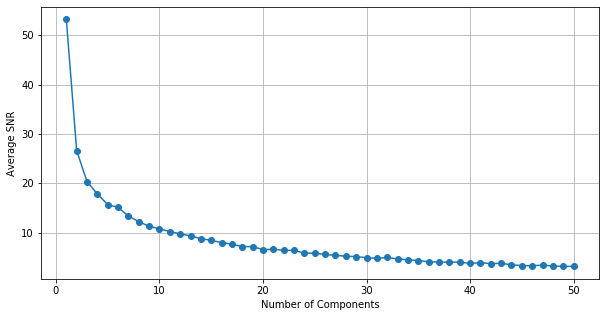

In [67]:
plt.plot(range(1,ComponentsNumbers+1),mean_SNR, marker='o')
plt.ylabel("Average SNR")
plt.xlabel("Number of Components")
plt.grid()
plt.show()

In [68]:
output_df = pd.DataFrame({'x': range(1,ComponentsNumbers+1),'y': mean_SNR})  
output_df.to_csv('weighted_bound_step_'+str(s)+'.dat')